In [1]:
import sys
import scipy.stats
from scipy.signal import coherence
from scipy.cluster.hierarchy import fcluster
from sklearn import metrics
from sklearn.linear_model import LinearRegression

from trajectory_process import traj_process

import numpy as np
from scipy.cluster import hierarchy
from sklearn import cluster
import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib notebook
import glob
import re  # Regular expression operations
import pandas as pd
from scipy import signal
import mne
from tqdm import tqdm
import os
from os.path import exists
import pickle
import statsmodels.stats.api as sms

base_dir = '/home/fu/Data/ephys/'
sys.path.append('D:\ephys')

import utils
import ephys
import plotting

plt.rcParams["axes.labelsize"] = 12
plt.rcParams["font.size"] = 7
# plt.rcParams["font.family"] = "Arial"

mBWfus009 = {
    'arena_0219': '2021-02-19_mBWfus009_arena_ephys',
    'ezm_0219': '2021-02-19_mBWfus009_EZM_ephys',
    'oft_0219': '2021-02-19_mBWfus009_OF_ephys',

    'arena_0226': '2021-02-26_mBWfus009_arena_ephys',
    'ezm_0226': '2021-02-26_mBWfus009_EZM_ephys',
    'oft_0226': '2021-02-26_mBWfus009_OF_ephys',

    'arena_0305_bef': '2021-03-05_mBWfus009_before_arena_ephys',
    'cage_0305': '2021-03-05_mBWfus009_cage_arena_ephys',
    'arena_0305_aft': '2021-03-05_mBWfus009_after_arena_ephys',
    'ezm_0305': '2021-03-05_mBWfus009_EZM_ephys',
    'oft_0305': '2021-03-05_mBWfus009_OF_ephys',

    'arena_0325': '2021-03-25_mBWfus009_arena_ephys',
    'epm_0325': '2021-03-25_mBWfus009_EPM_ephys'
}

mBWfus008 = {
    'arena_0219': '2021-02-19_mBWfus008_arena_ephys',
    'ezm_0219': '2021-02-19_mBWfus008_EZM_ephys',
    'oft_0219': '2021-02-19_mBWfus008_OF_ephys',

    'arena_0226': '2021-02-26_mBWfus008_arena_ephys',
    'ezm_0226': '2021-02-26_mBWfus008_EZM_ephys',
    'oft_0226': '2021-02-26_mBWfus008_OF_ephys',

    'arena_0305_bef': '2021-03-05_mBWfus008_before_arena_ephys',
    'cage_0305': '2021-03-05_mBWfus008_cage_arena_ephys',
    'arena_0305_aft': '2021-03-05_mBWfus008_after_arena_ephys',
    'ezm_0305': '2021-03-05_mBWfus008_EZM_ephys',
    'oft_0305': '2021-03-05_mBWfus008_OF_ephys',
}

mBWfus010 = {
    'arena_0219': '2021-02-19_mBWfus010_arena_ephys',
    'ezm_0219': '2021-02-19_mBWfus010_EZM_ephys',
    'oft_0219': '2021-02-19_mBWfus010_OF_ephys',

    'arena_0301_aft': '2021-03-01_mBWfus010_arena_ephys_after',
    'arena_0301_bef': '2021-03-01_mBWfus010_arena_ephys_before',
    'cage_0301': '2021-03-01_mBWfus010_cage_ephys',
    'oft_0301': '2021-03-01_mBWfus010_OF_ephys',
    'ezm_0301': '2021-03-01_mBWfus010_EZM_ephys',

    'arena_0307_bef': '2021-03-07_mBWfus010_after_arena_ephys',
    'cage_0307': '2021-03-07_mBWfus010_cage_arena_ephys',
    'arena_0307_aft': '2021-03-07_mBWfus010_after_arena_ephys',
    'ezm_0307': '2021-03-07_mBWfus010_EZM_ephys',
    'oft_0307': '2021-03-07_mBWfus010_OF_ephys',
}

mBWfus011 = {
    'arena_0226': '2021-02-26_mBWfus011_arena_ephys',
    'ezm_0226': '2021-02-26_mBWfus011_EZM_ephys',
    'oft_0226': '2021-02-26_mBWfus011_OF_ephys',

    'arena_0305_aft': '2021-03-05_mBWfus011_after_arena_ephys',
    'cage_0305': '2021-03-05_mBWfus011_cage_arena_ephys',
    'arena_0305_bef': '2021-03-05_mBWfus011_before_arena_ephys',
    'oft_0305': '2021-03-05_mBWfus011_OF_ephys',
    'ezm_0305': '2021-03-05_mBWfus011_EZM_ephys',

    'arena_0313_bef': '2021-03-13_mBWfus011_before_arena_ephys',
    'cage_0313': '2021-03-13_mBWfus011_cage_arena_ephys',
    'arena_0313_aft': '2021-03-13_mBWfus011_after_arena_ephys',
    'ezm_0313': '2021-03-13_mBWfus011_EZM_ephys',
    'oft_0313': '2021-03-13_mBWfus011_OF_ephys',
}

mBWfus012 = {
    'arena_0226': '2021-02-26_mBWfus012_arena_ephys',
    'ezm_0226': '2021-02-26_mBWfus012_EZM_ephys',
    'oft_0226': '2021-02-26_mBWfus012_OF_ephys',
}

In [2]:
np.random.seed(42)
animal = mBWfus009
session = 'arena_0226'
behavior_trigger = 0.0

/home/fu/Data/ephys/2021-02-26_mBWfus009_arena_ephys/ephys_processed/
total number of frames: 49009
frames to process: 45000
edited 31 data points


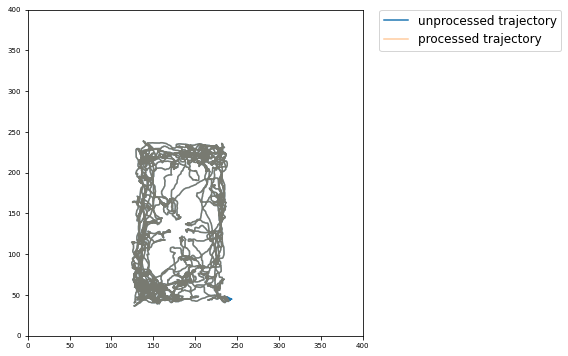

In [3]:
f_behavior = 50
f_ephys = 500
behavior_window_duration = 900
ephys_window_duration = 1000
events = traj_process(base_dir, animal[session], behavior='arena', start_time=behavior_trigger, duration=behavior_window_duration)

2021-02-26_mBWfus009_arena_ephys


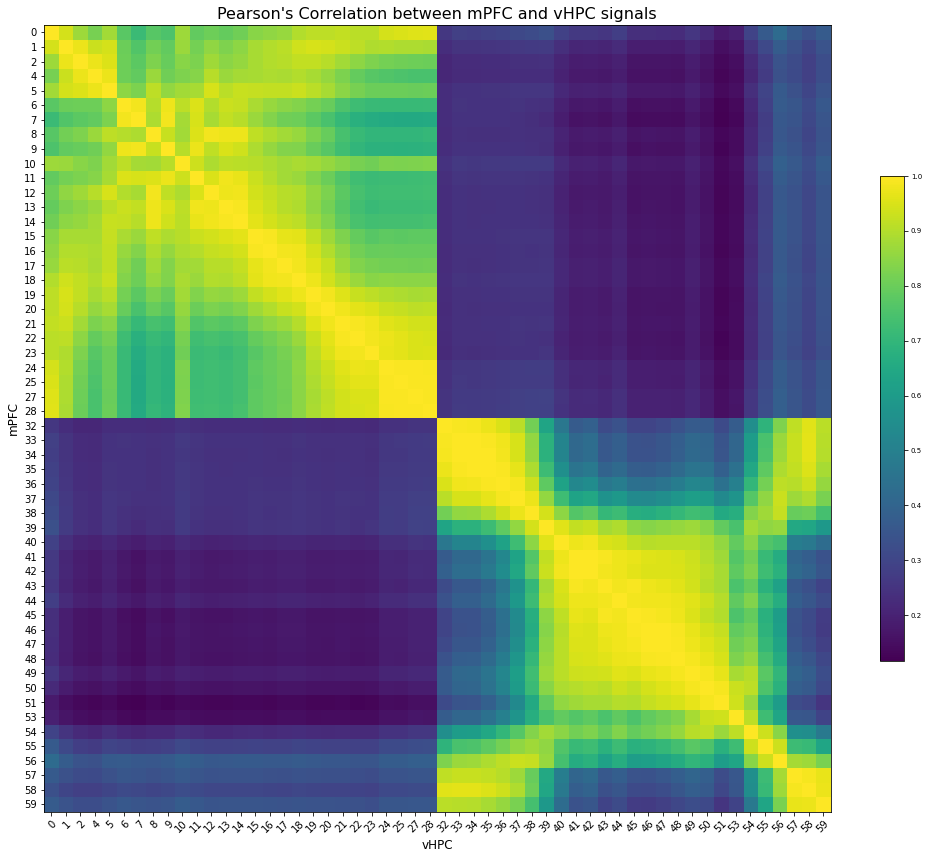

In [4]:
dataset = ephys.load_data(base_dir, animal[session])

power_mpfc = ephys.column_by_pad(ephys.get_power(dataset, 'mpfc', 'theta'))
power_vhipp = ephys.column_by_pad(ephys.get_power(dataset, 'vhipp', 'theta'))

mpfc_pads = np.array(power_mpfc.columns)
vhipp_pads = np.array(power_vhipp.columns)

totlen = len(mpfc_pads) + len(vhipp_pads)
power_corrs = np.zeros((totlen, totlen))
for i in range(totlen):
    for j in range(totlen):
        if i < len(mpfc_pads):
            siga = power_mpfc[mpfc_pads[i]]
        else:
            siga = power_vhipp[vhipp_pads[i-len(mpfc_pads)]]
        if j < len(mpfc_pads):
            sigb = power_mpfc[mpfc_pads[j]]
        else:
            sigb = power_vhipp[vhipp_pads[j-len(mpfc_pads)]]
        power_corrs[i][j] = pd.Series.corr(siga, sigb)

fig, ax = plt.subplots(figsize=(14,14))
im = ax.imshow(power_corrs, vmin=np.min(power_corrs), vmax=np.max(power_corrs))

ax.set_yticks(np.arange(totlen))
ax.set_xticks(np.arange(totlen))

ax.set_yticklabels(np.concatenate((mpfc_pads, vhipp_pads)))
ax.set_xticklabels(np.concatenate((mpfc_pads, vhipp_pads)))

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(10)
    tick.label.set_rotation('vertical')

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(10)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

fig.tight_layout()
fig.colorbar(im, shrink=0.5)
plt.title('Pearson\'s Correlation between mPFC and vHPC signals', fontsize=16)
plt.ylabel('mPFC')
plt.xlabel('vHPC')
plt.show()

In [5]:
exclude=[]

450000
450000


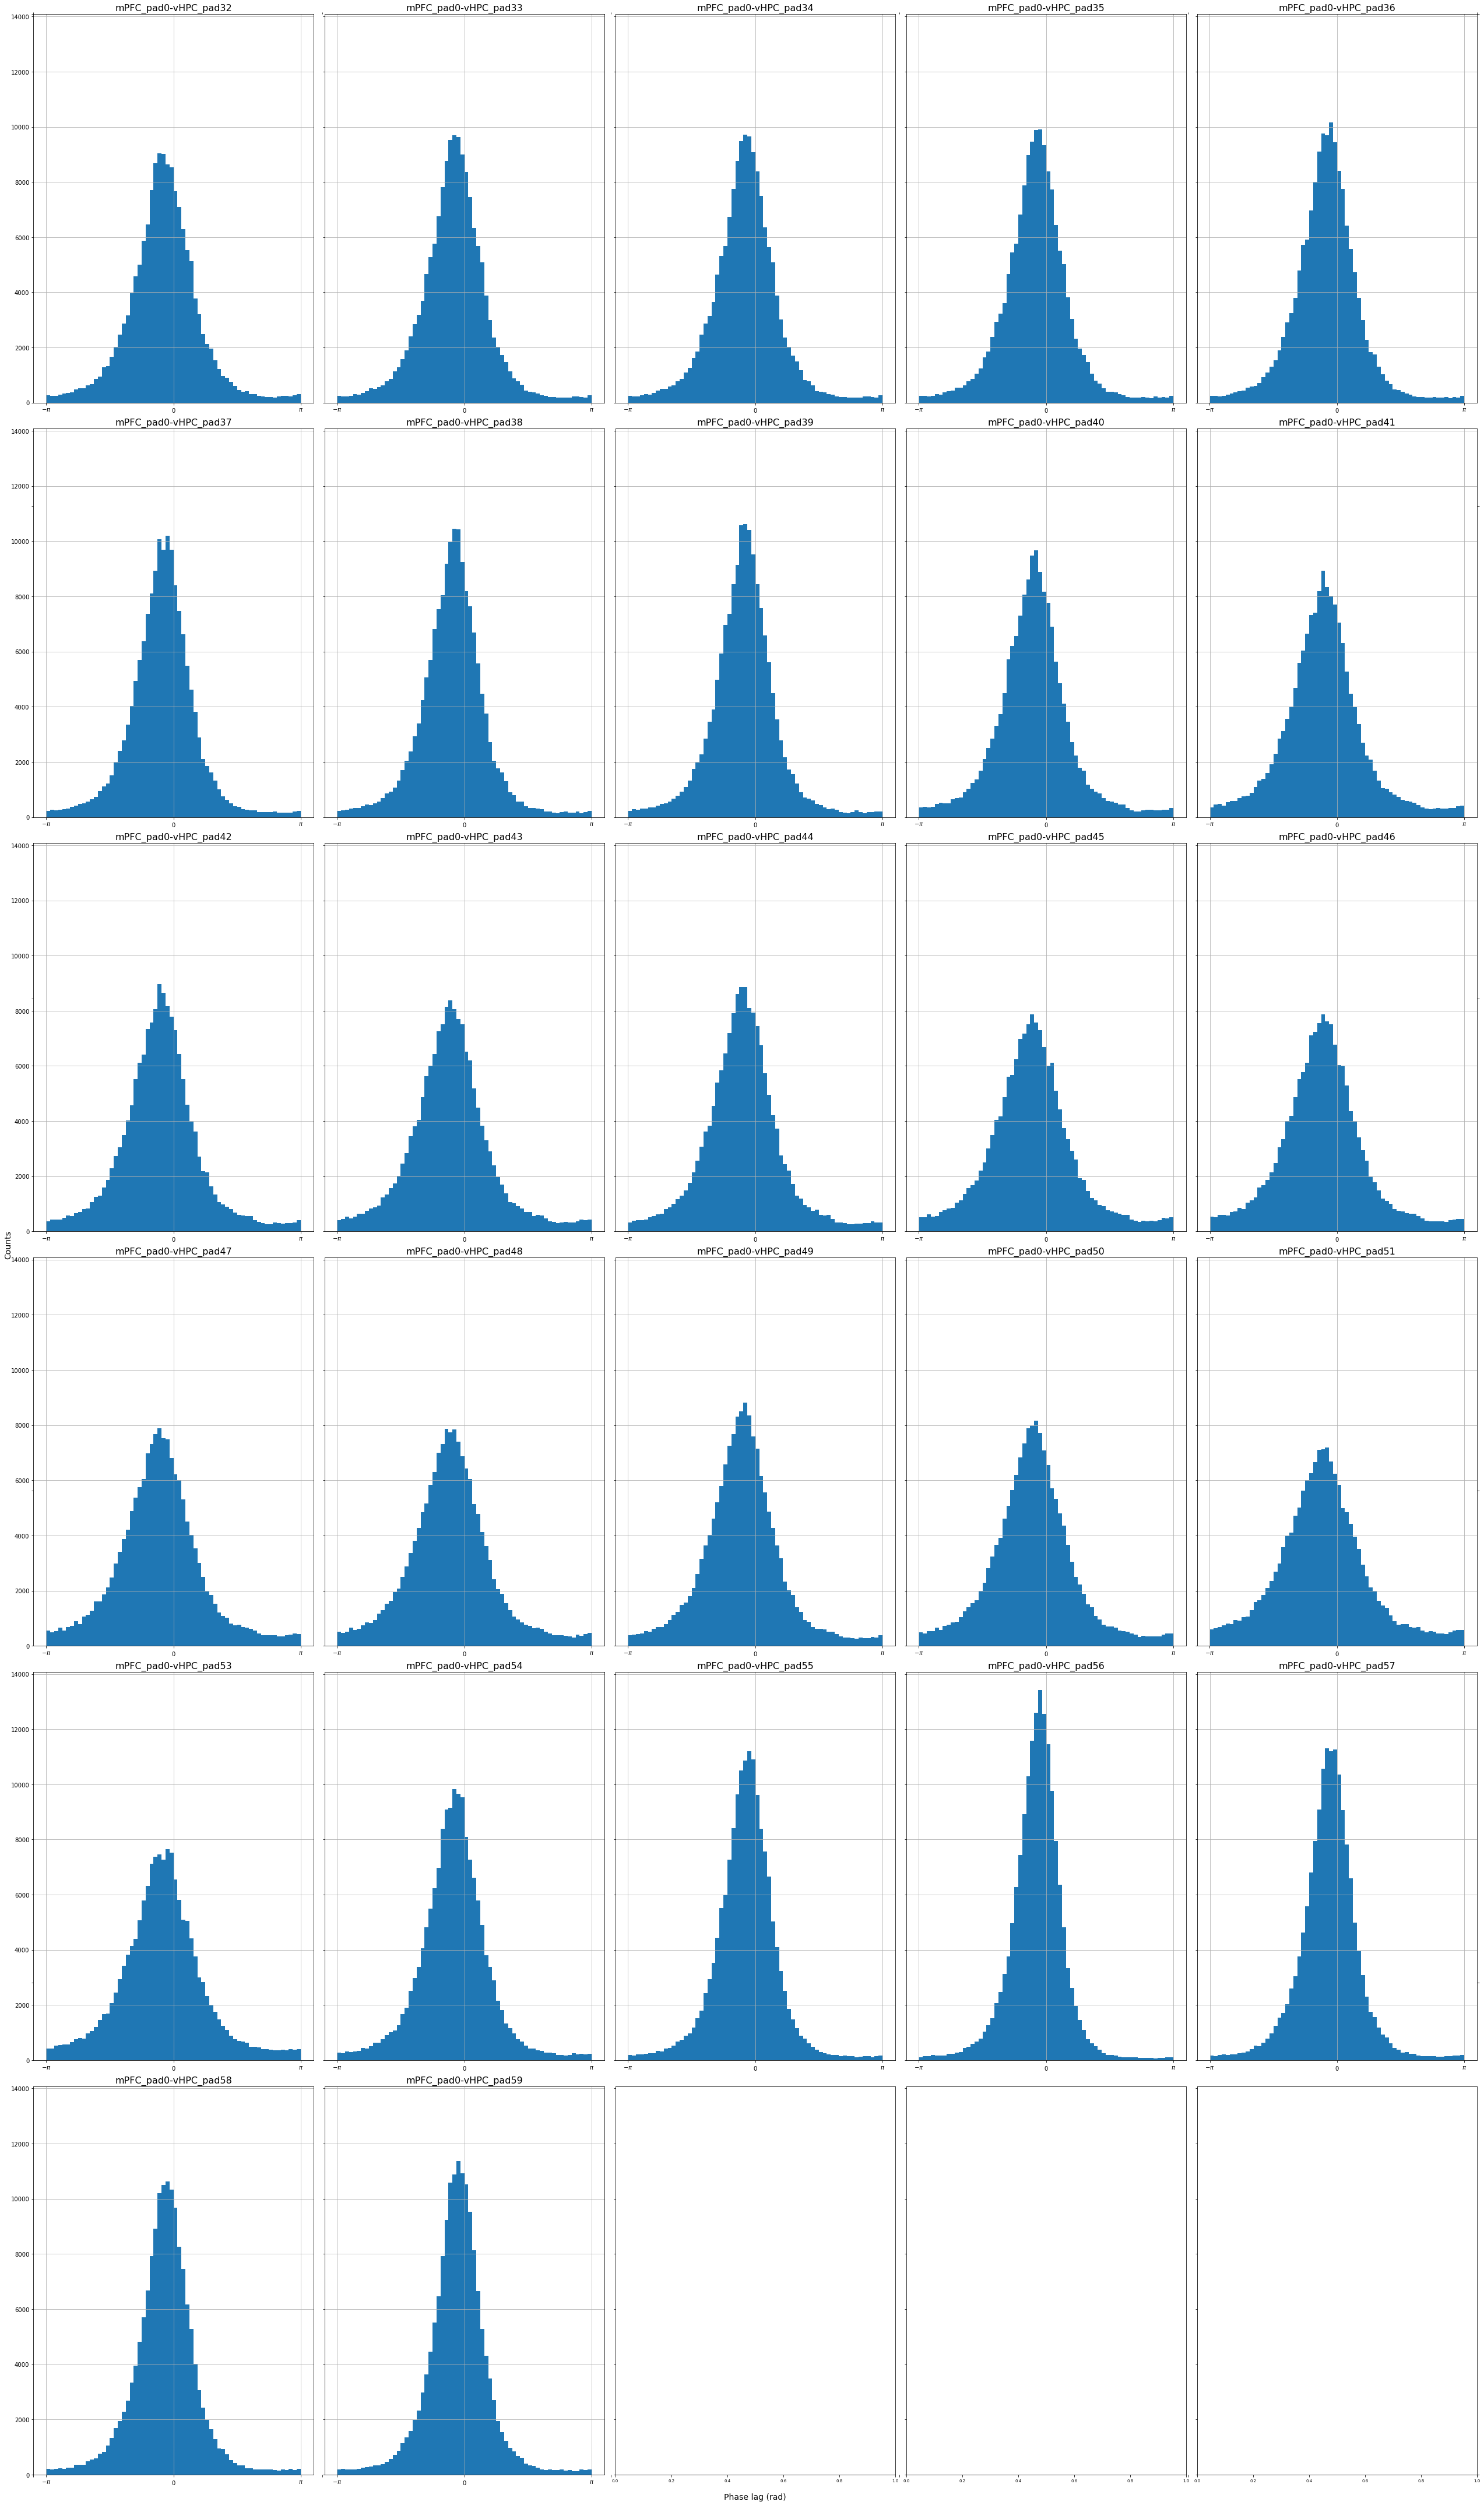

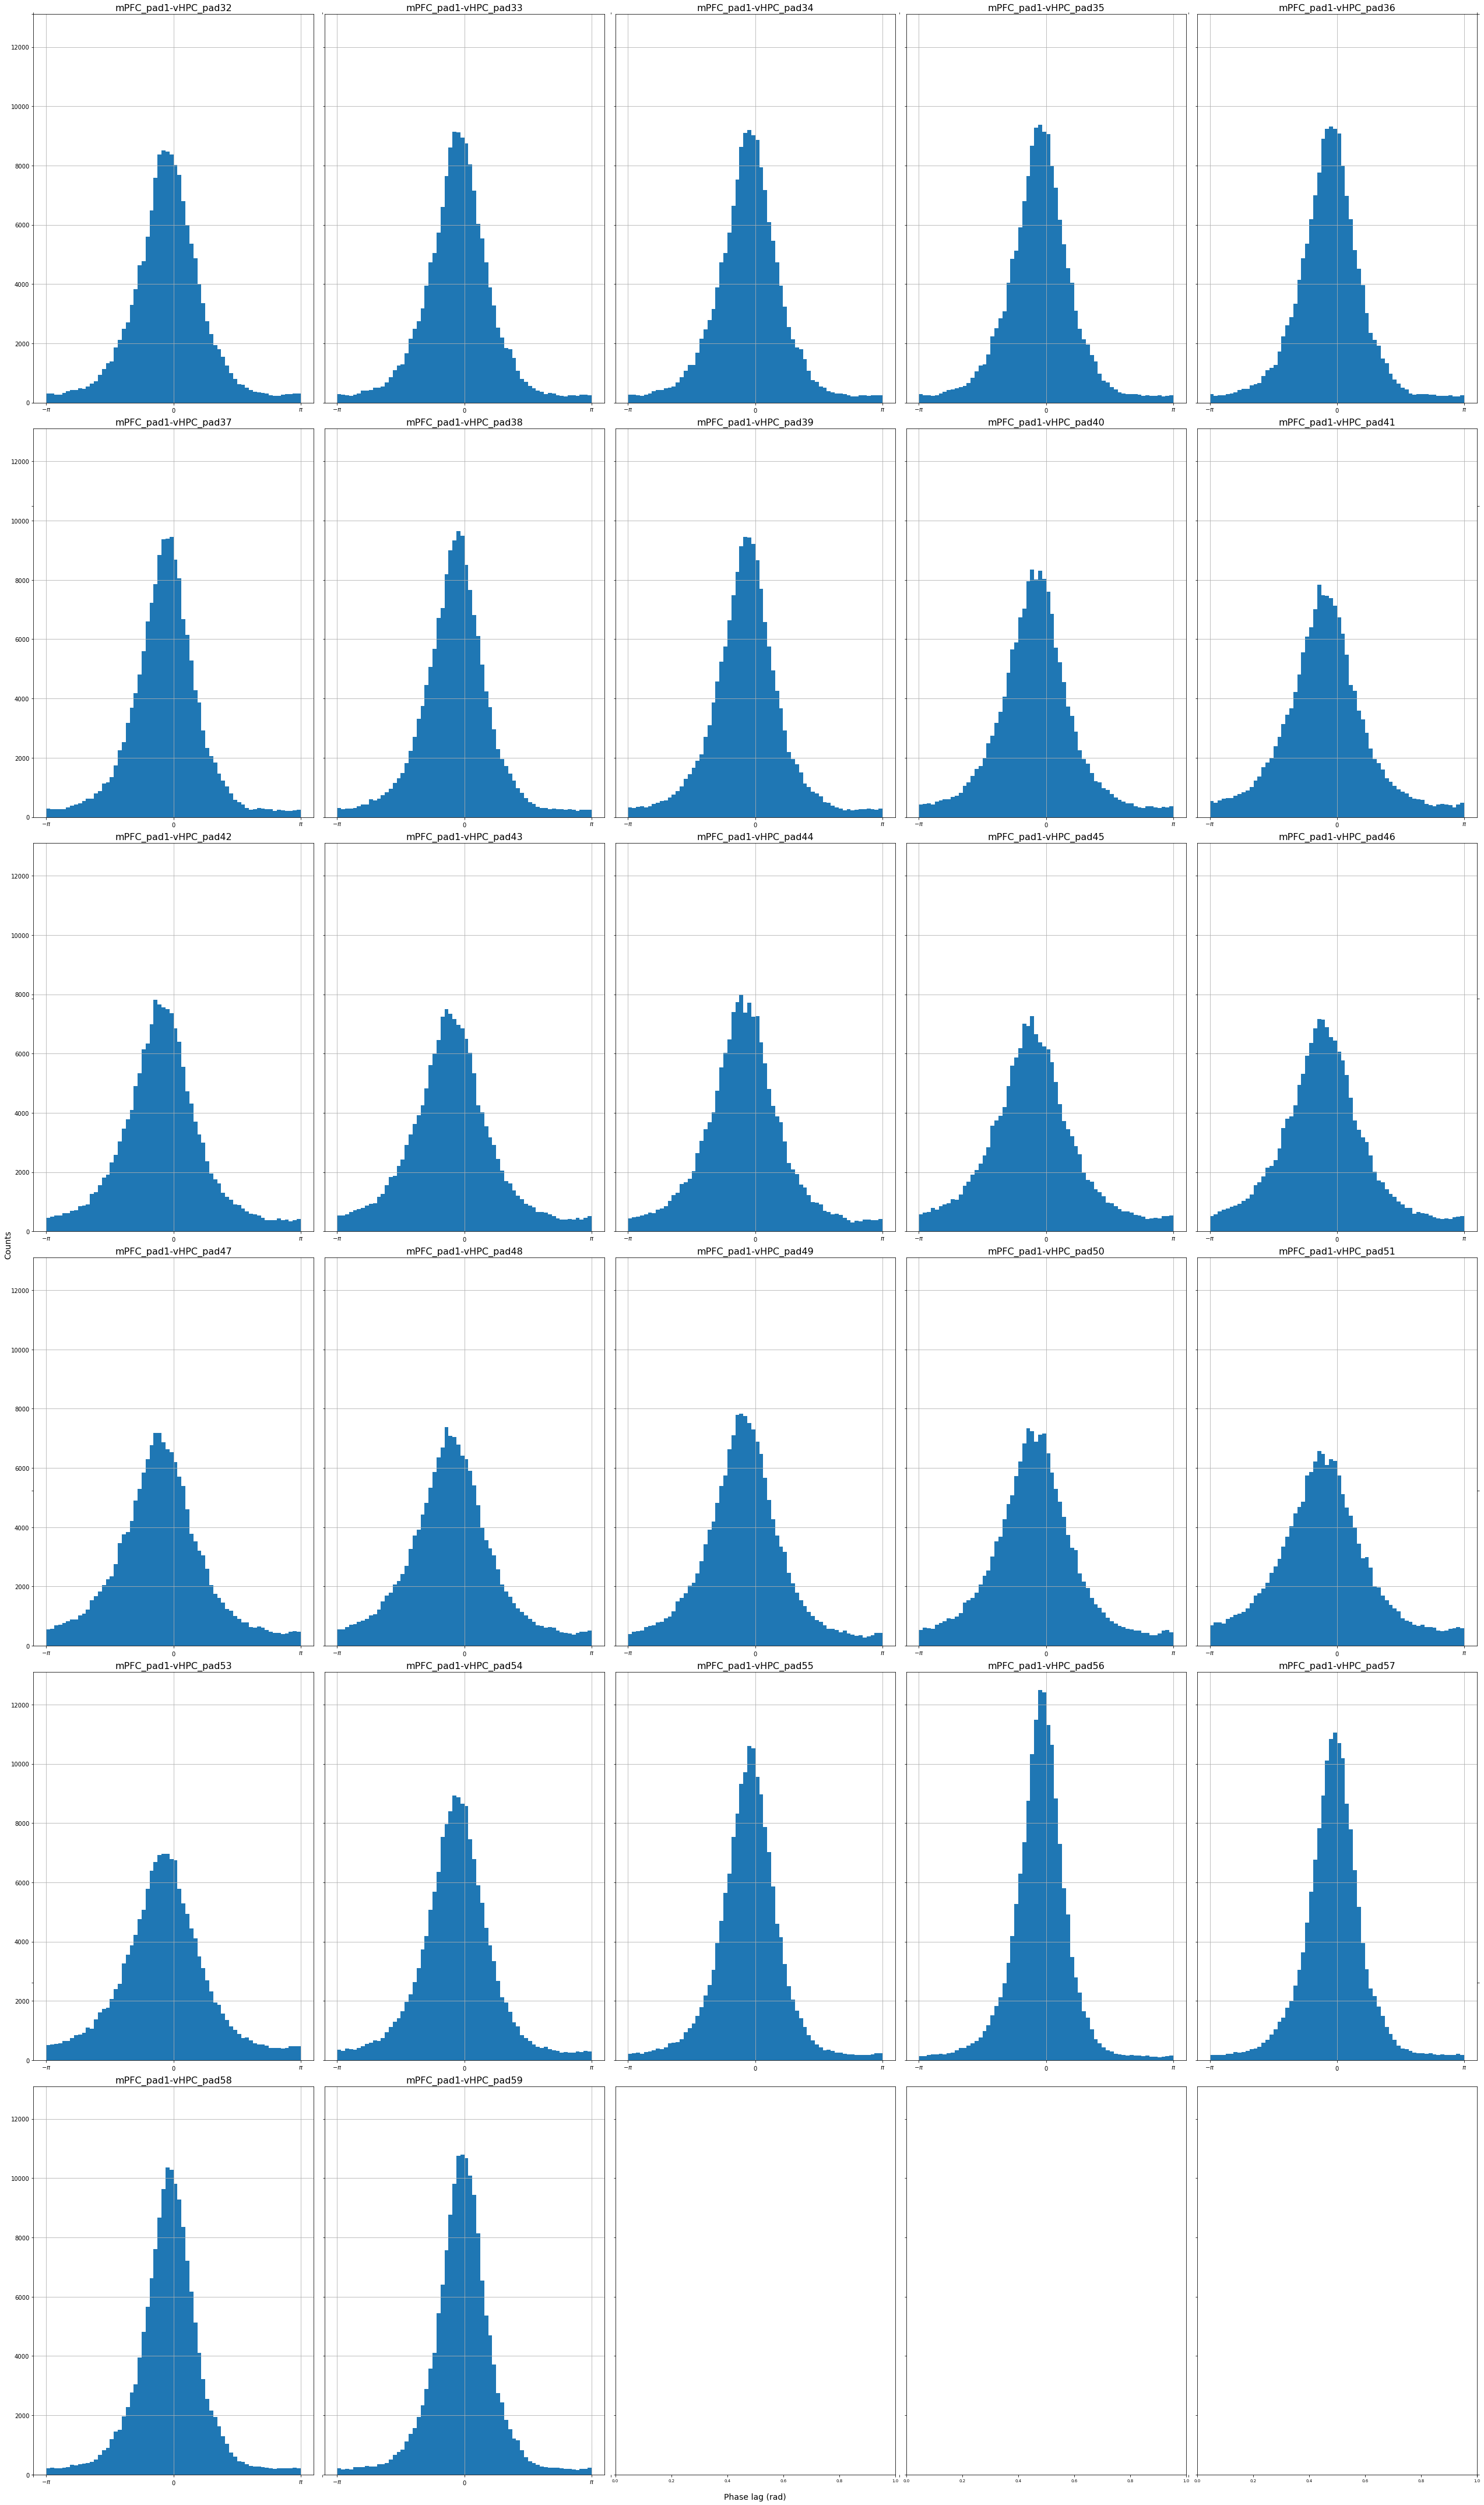

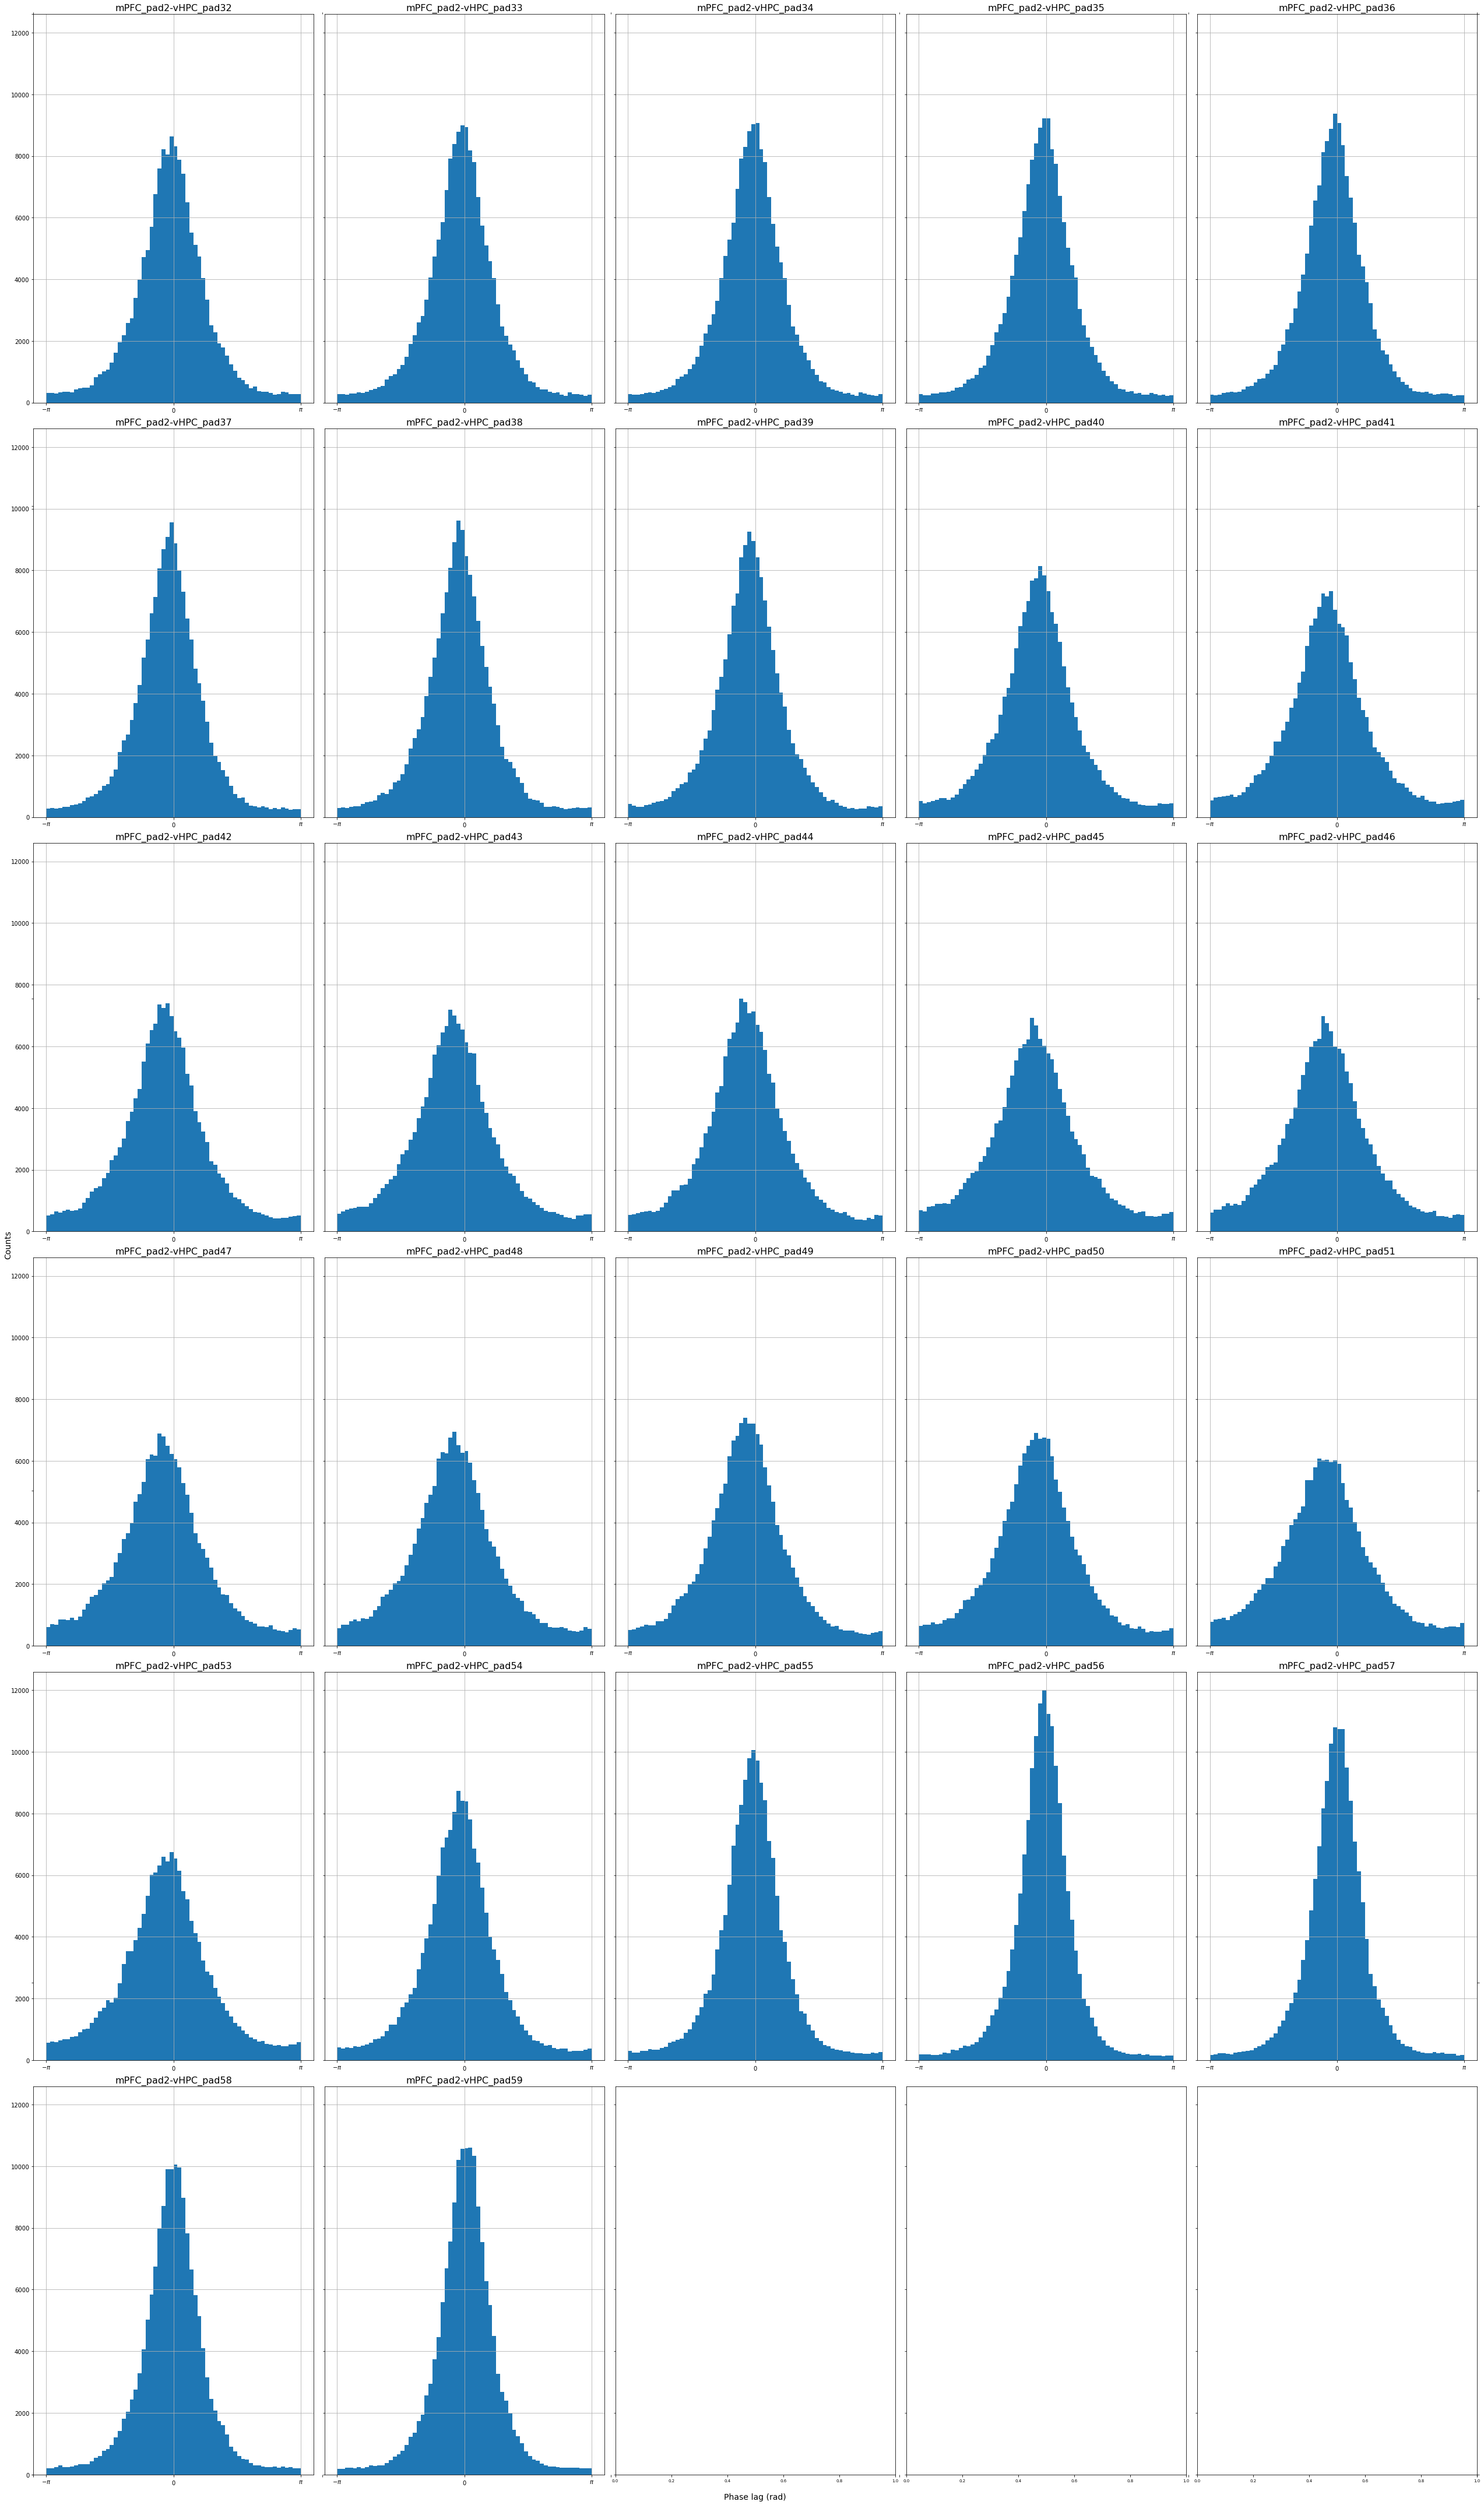

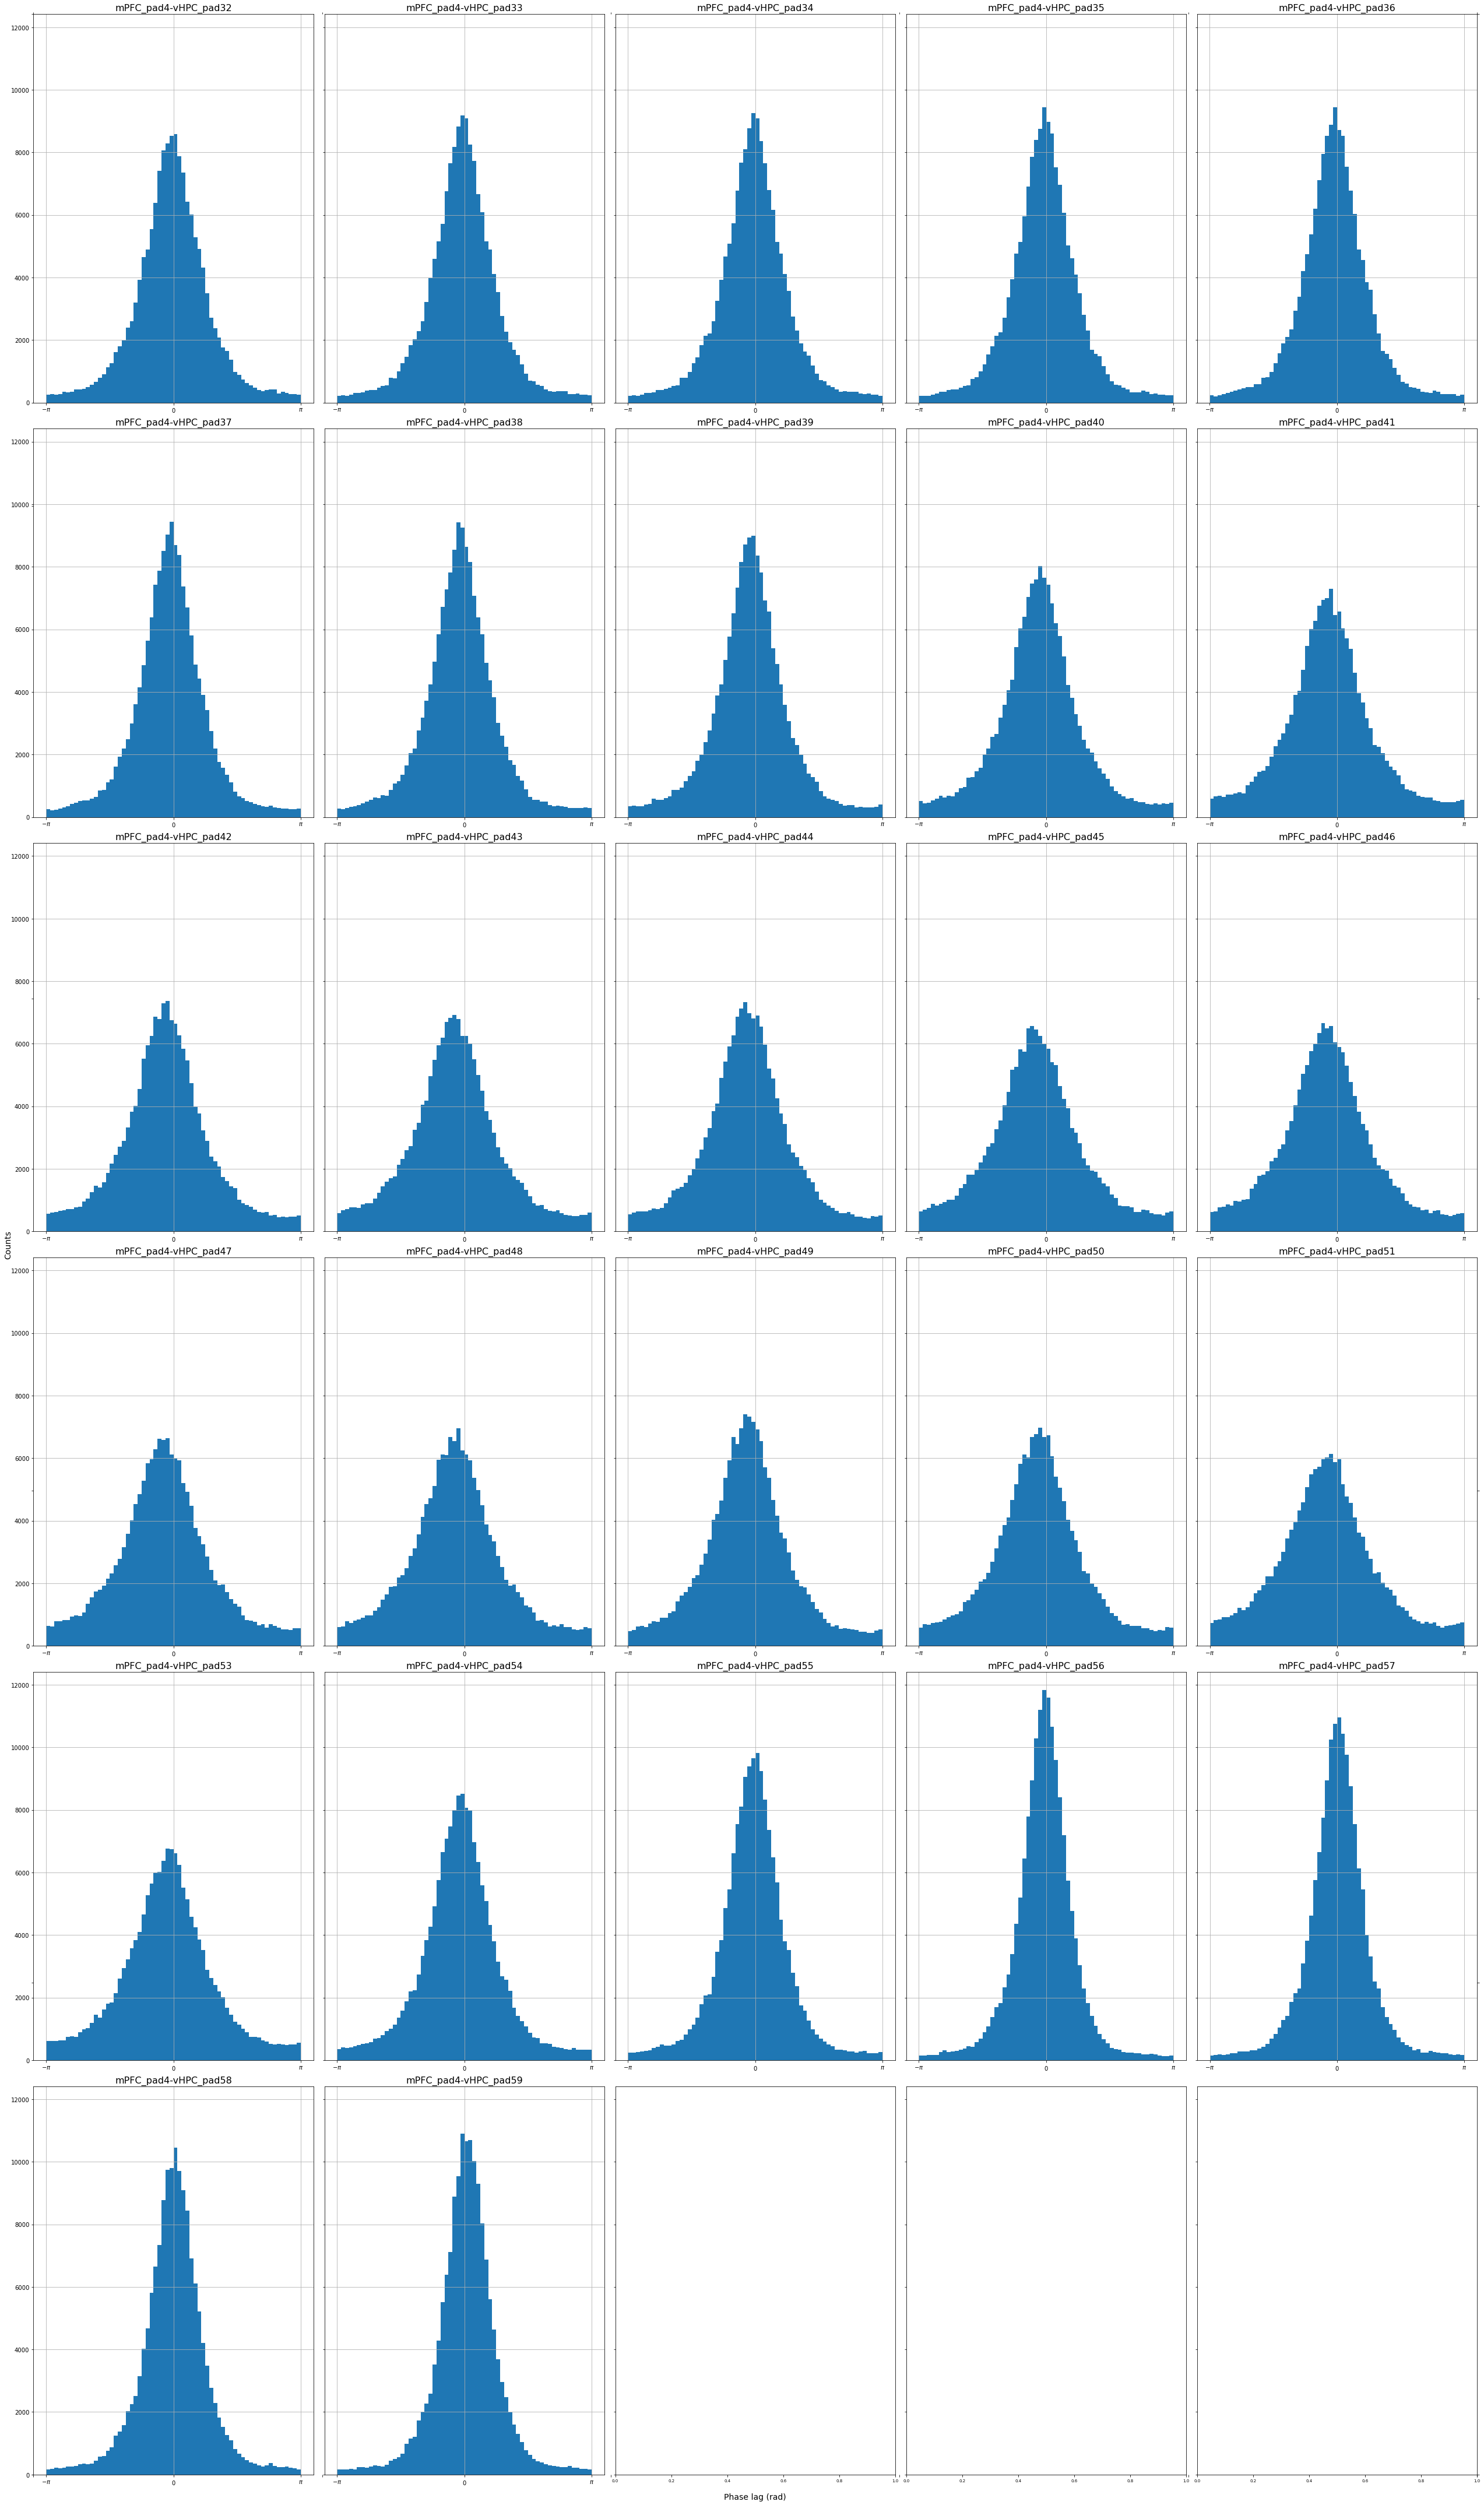

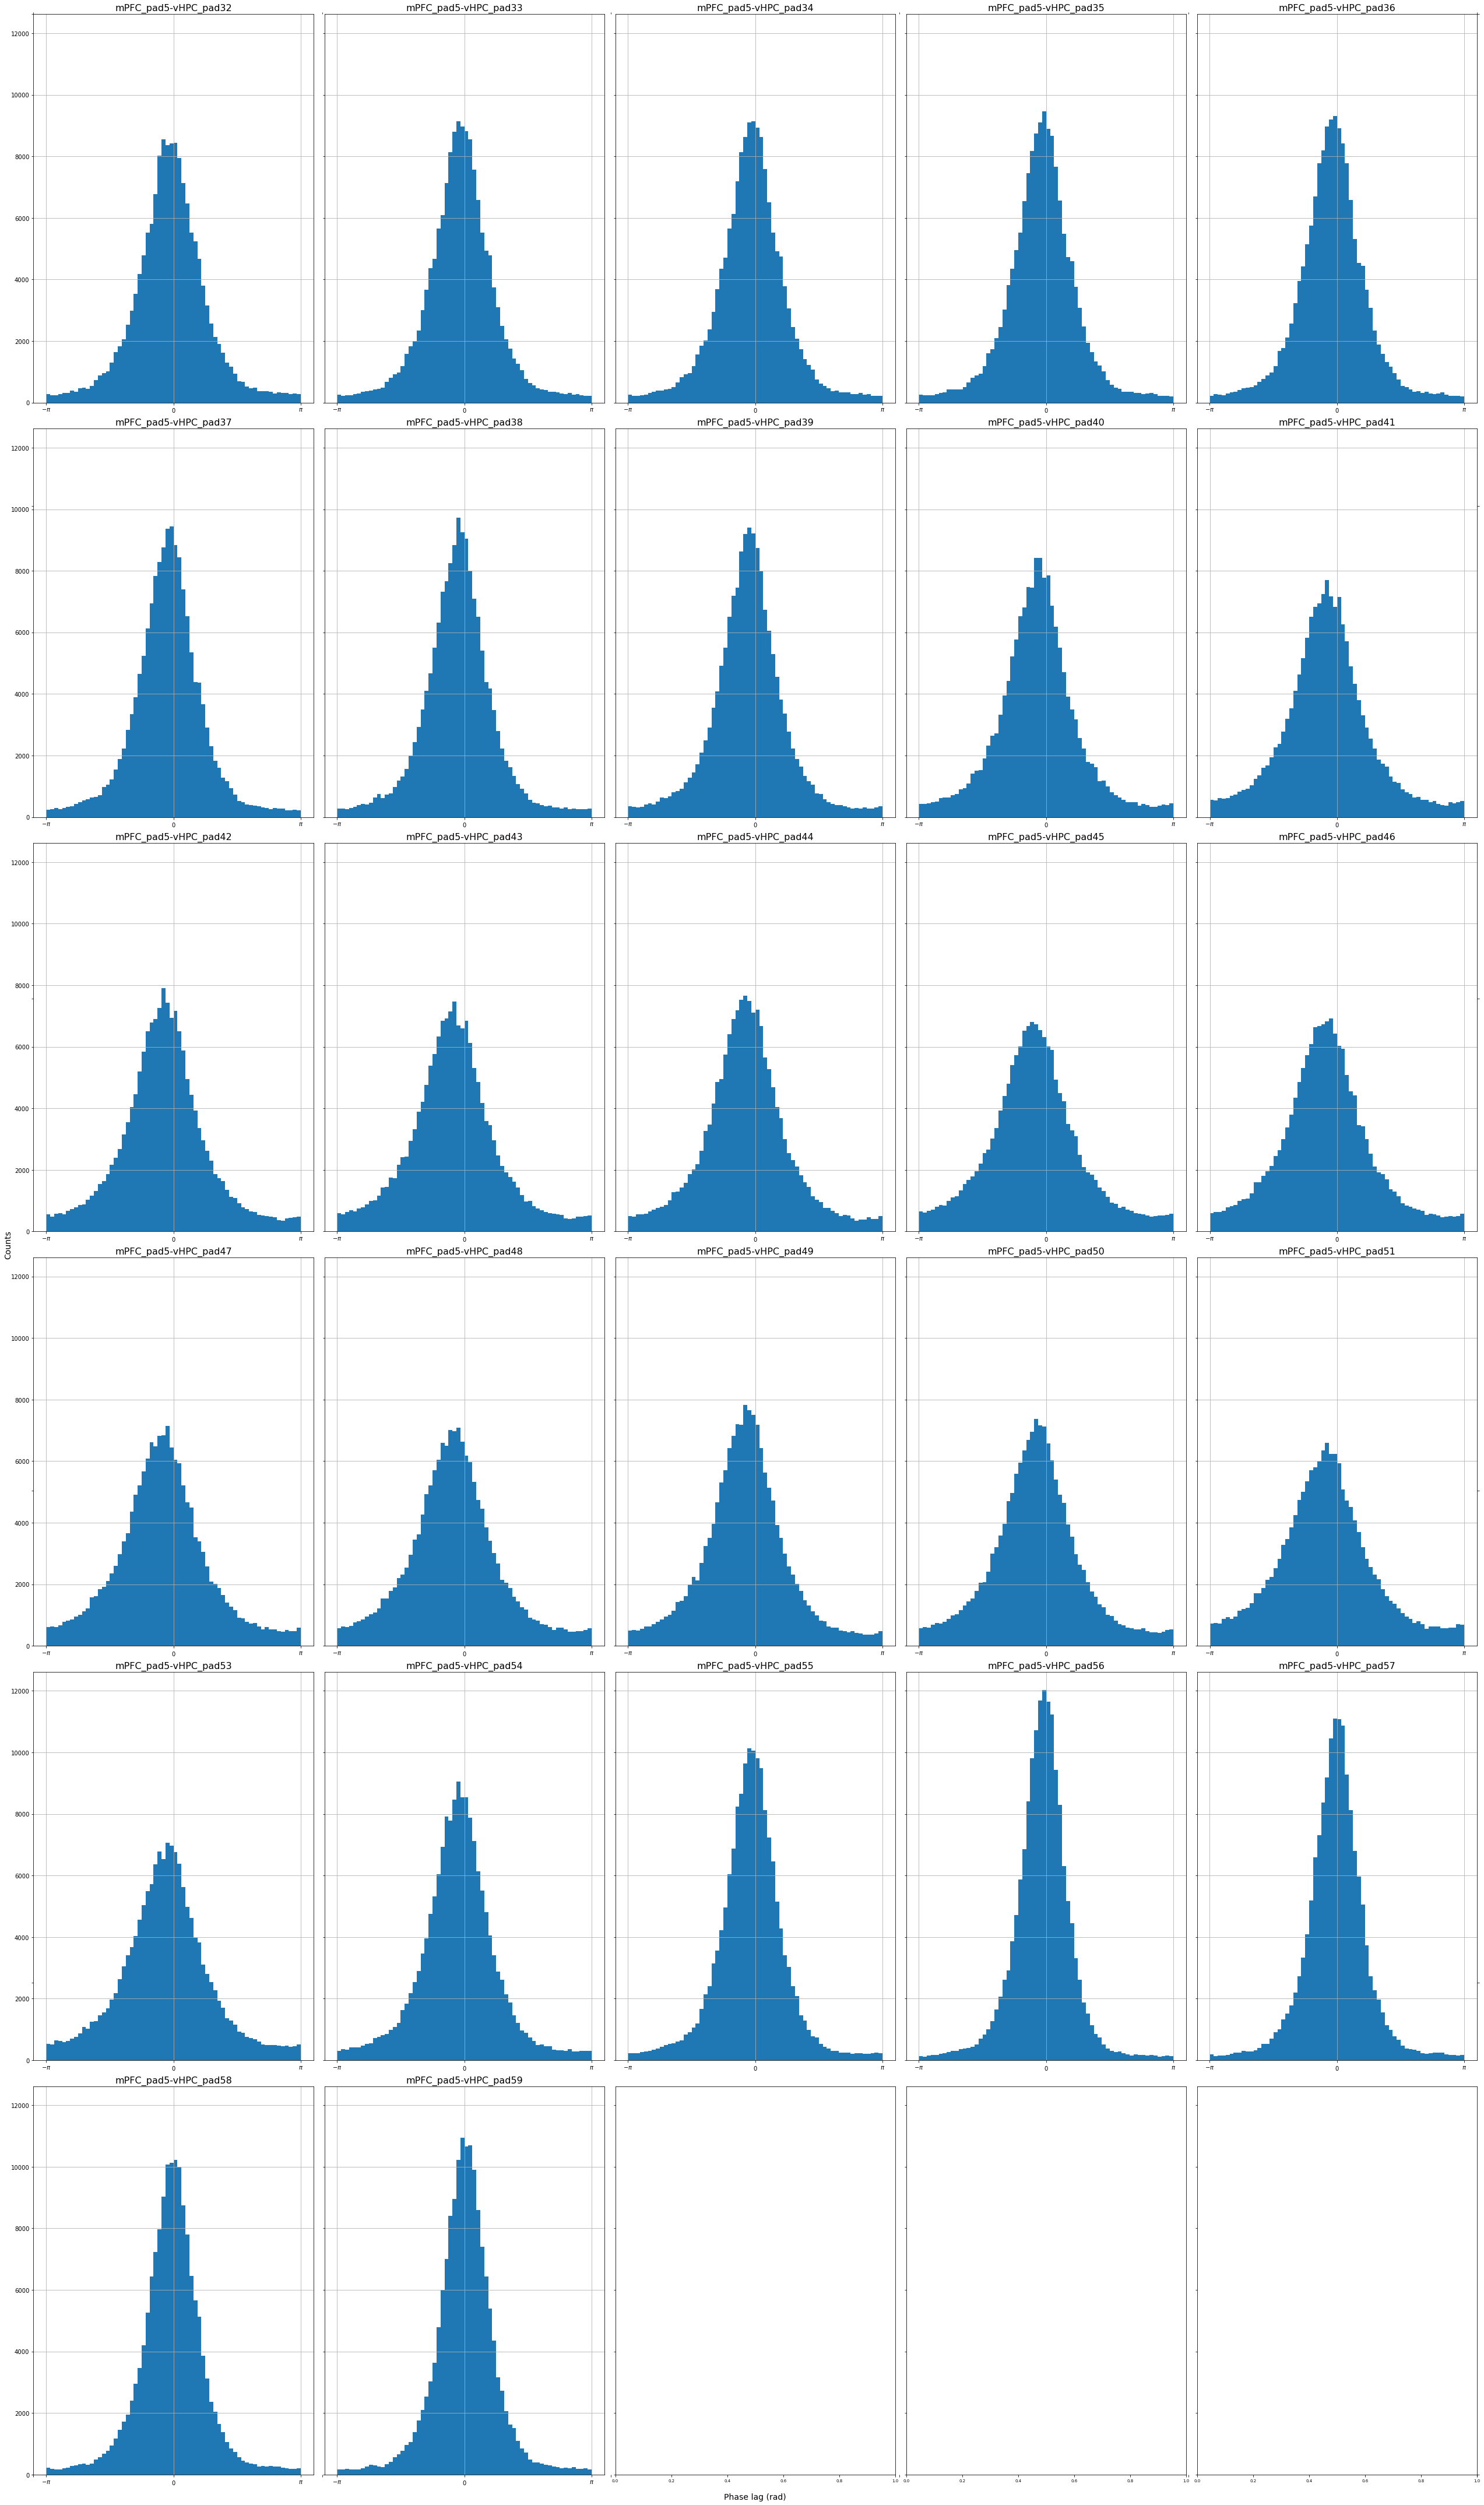

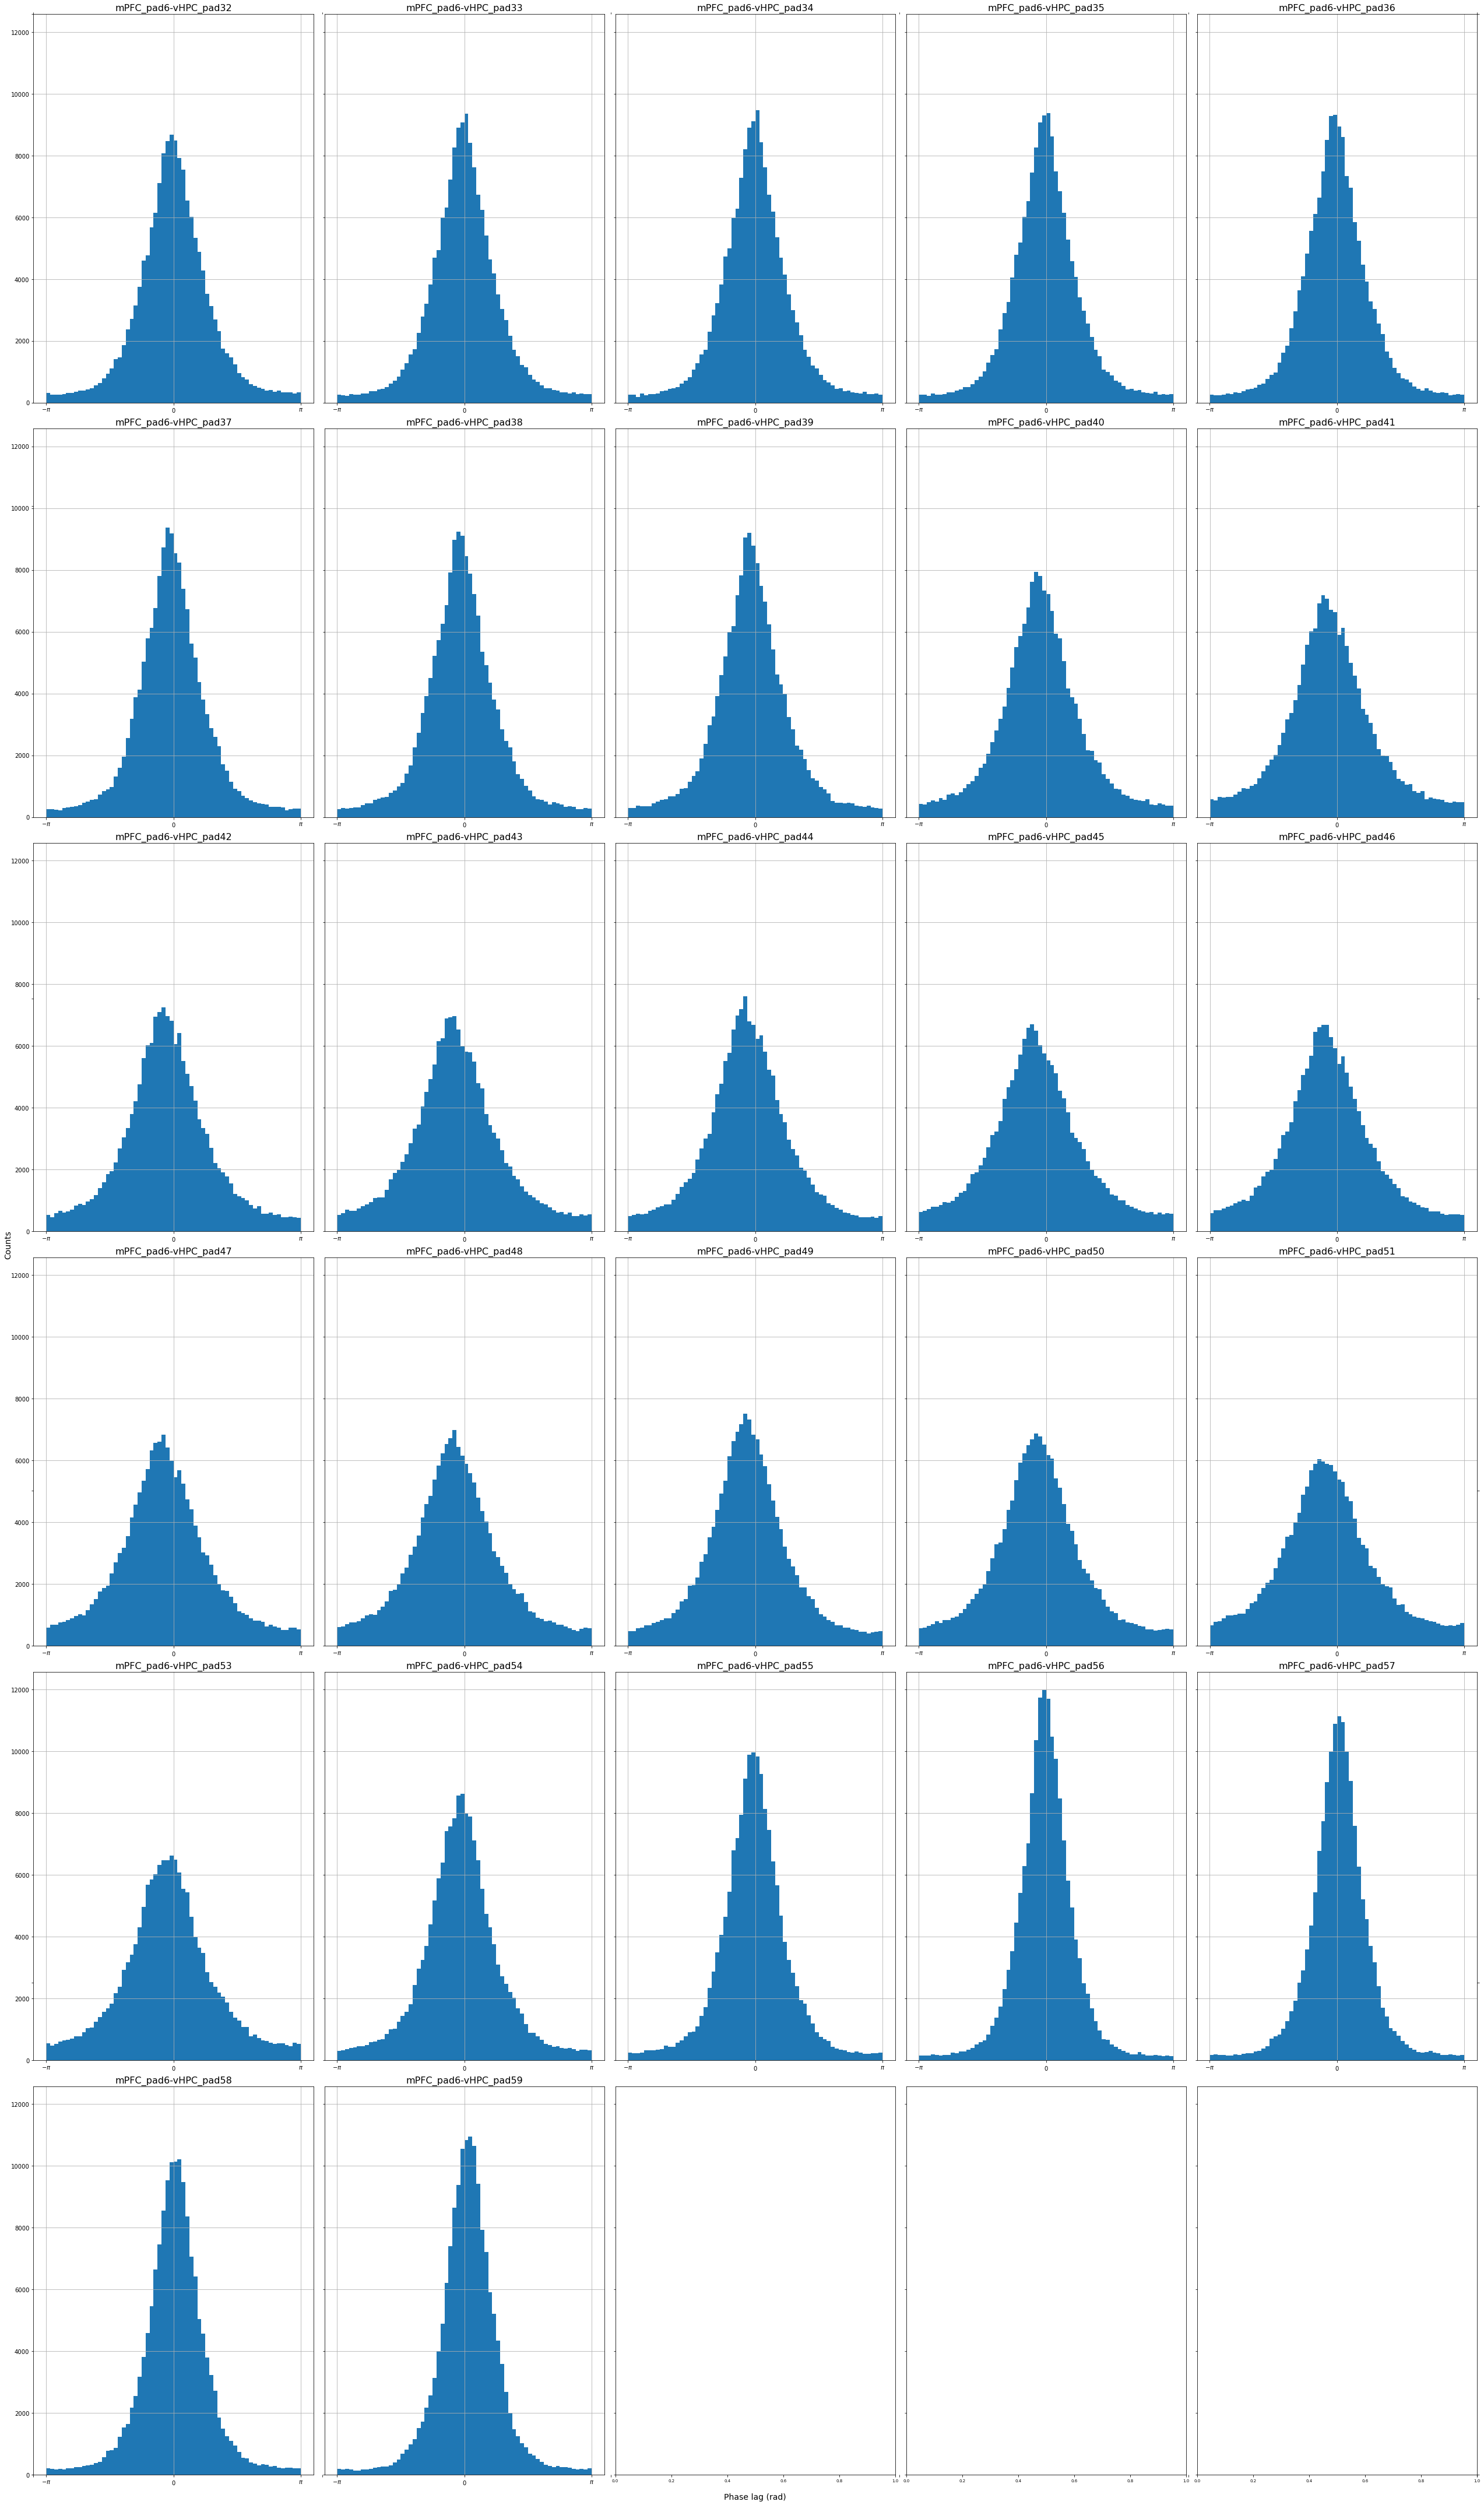

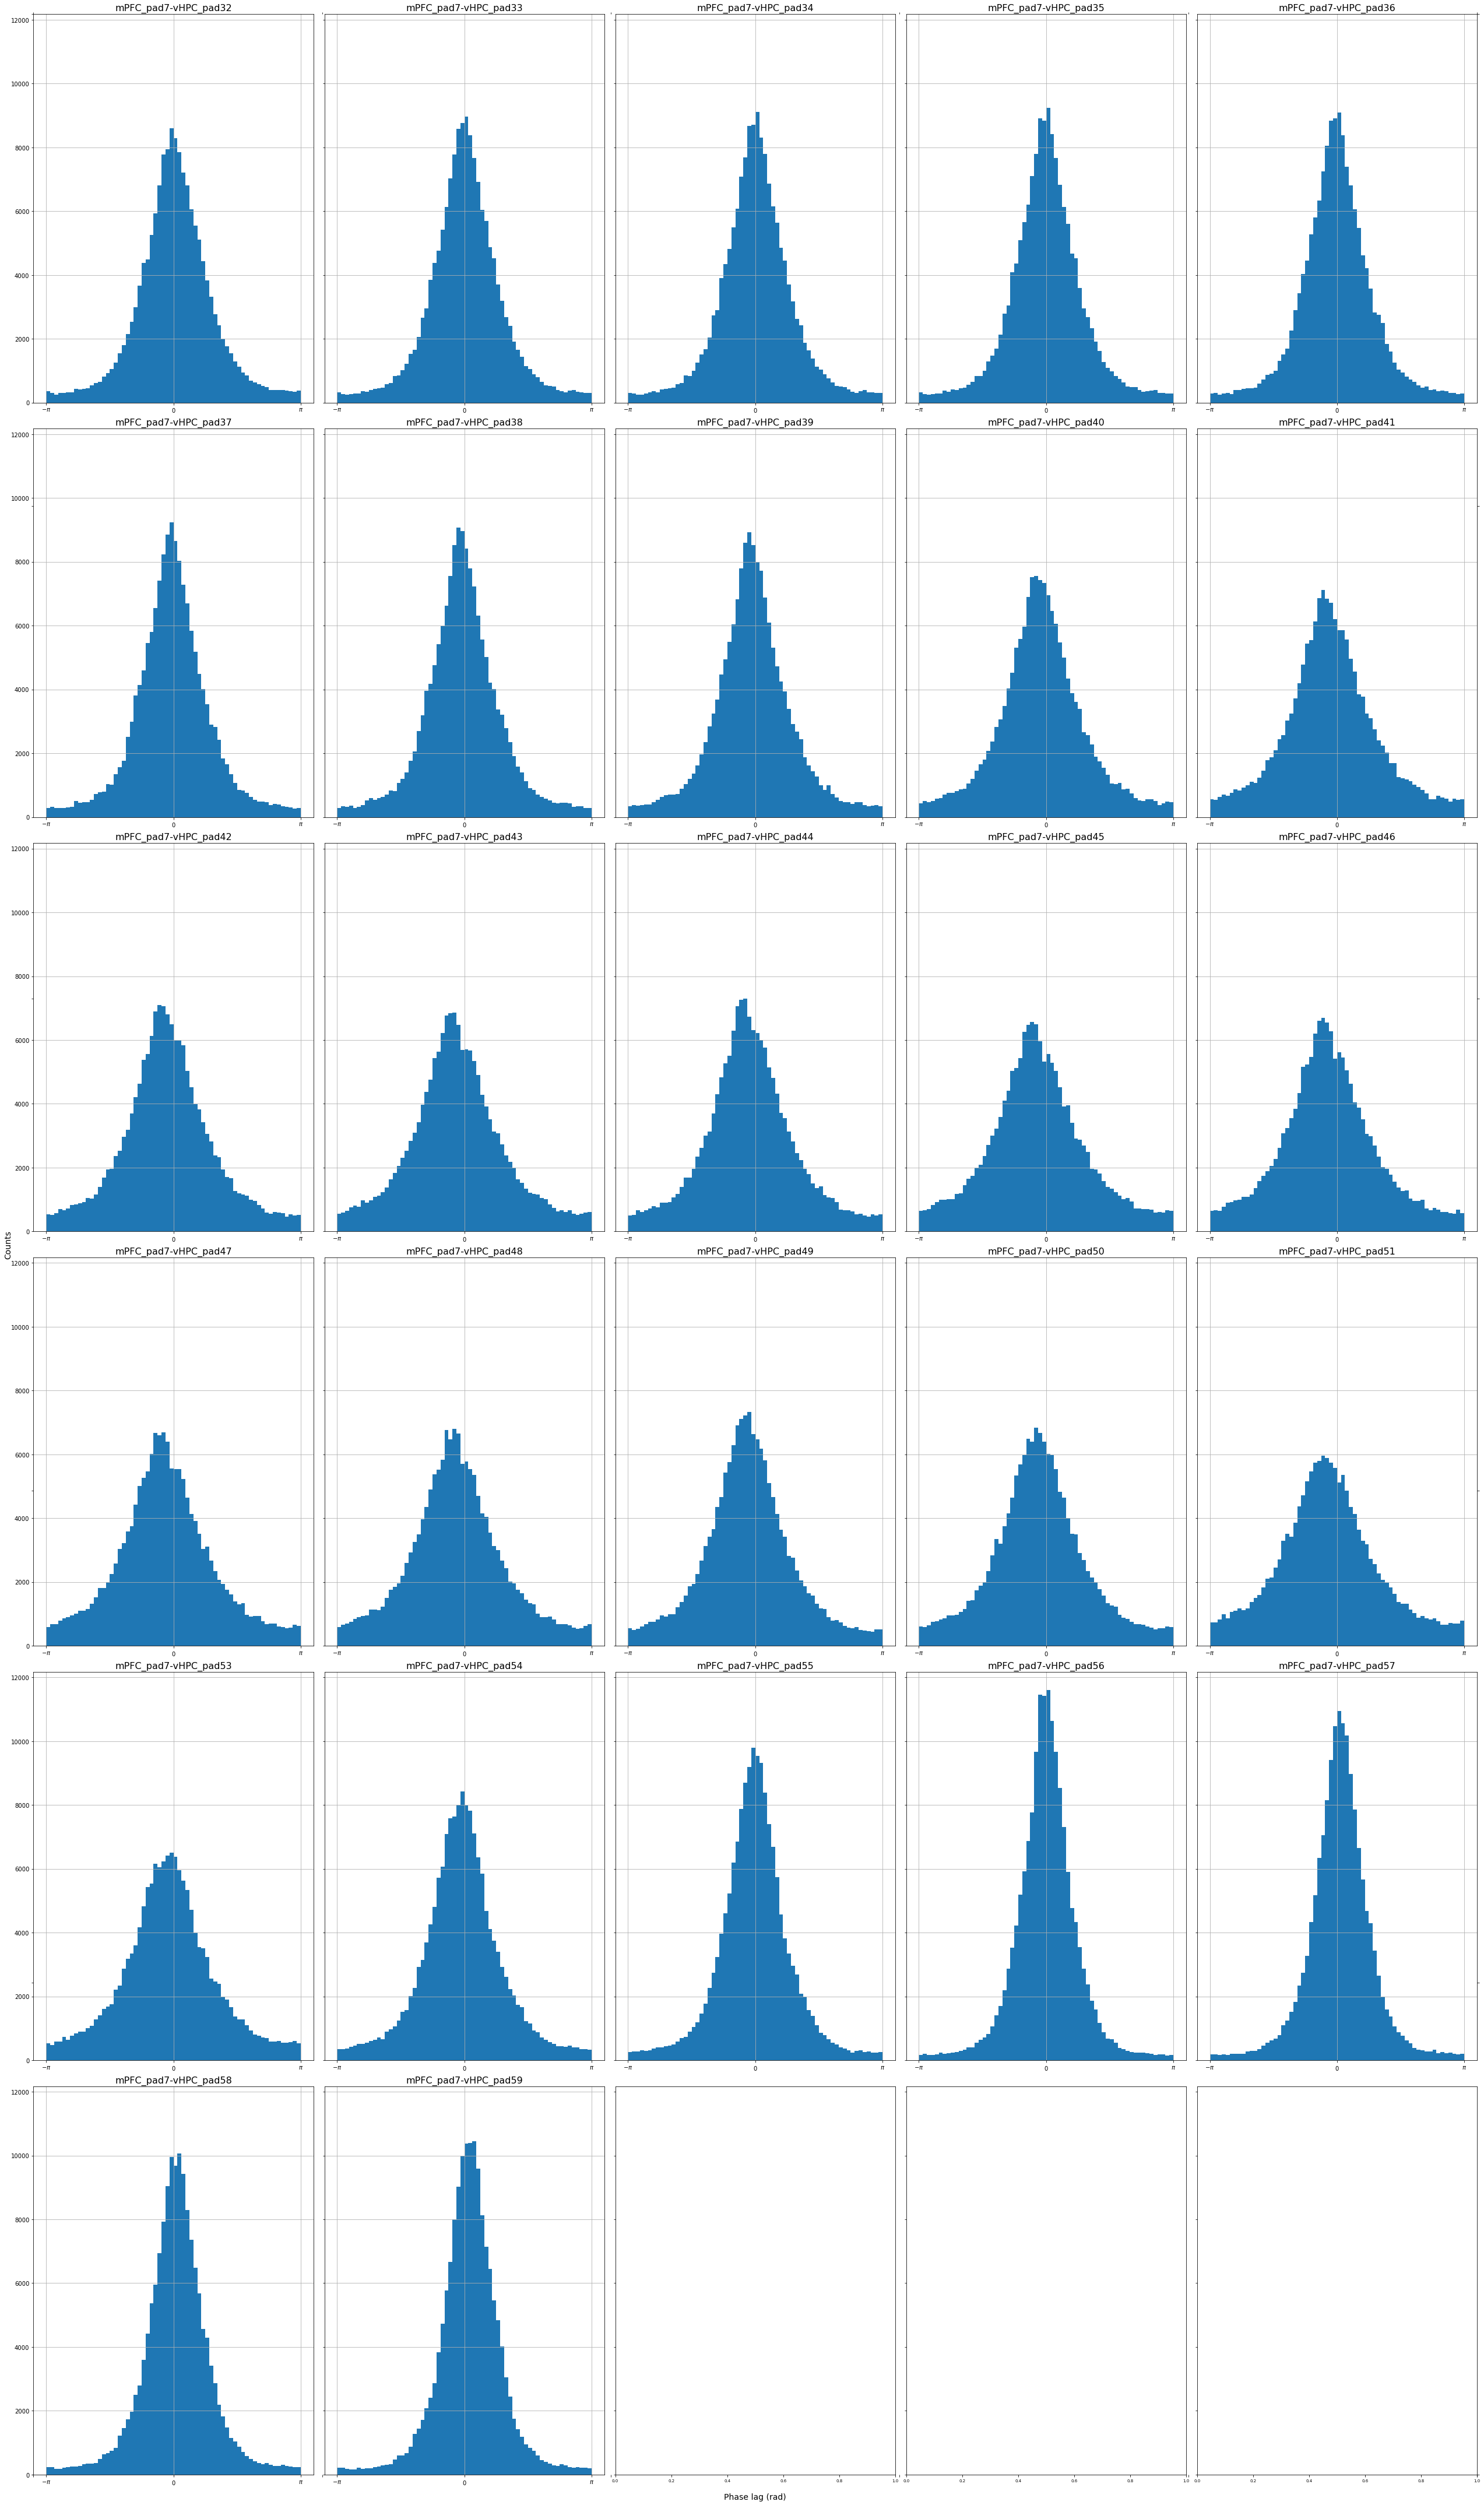

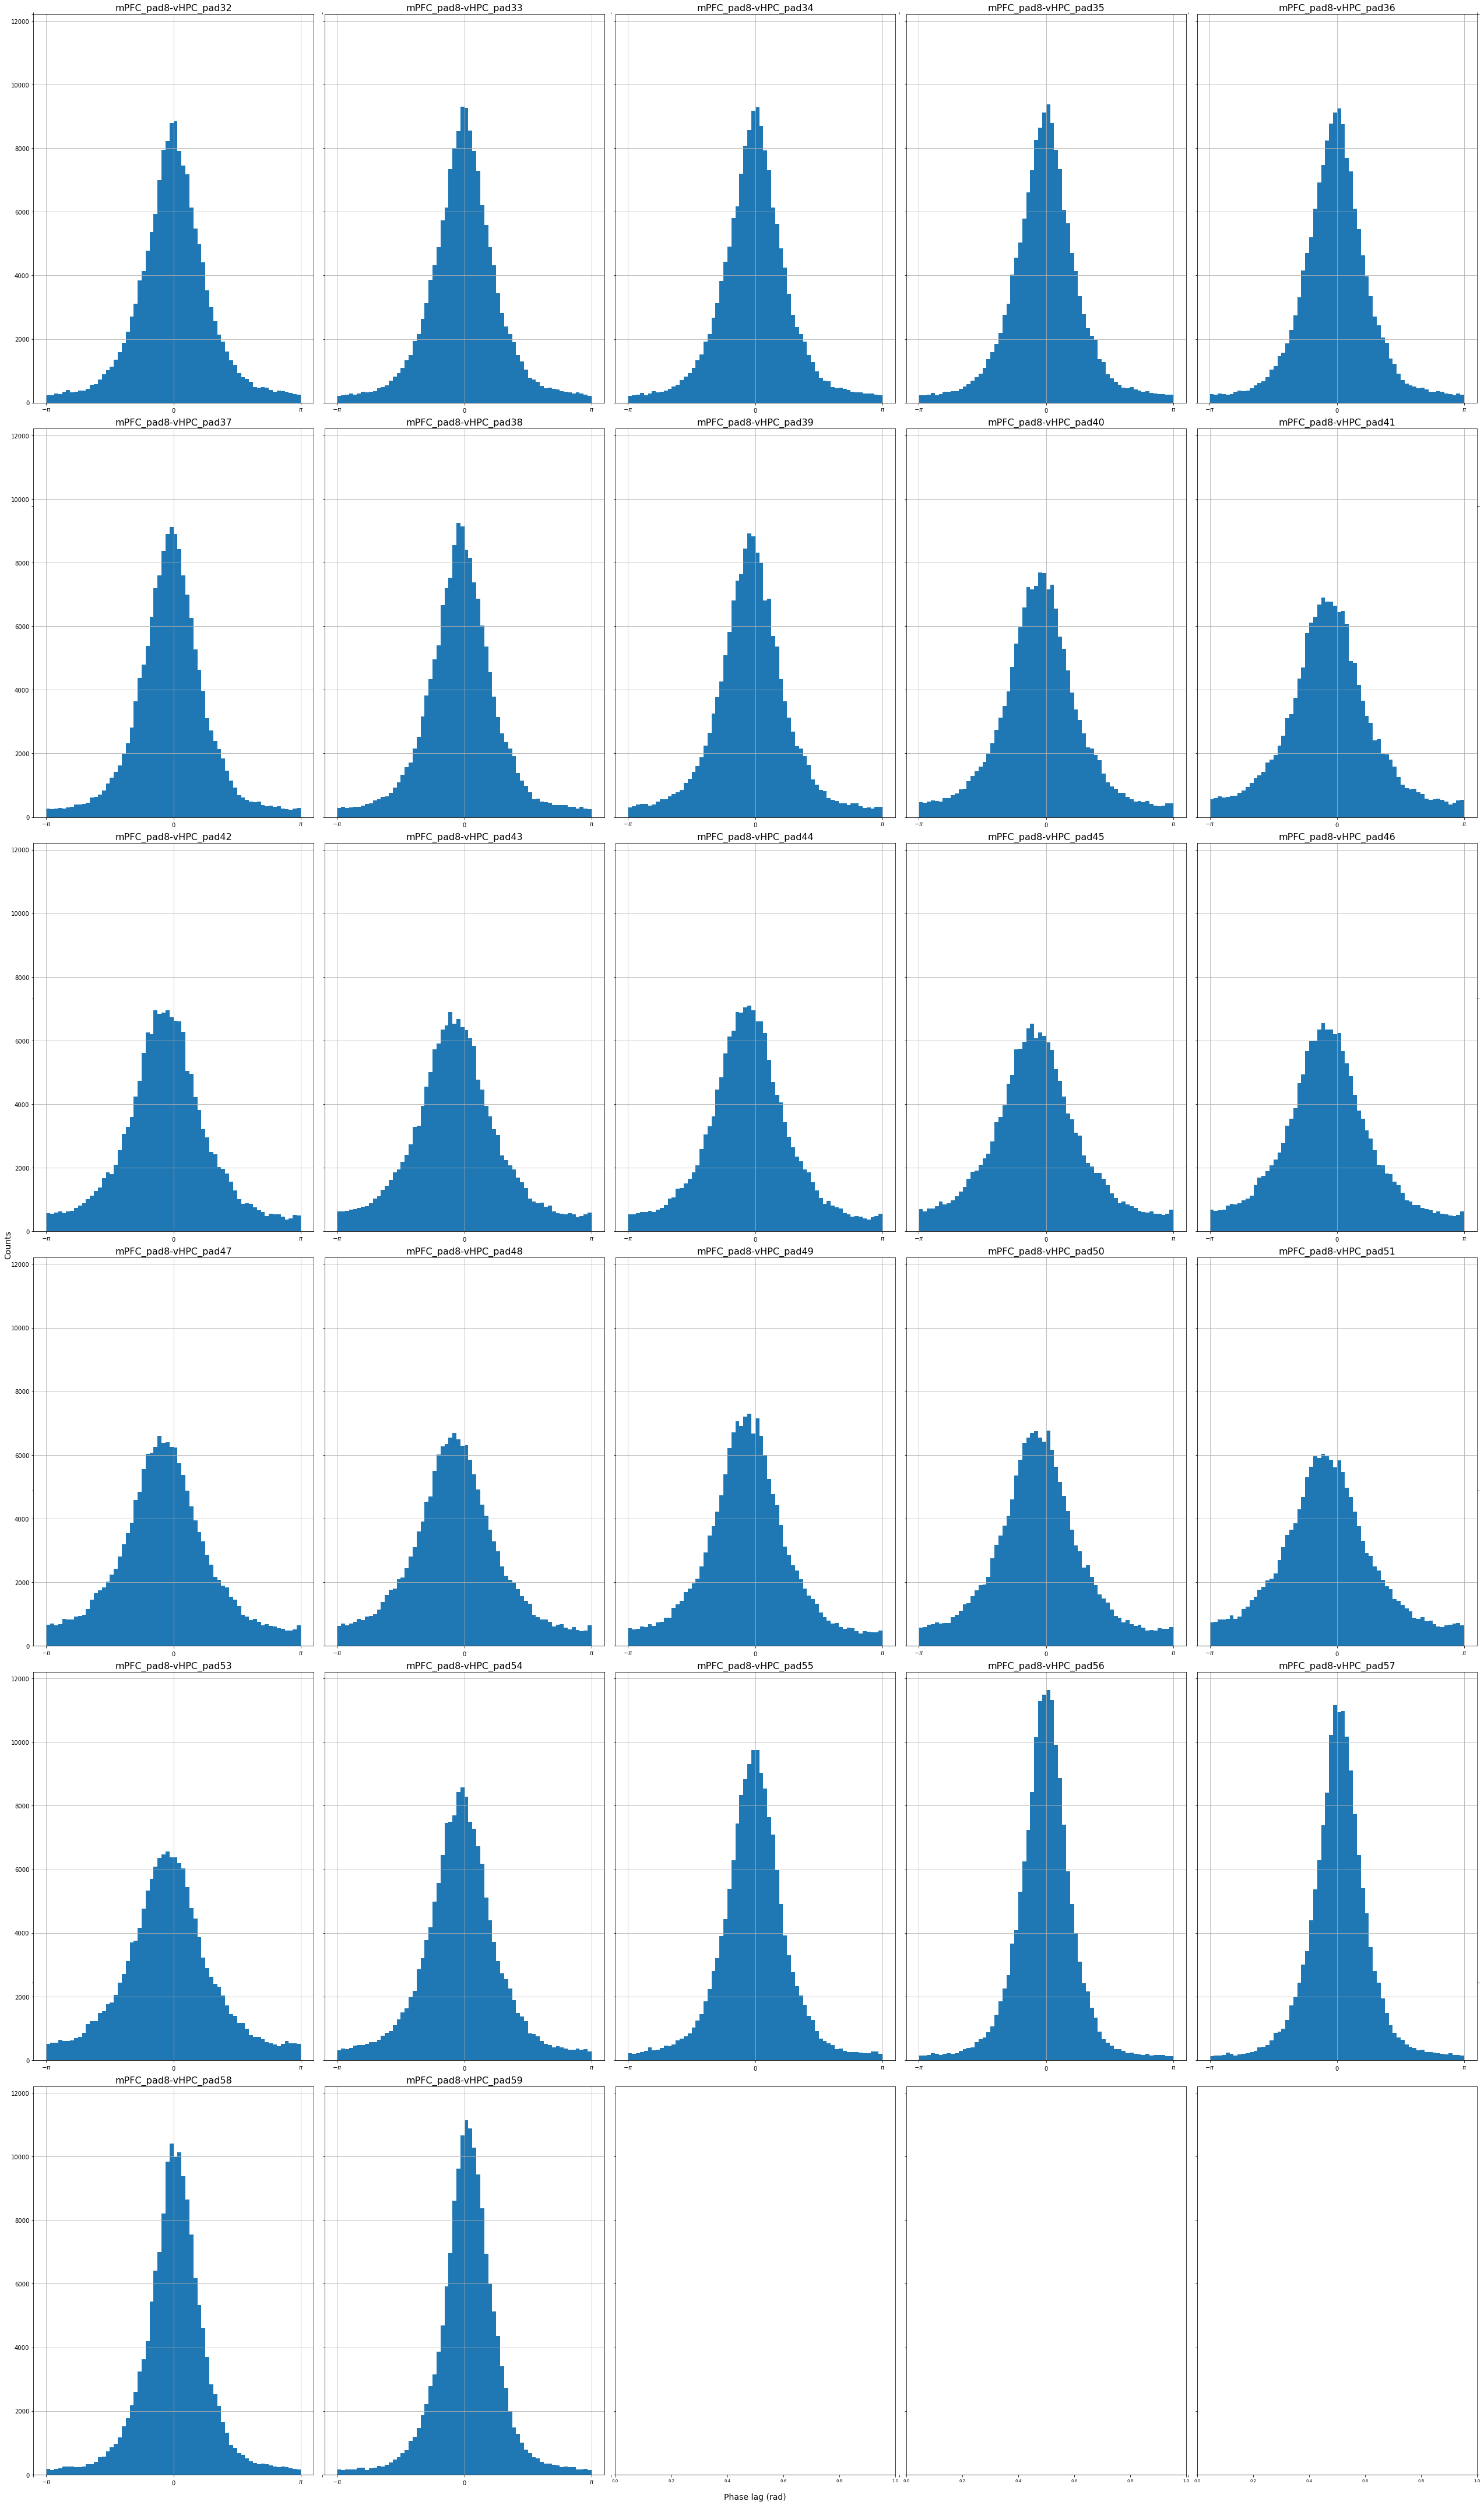

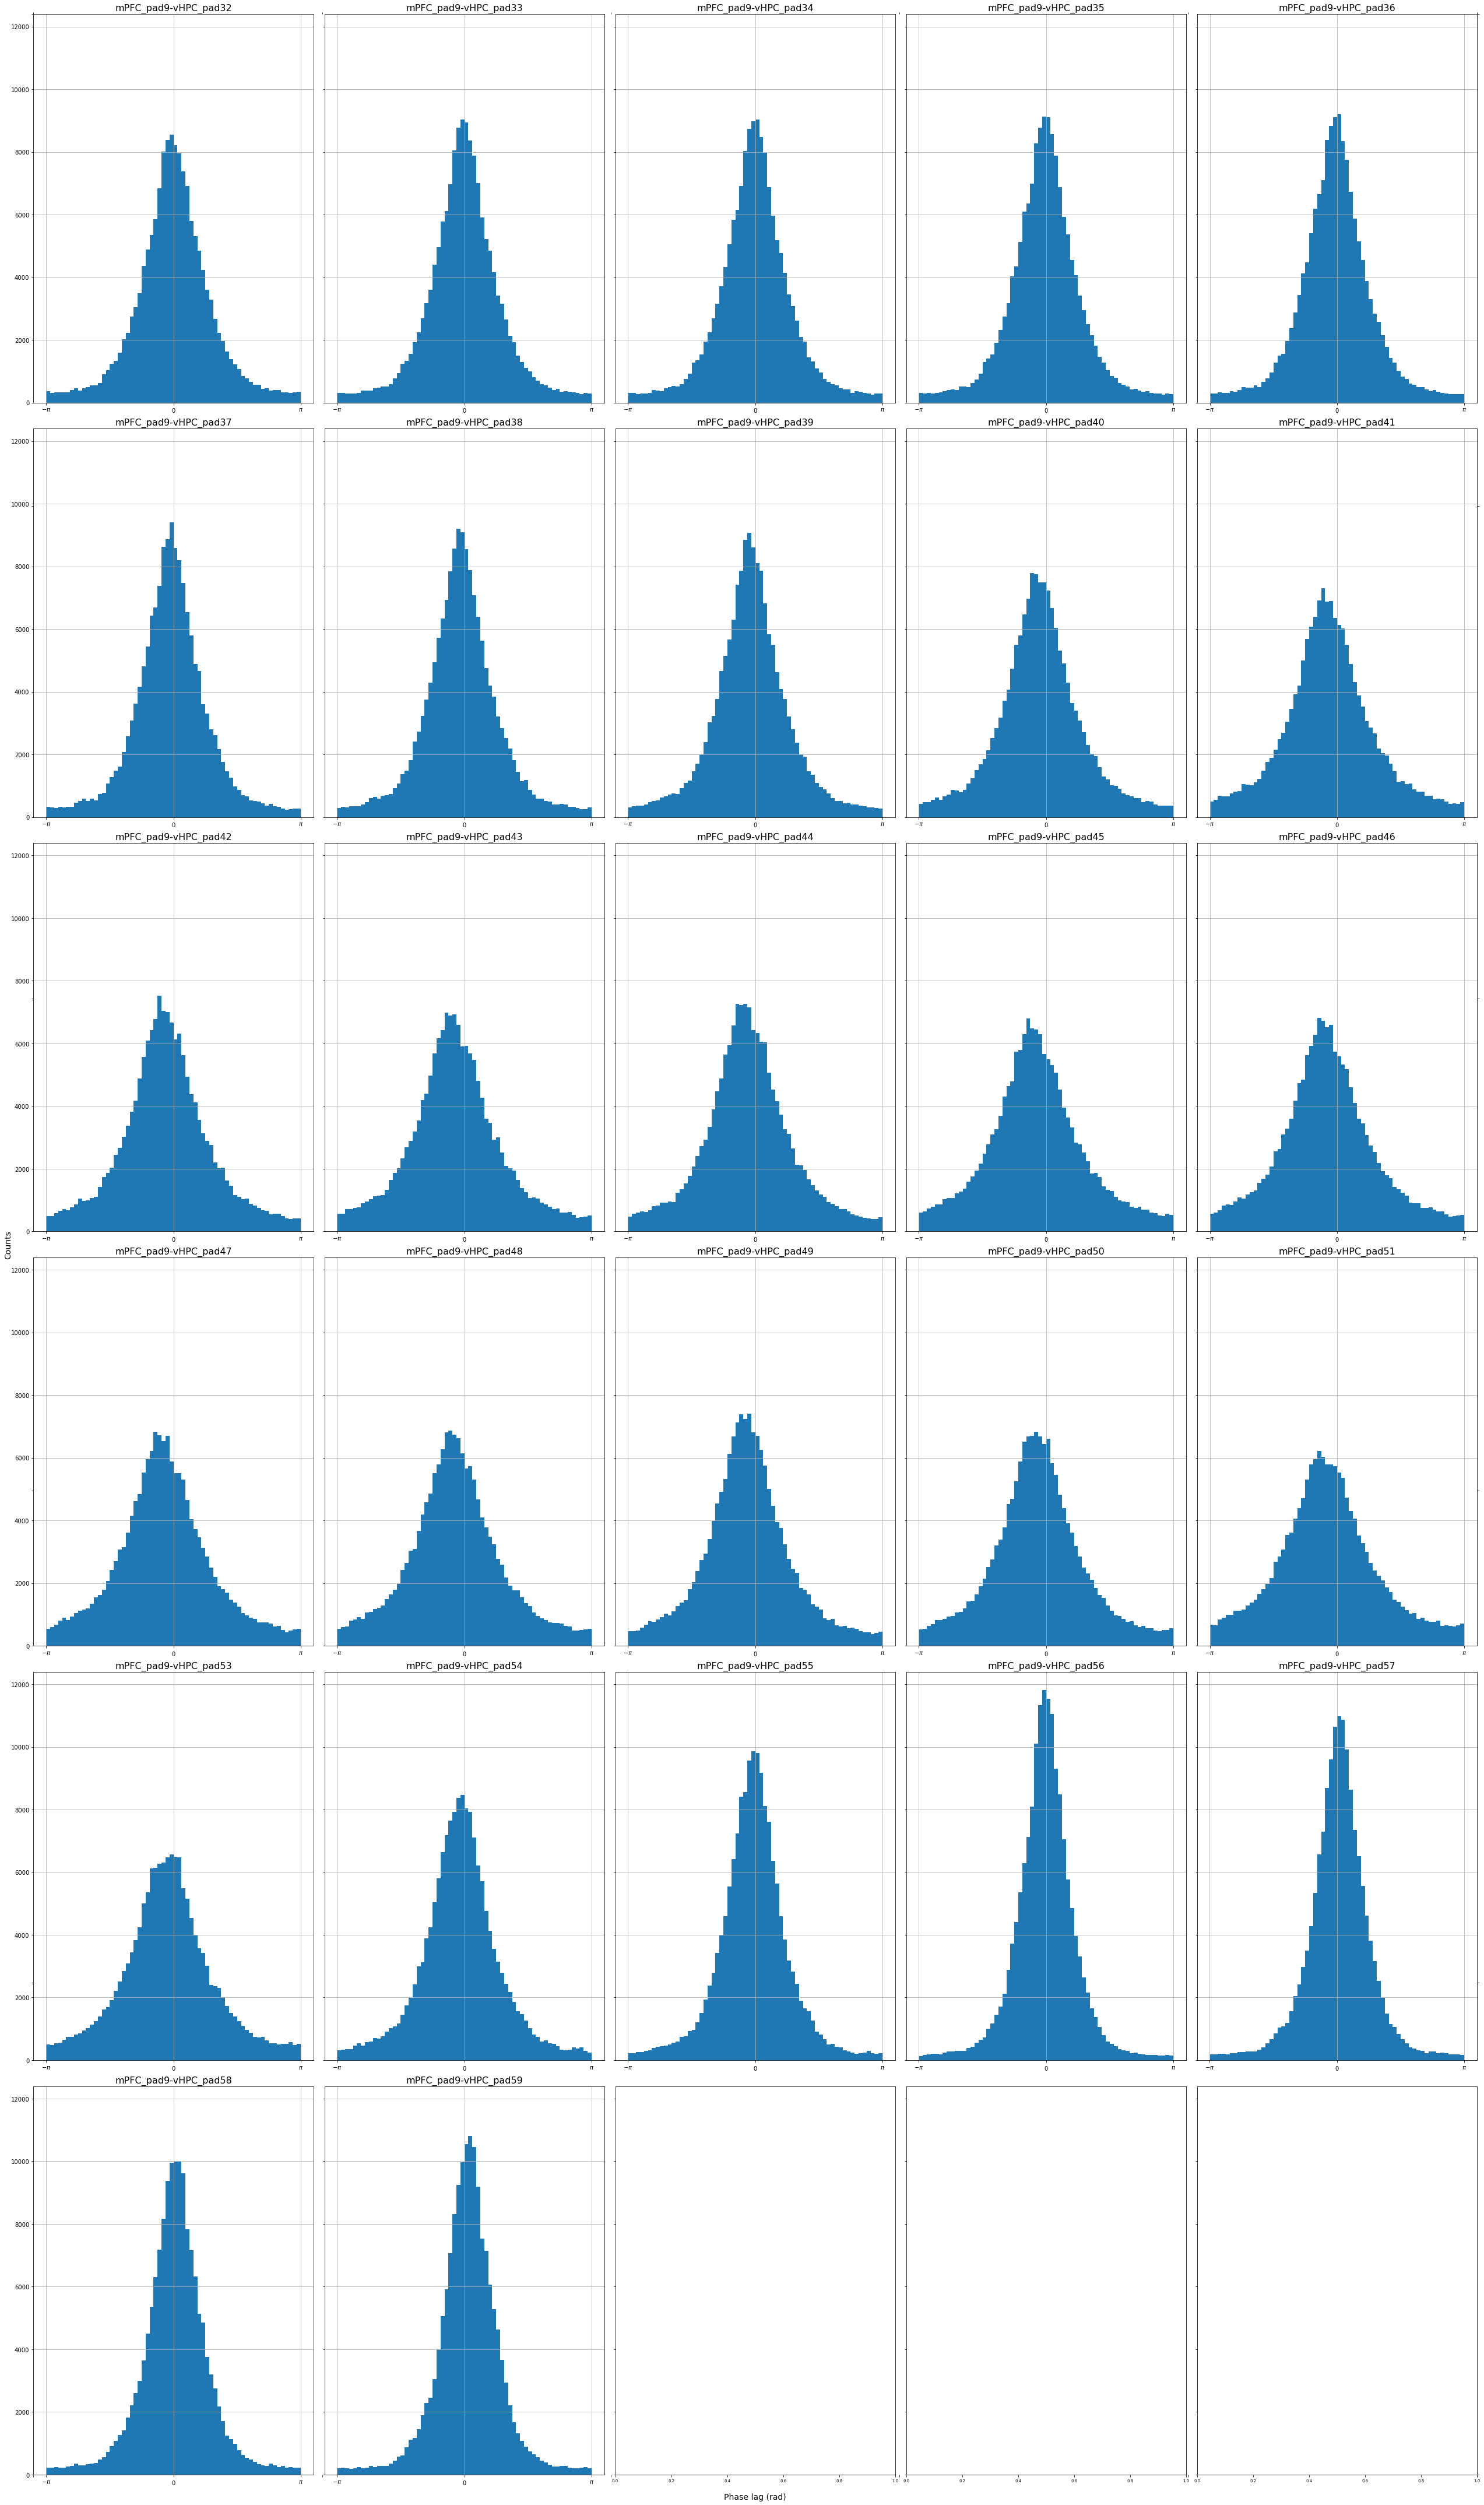

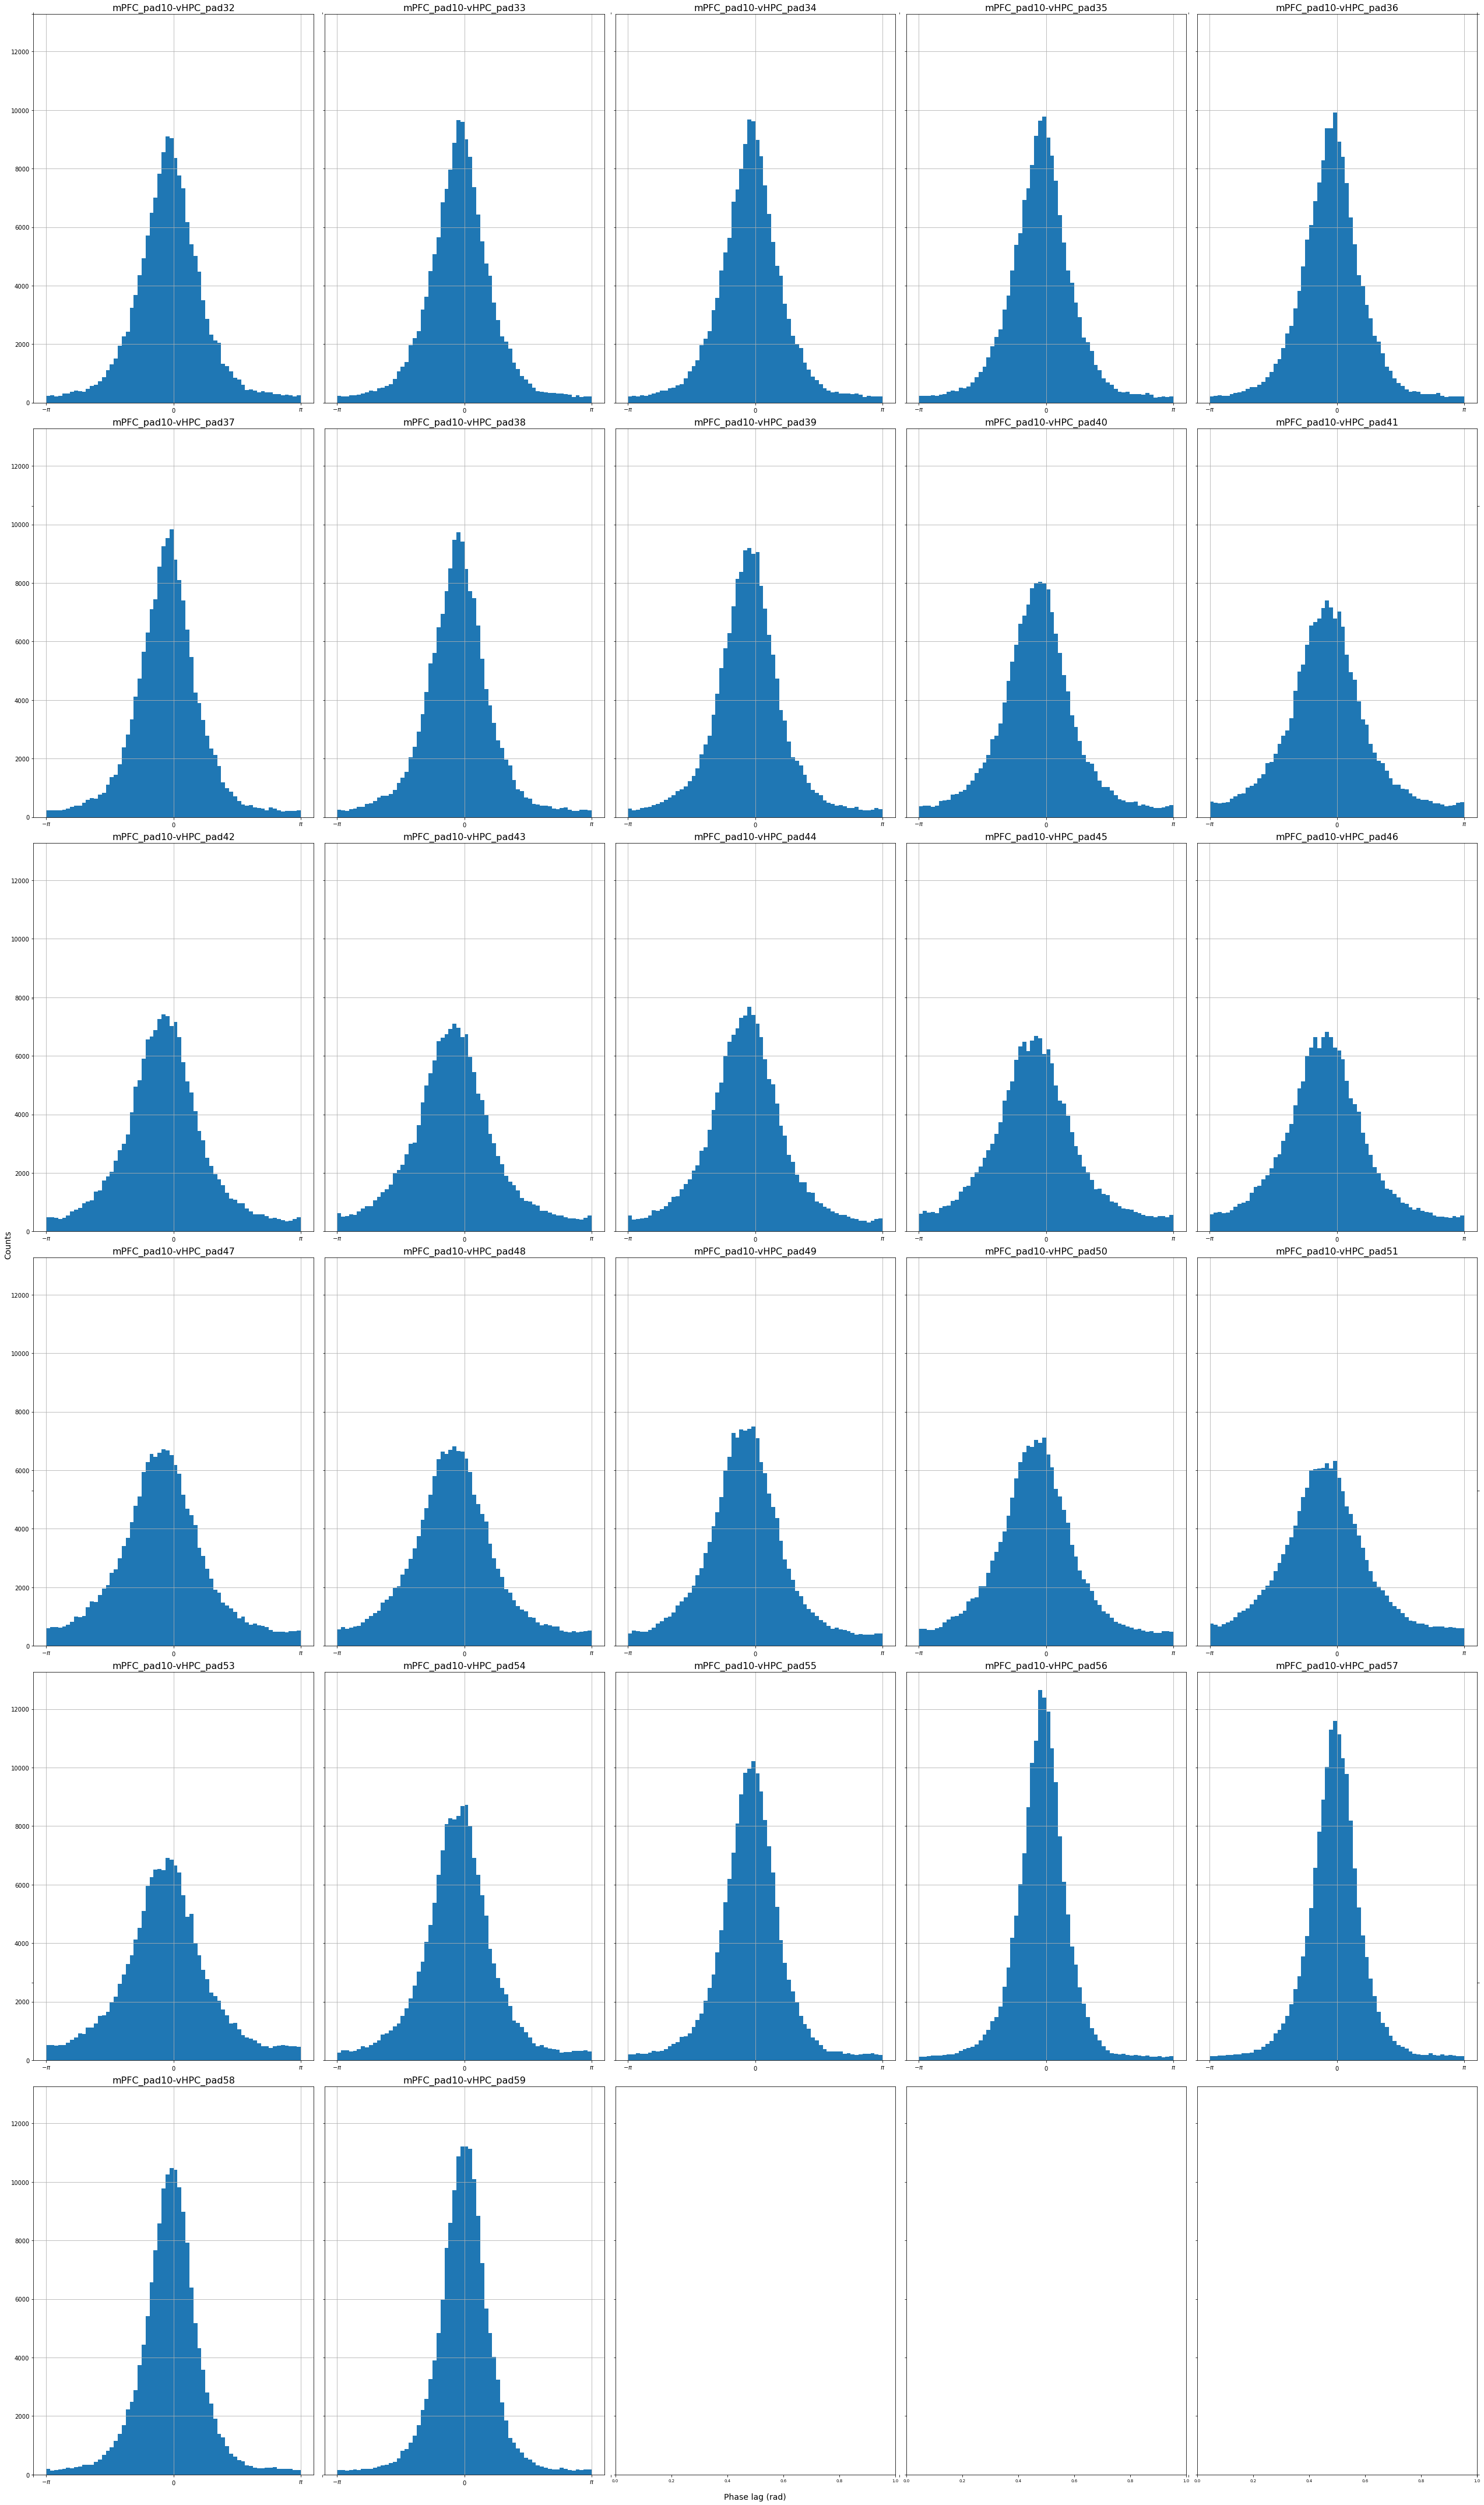

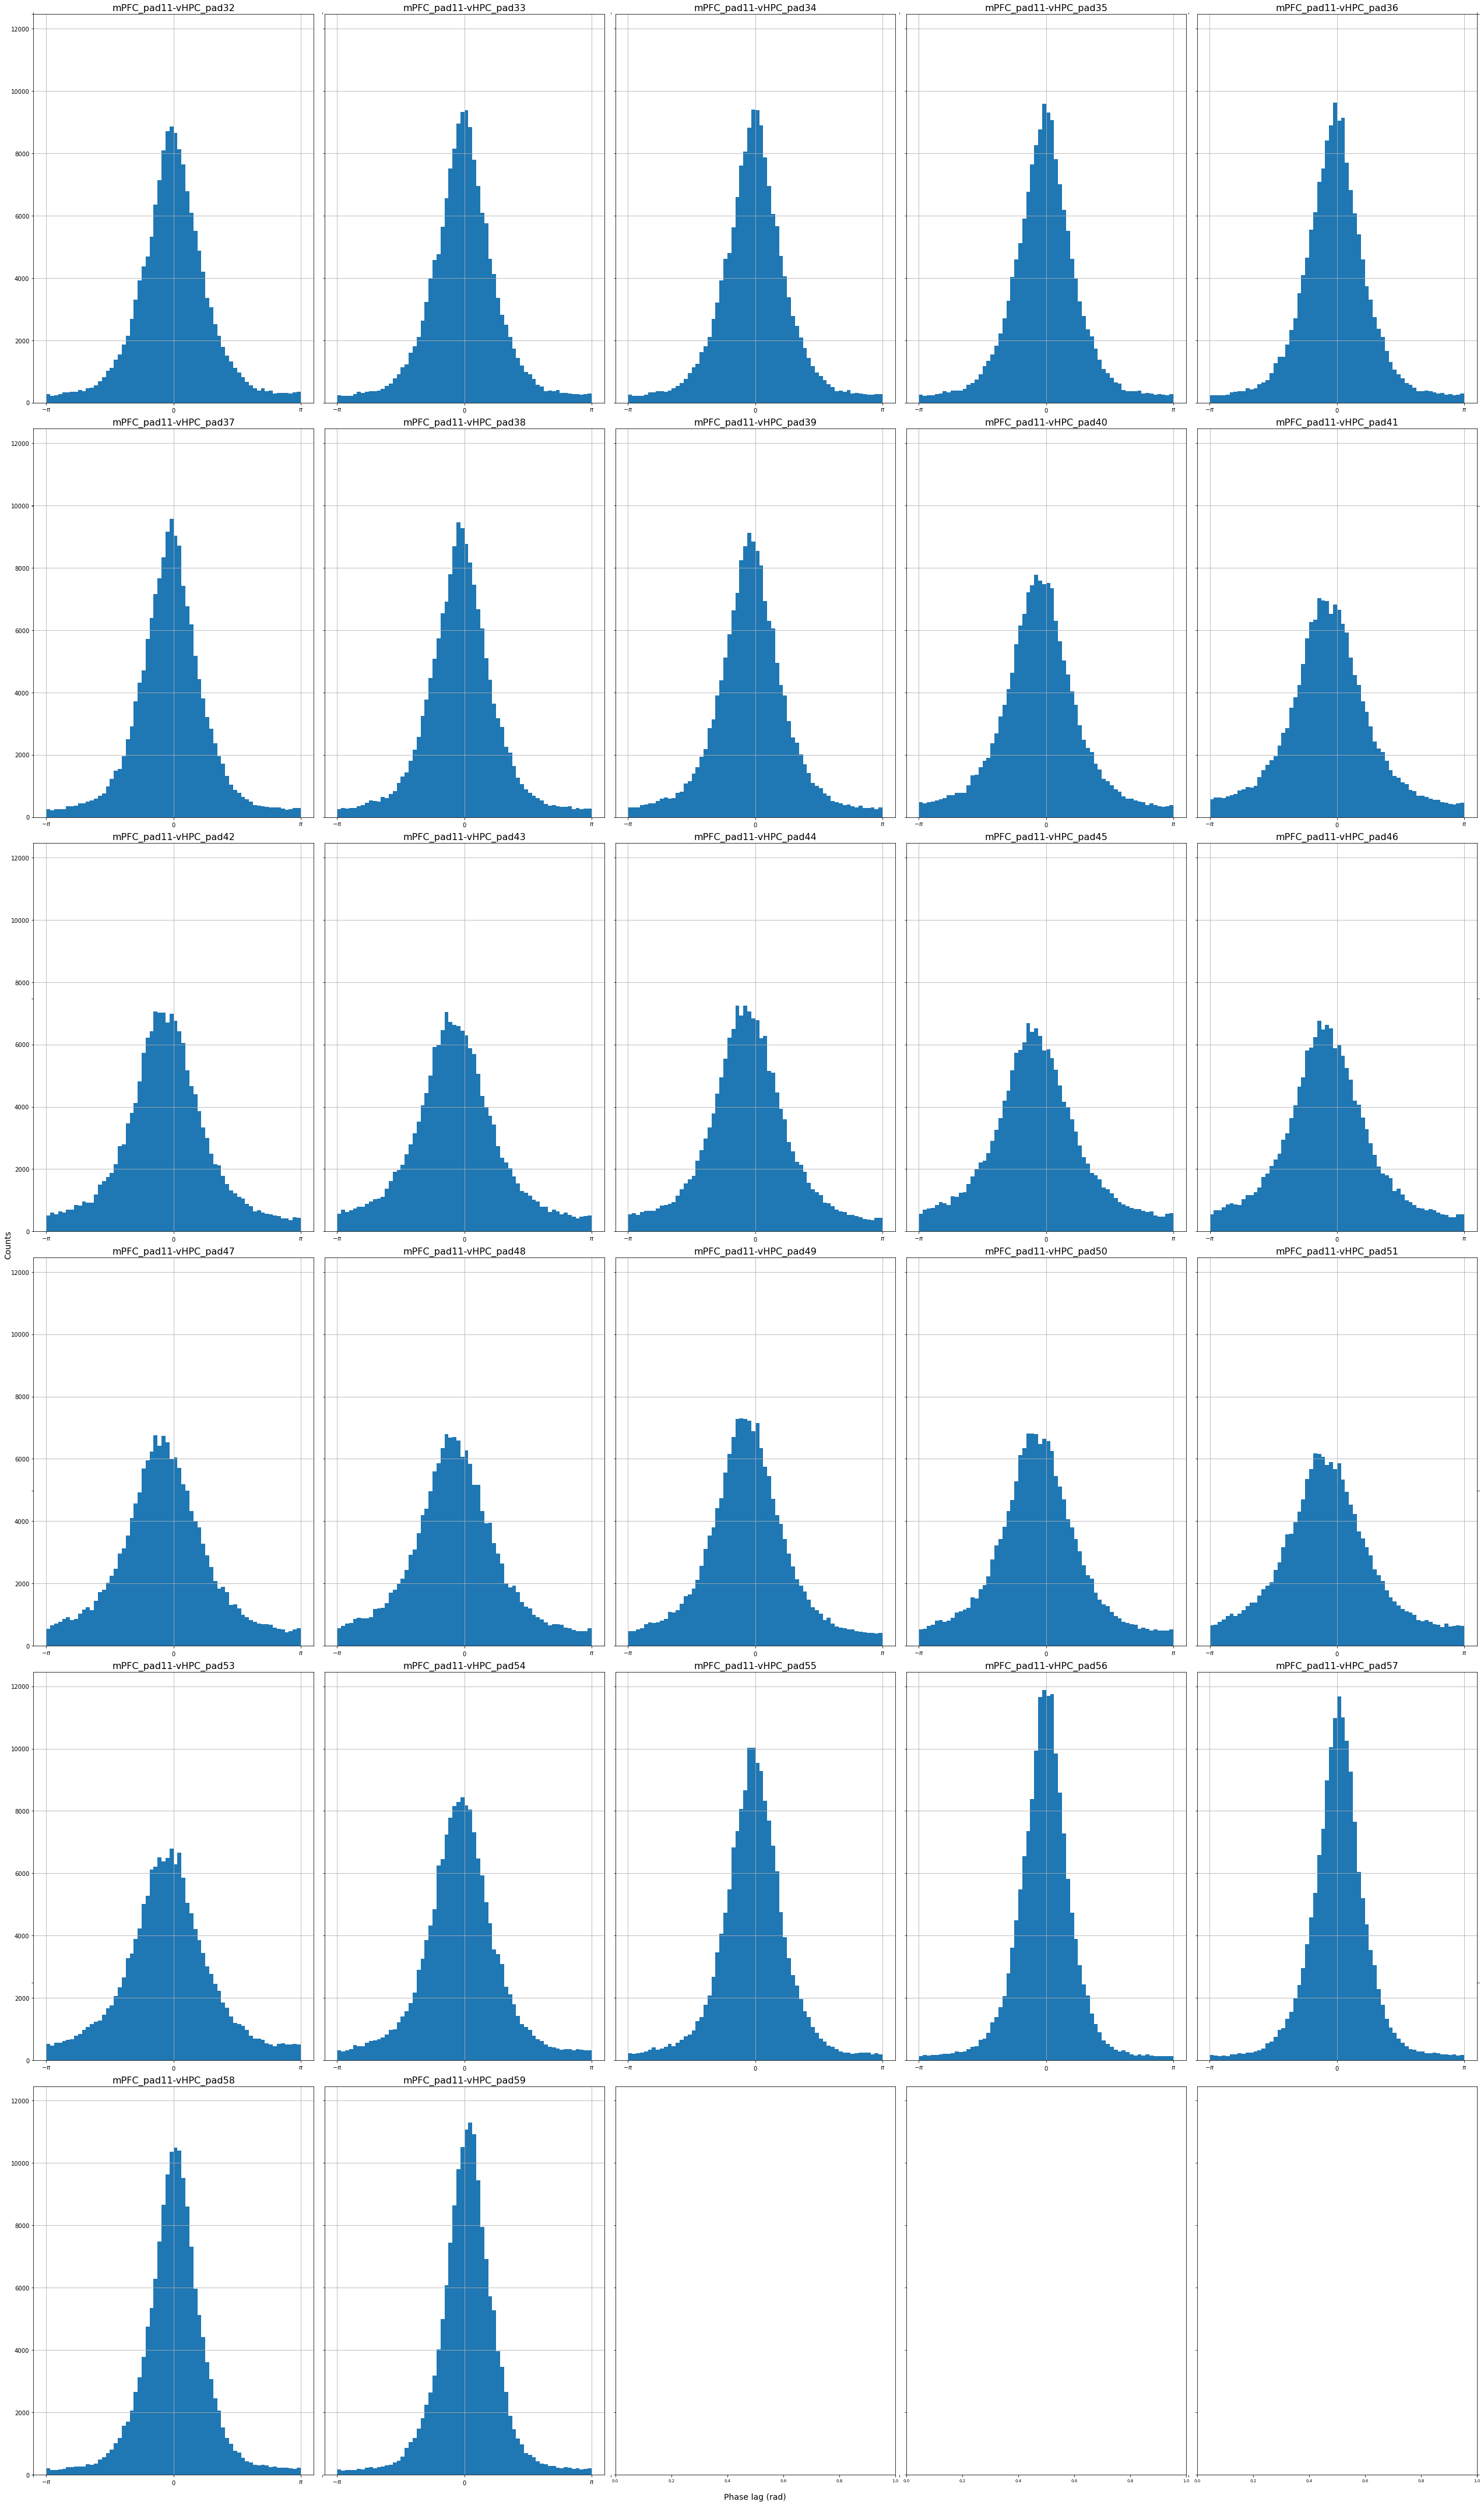

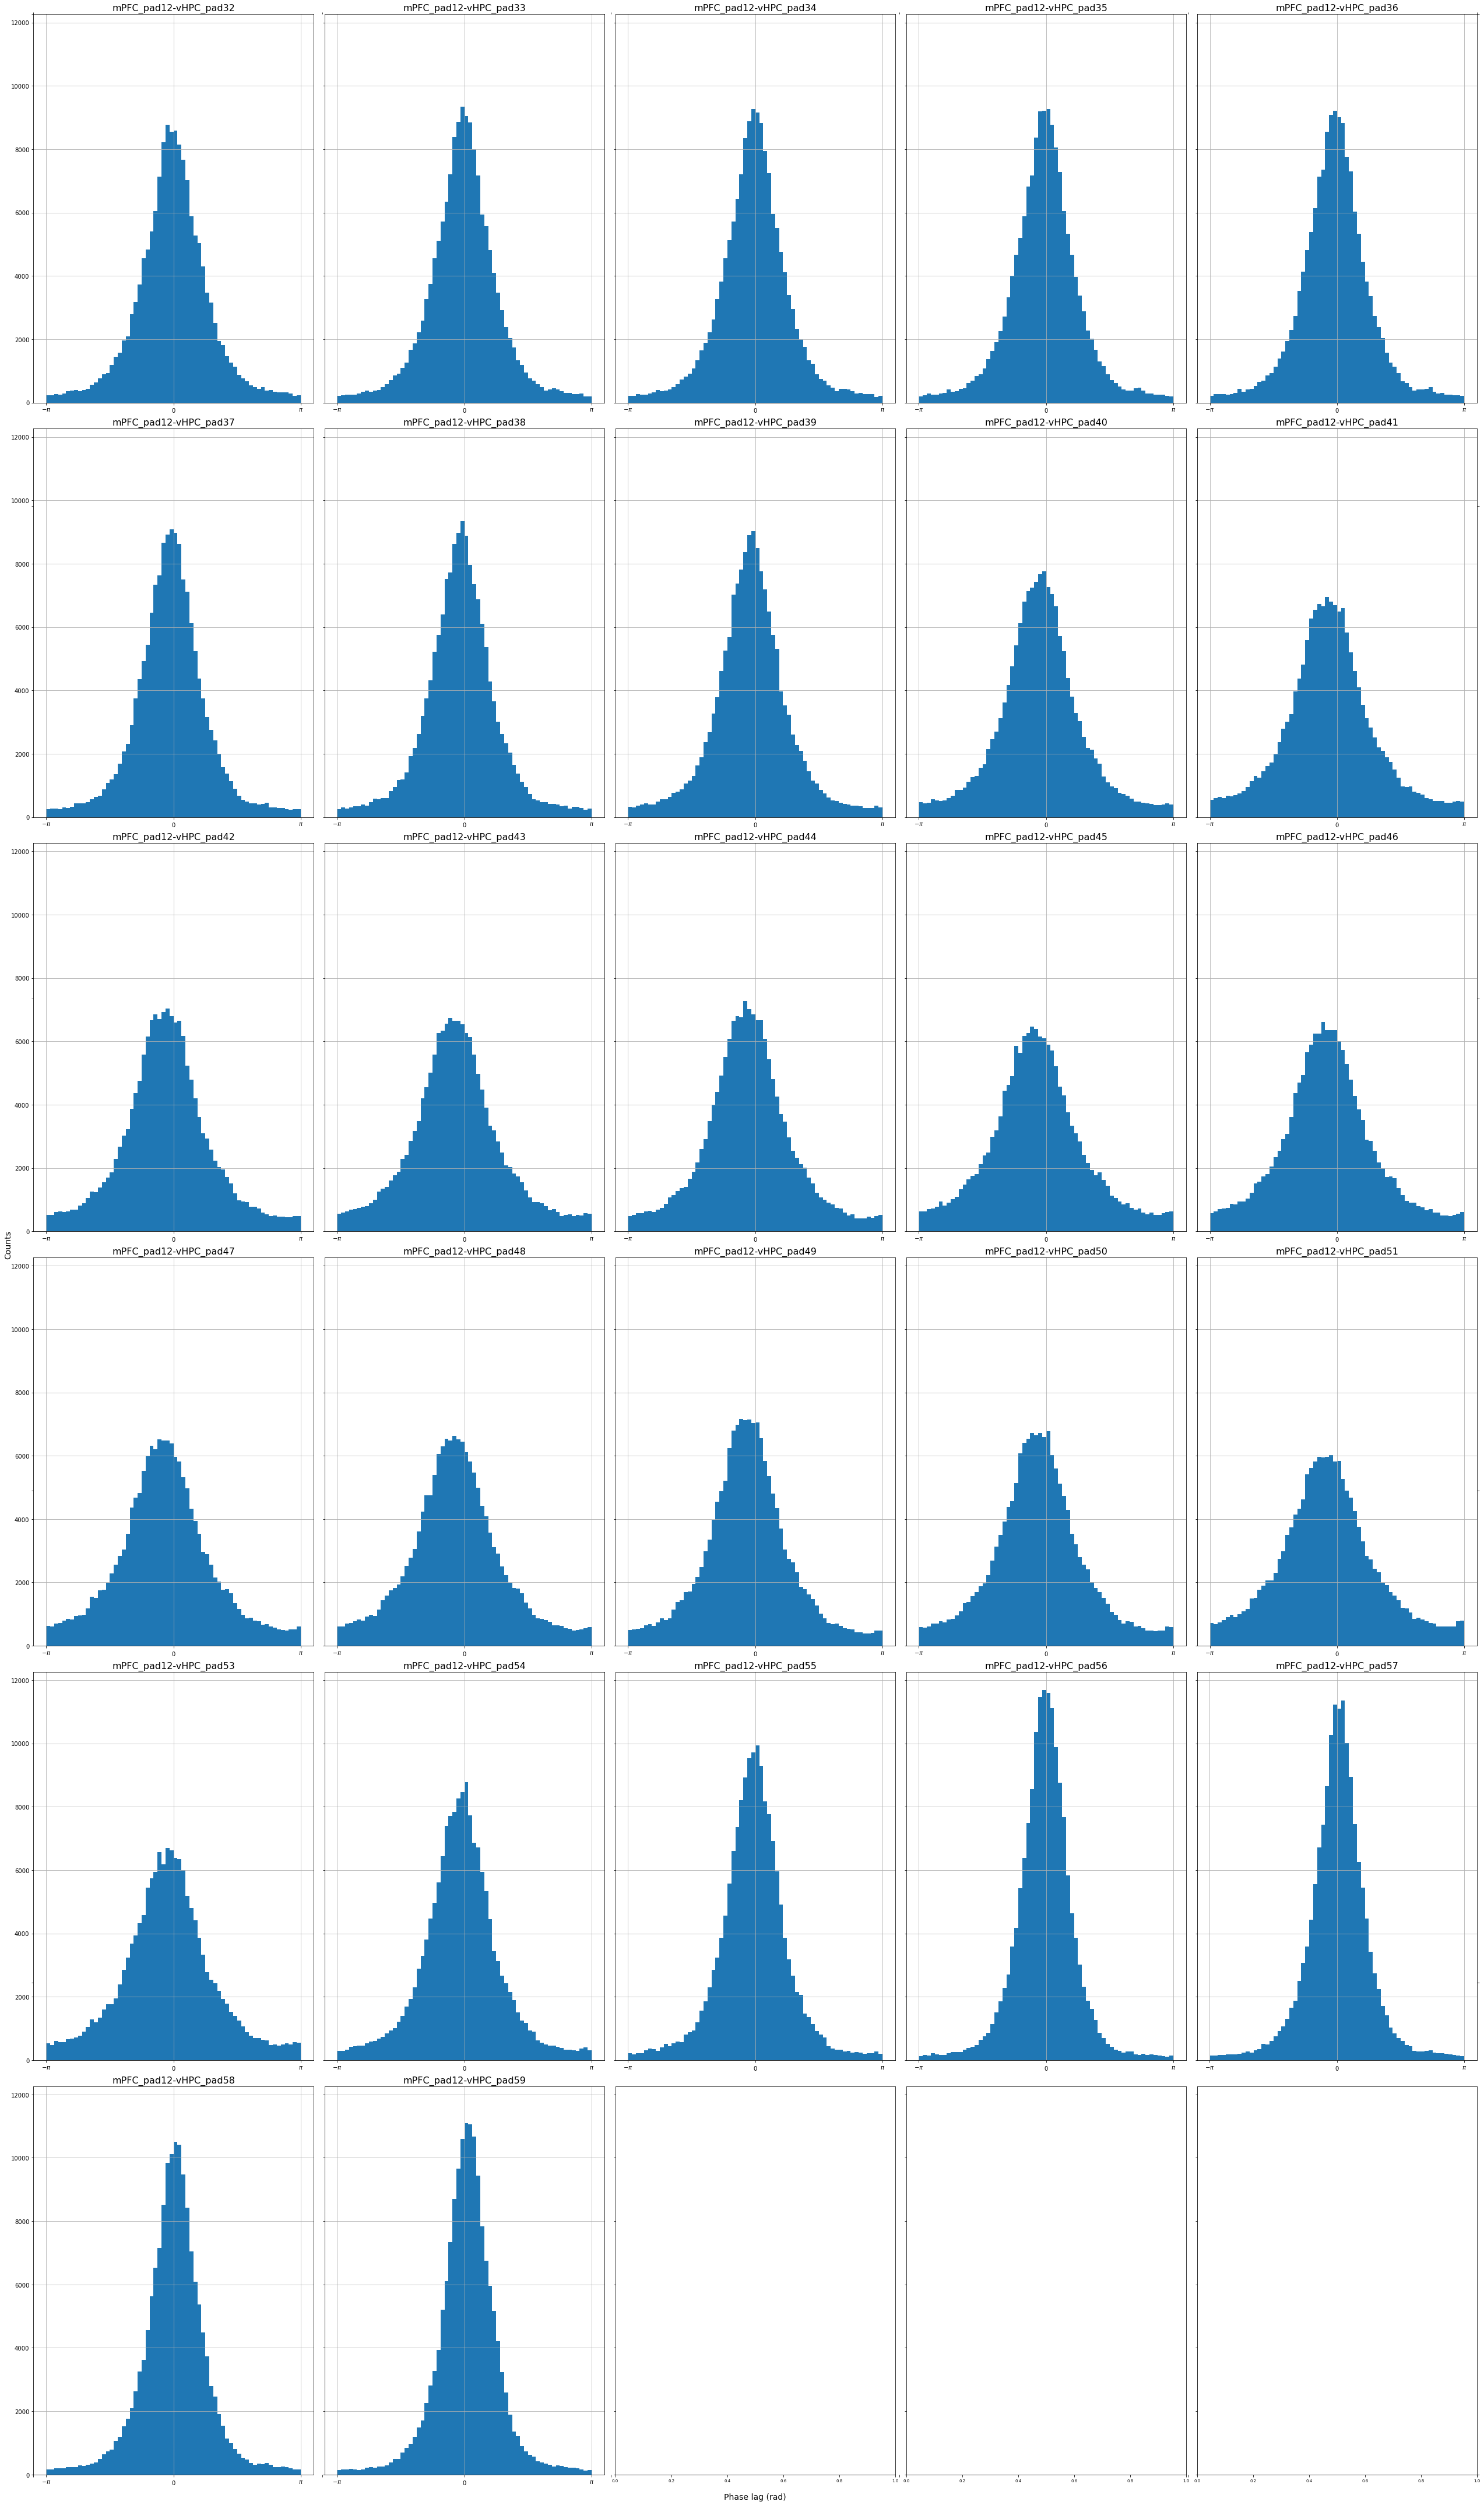

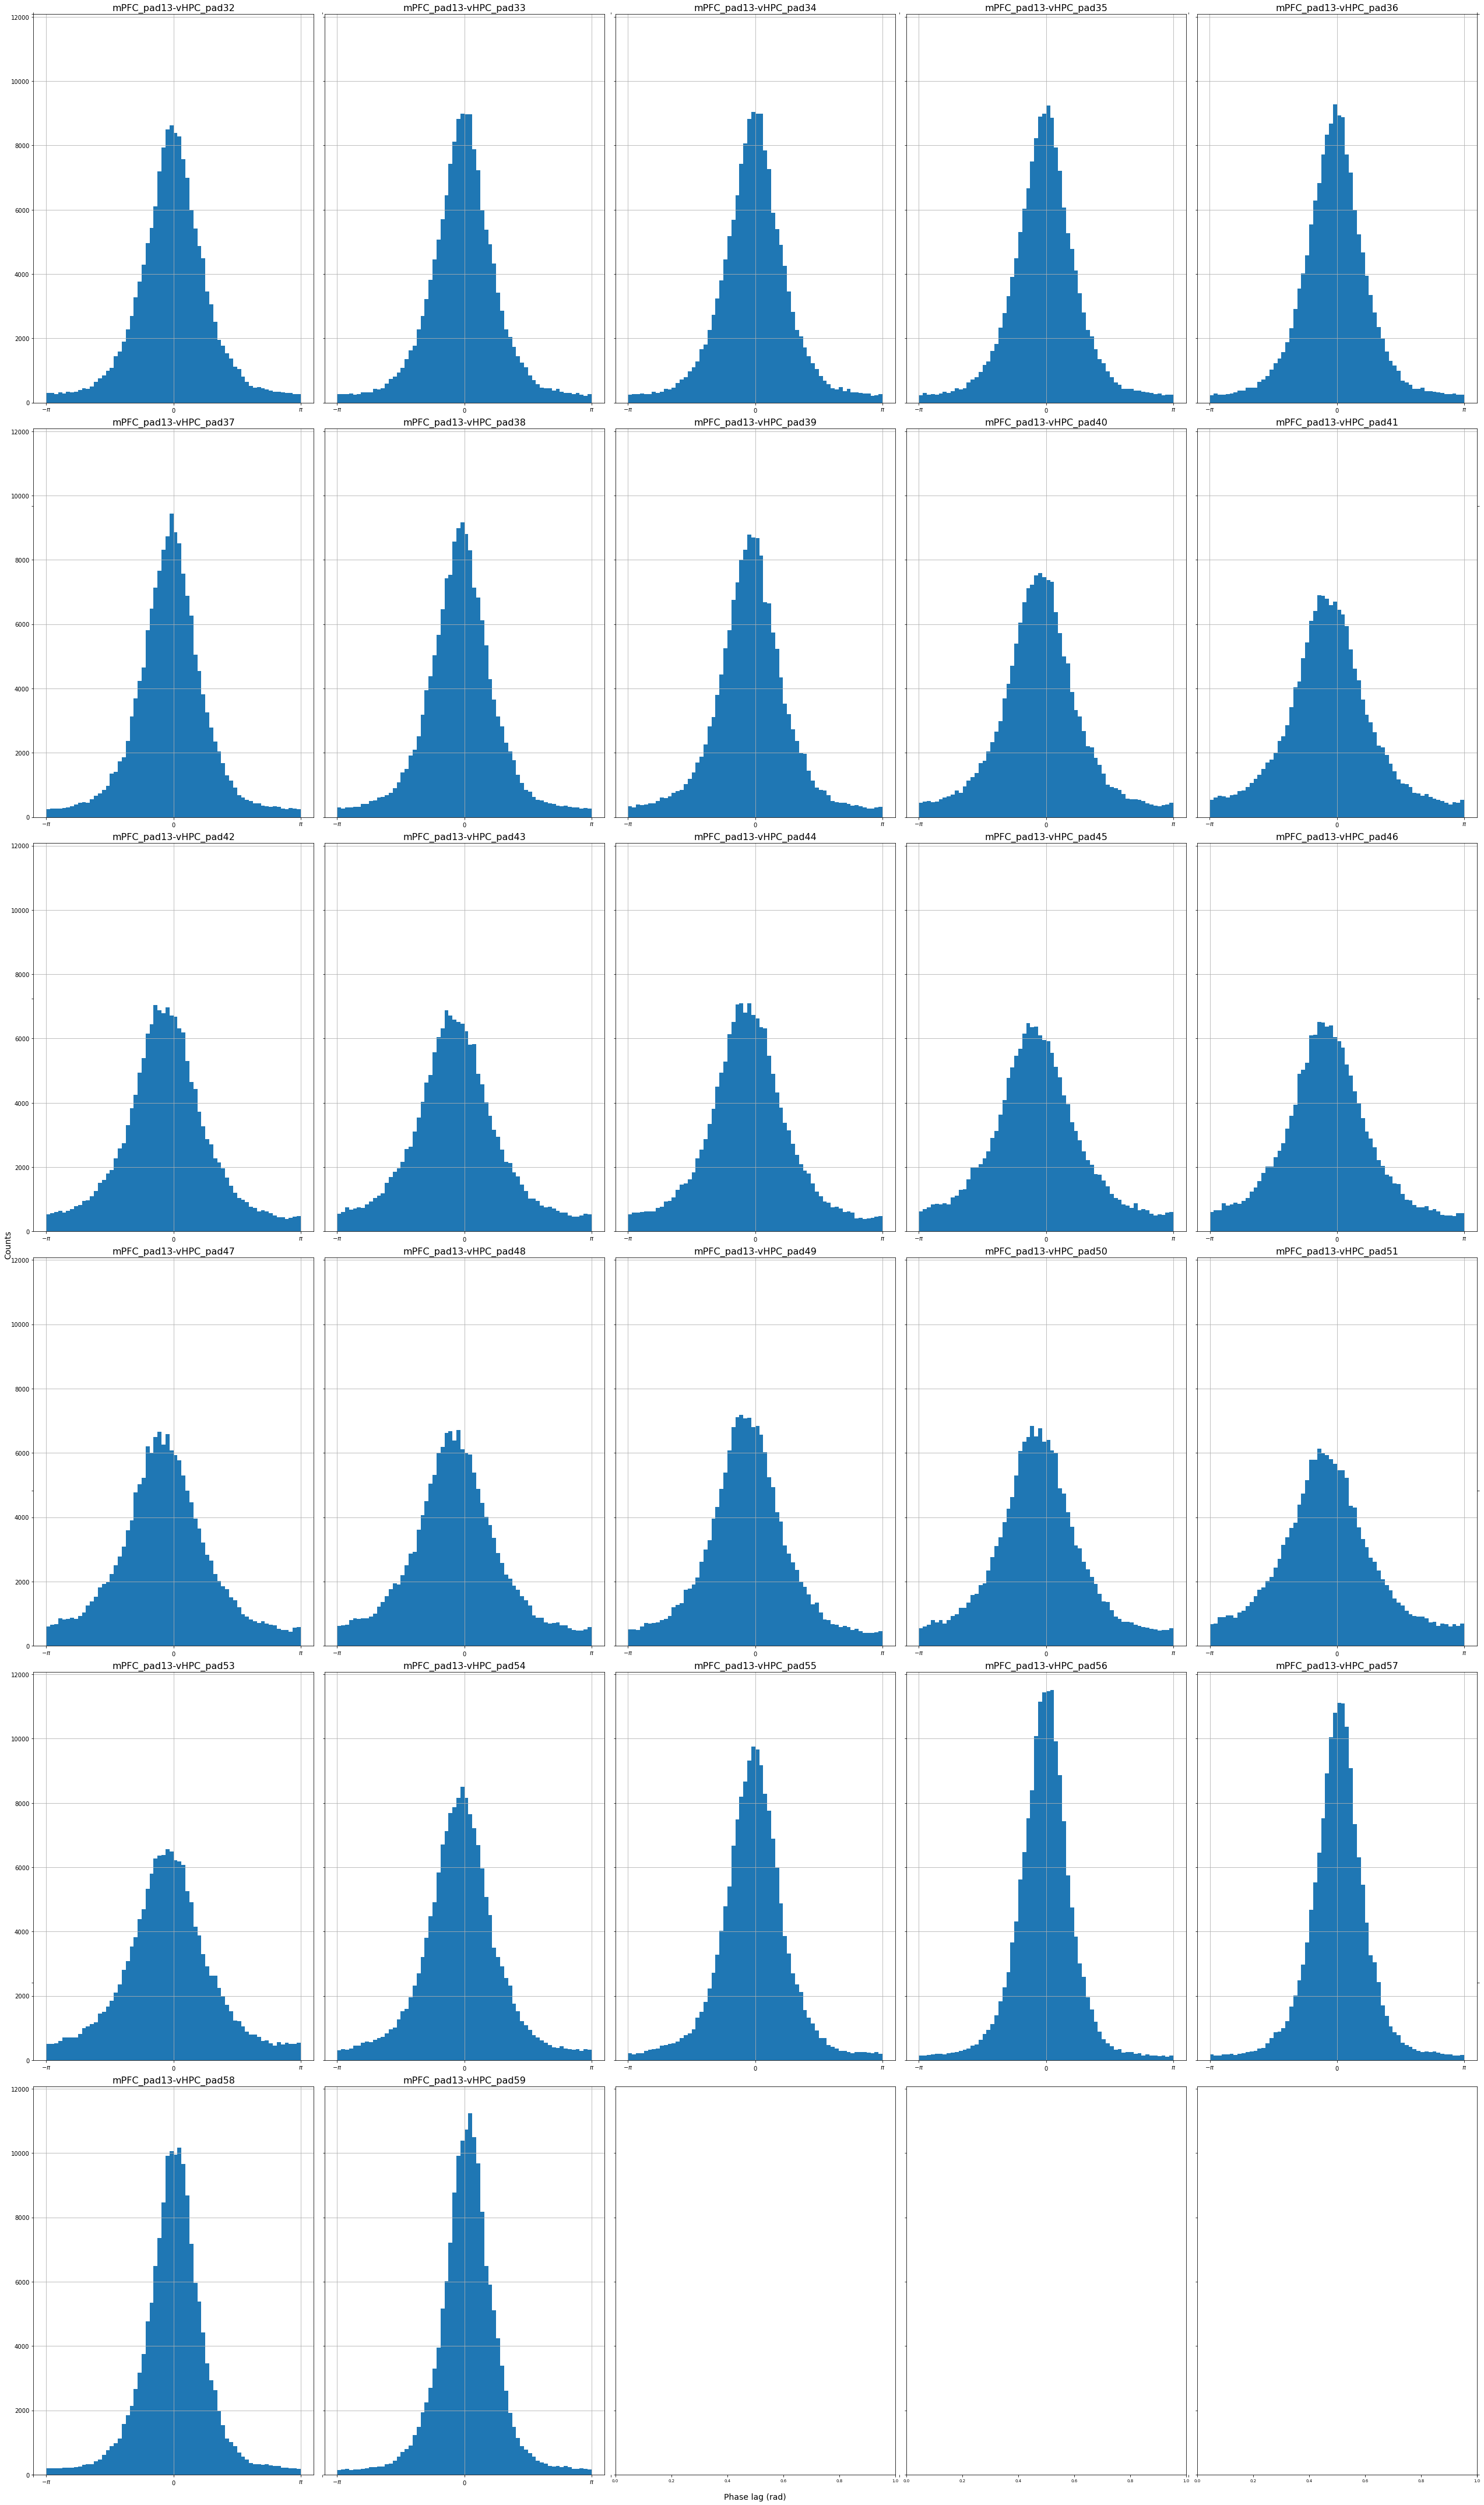

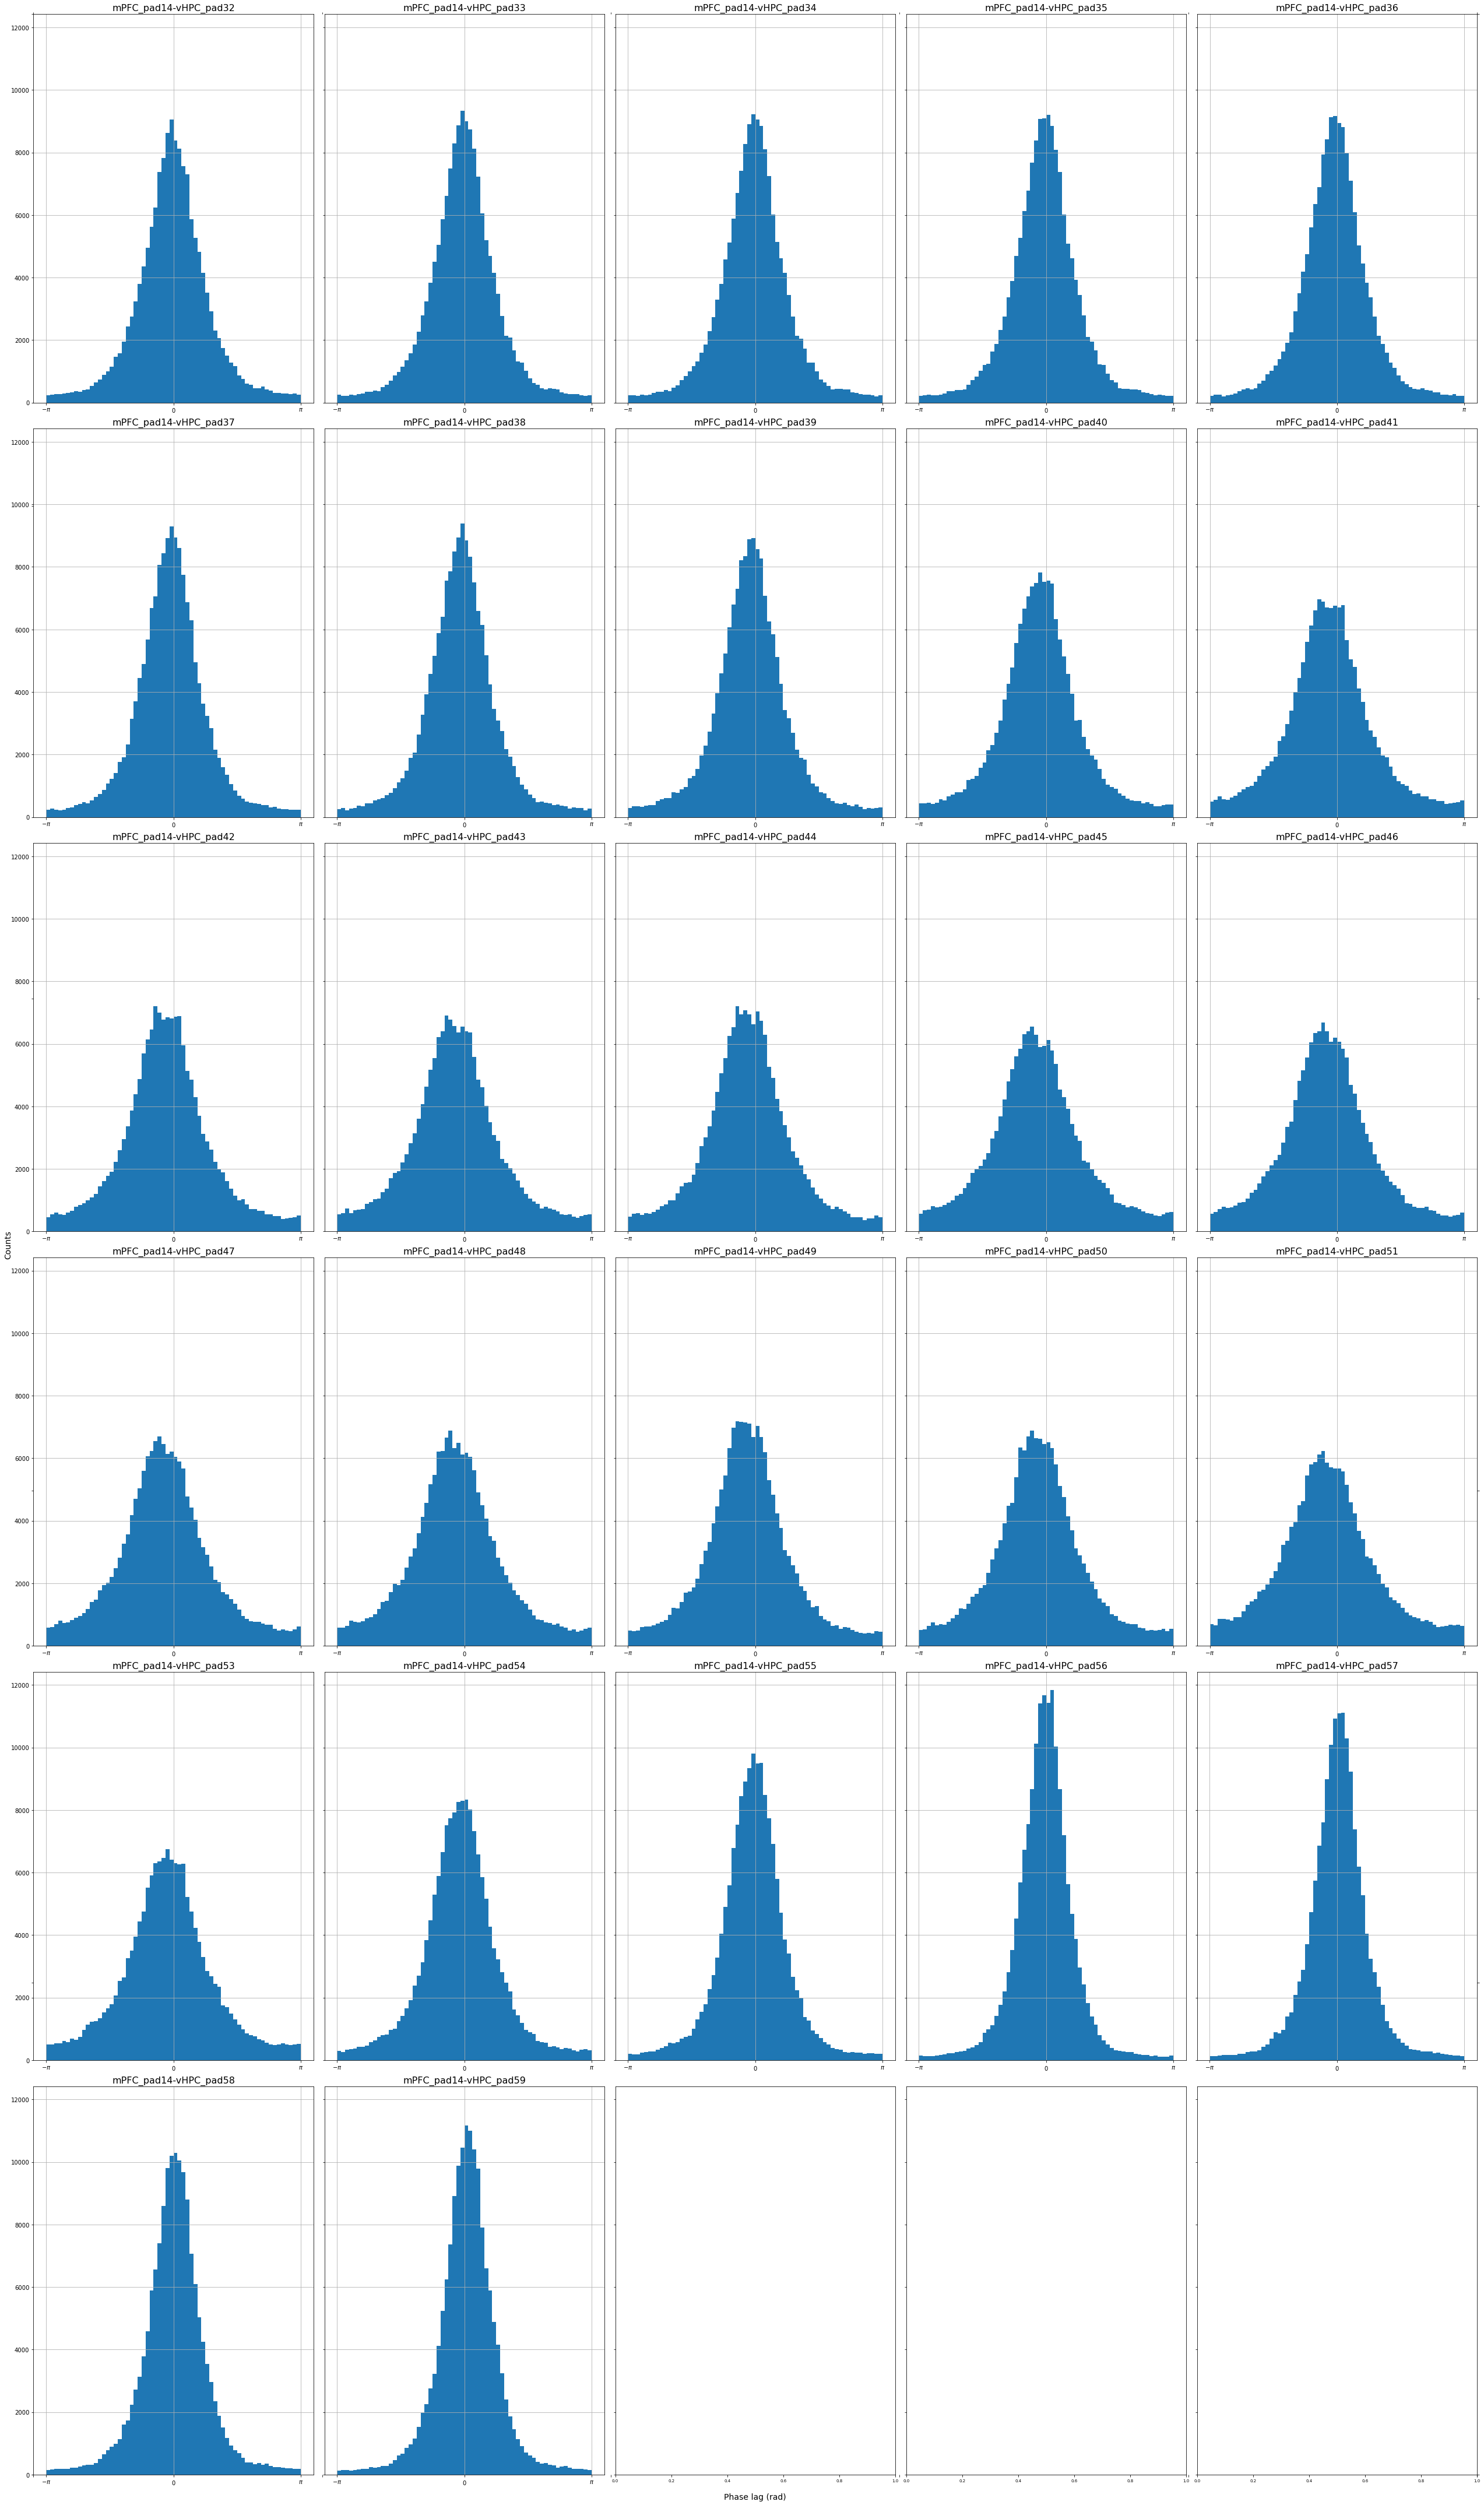

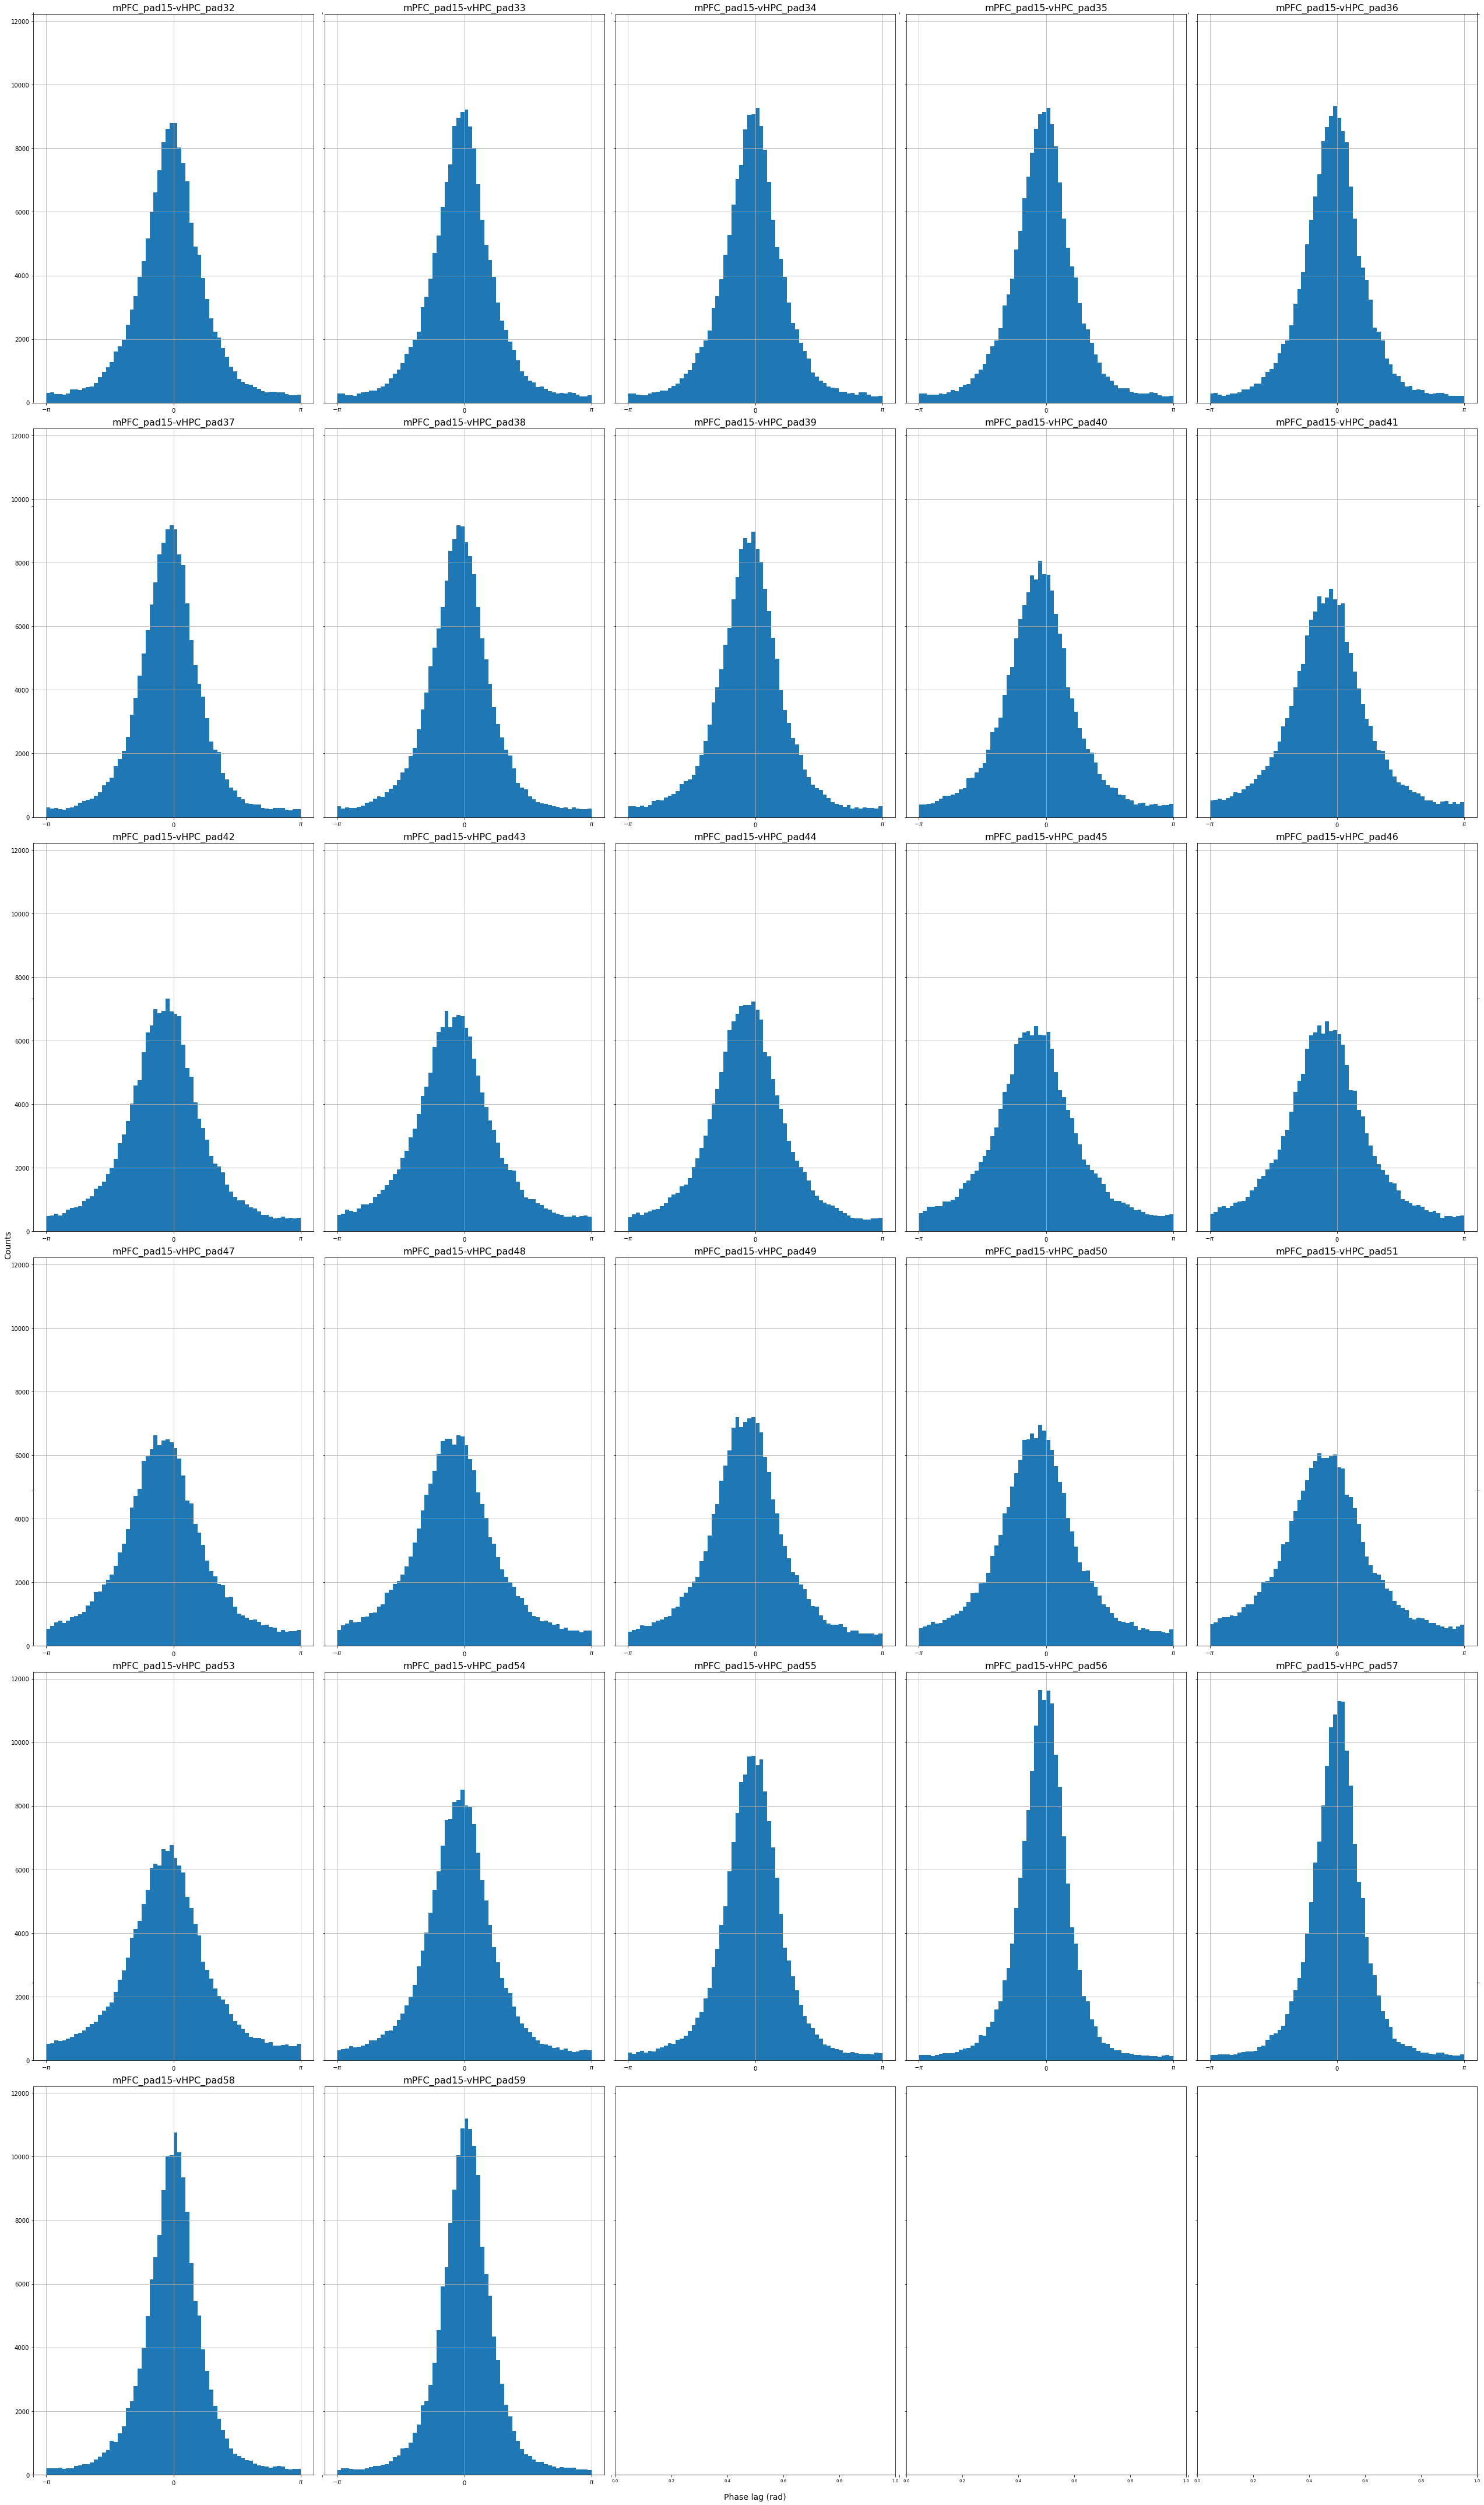

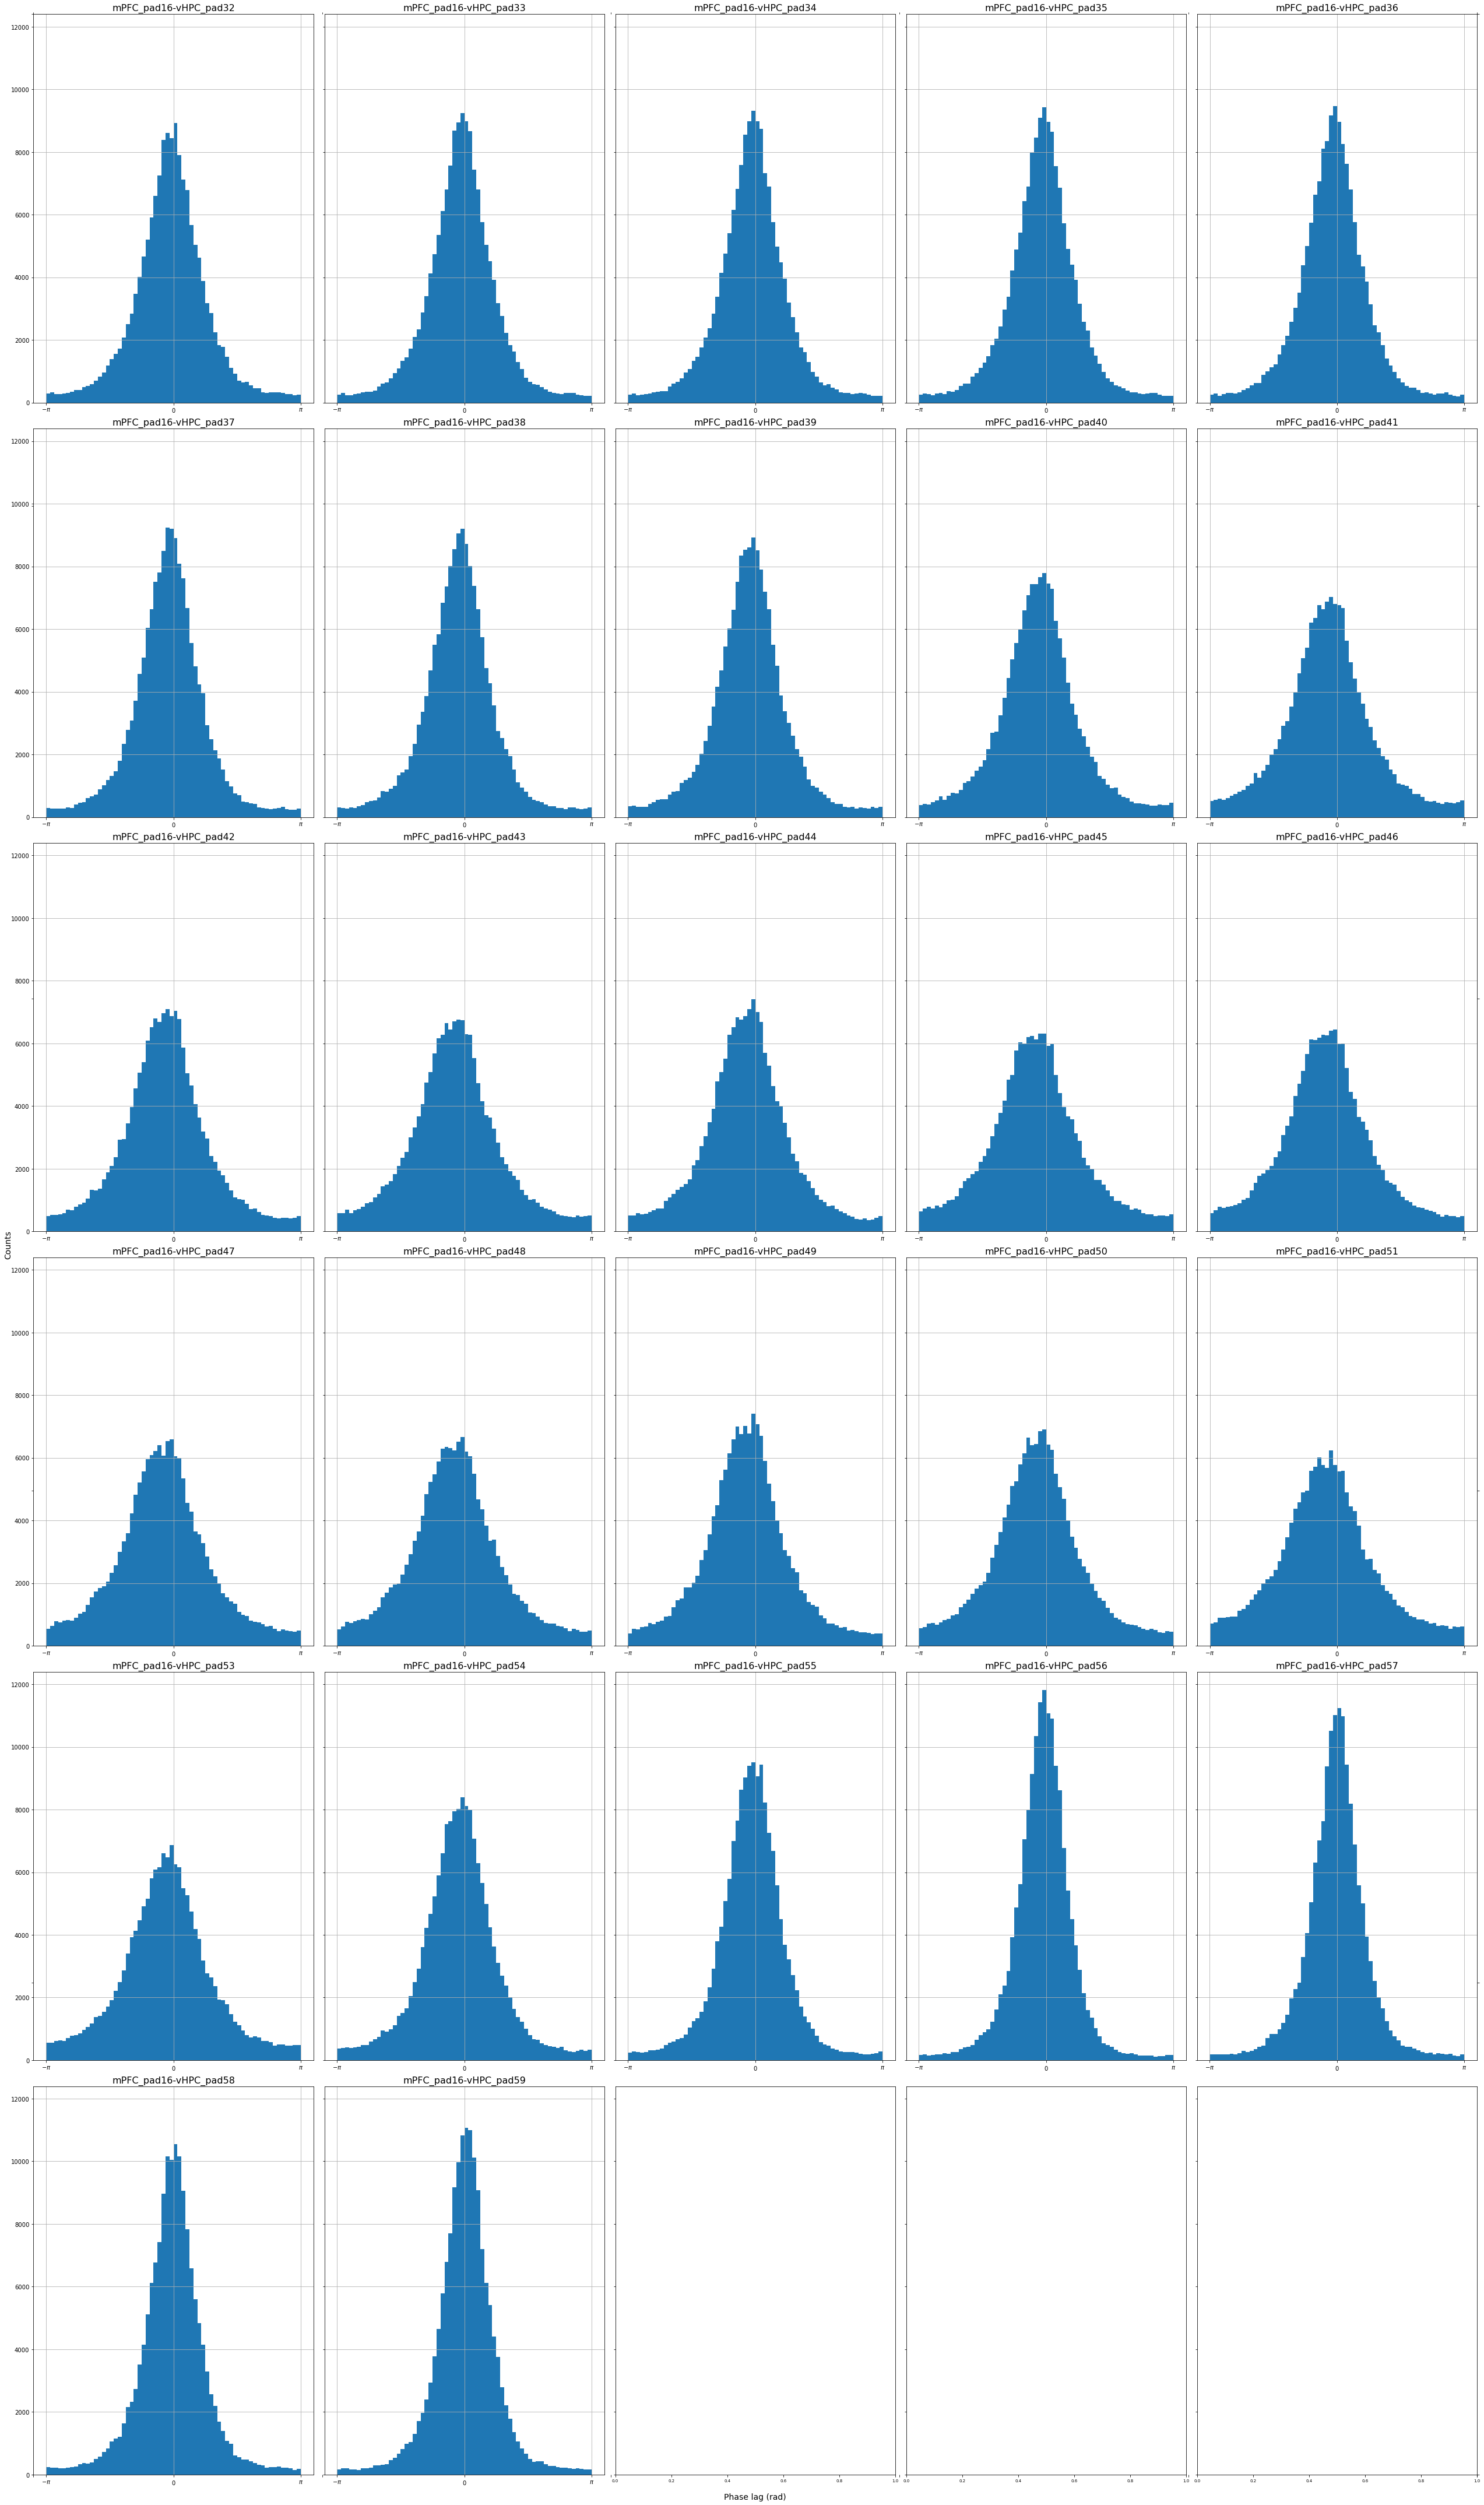

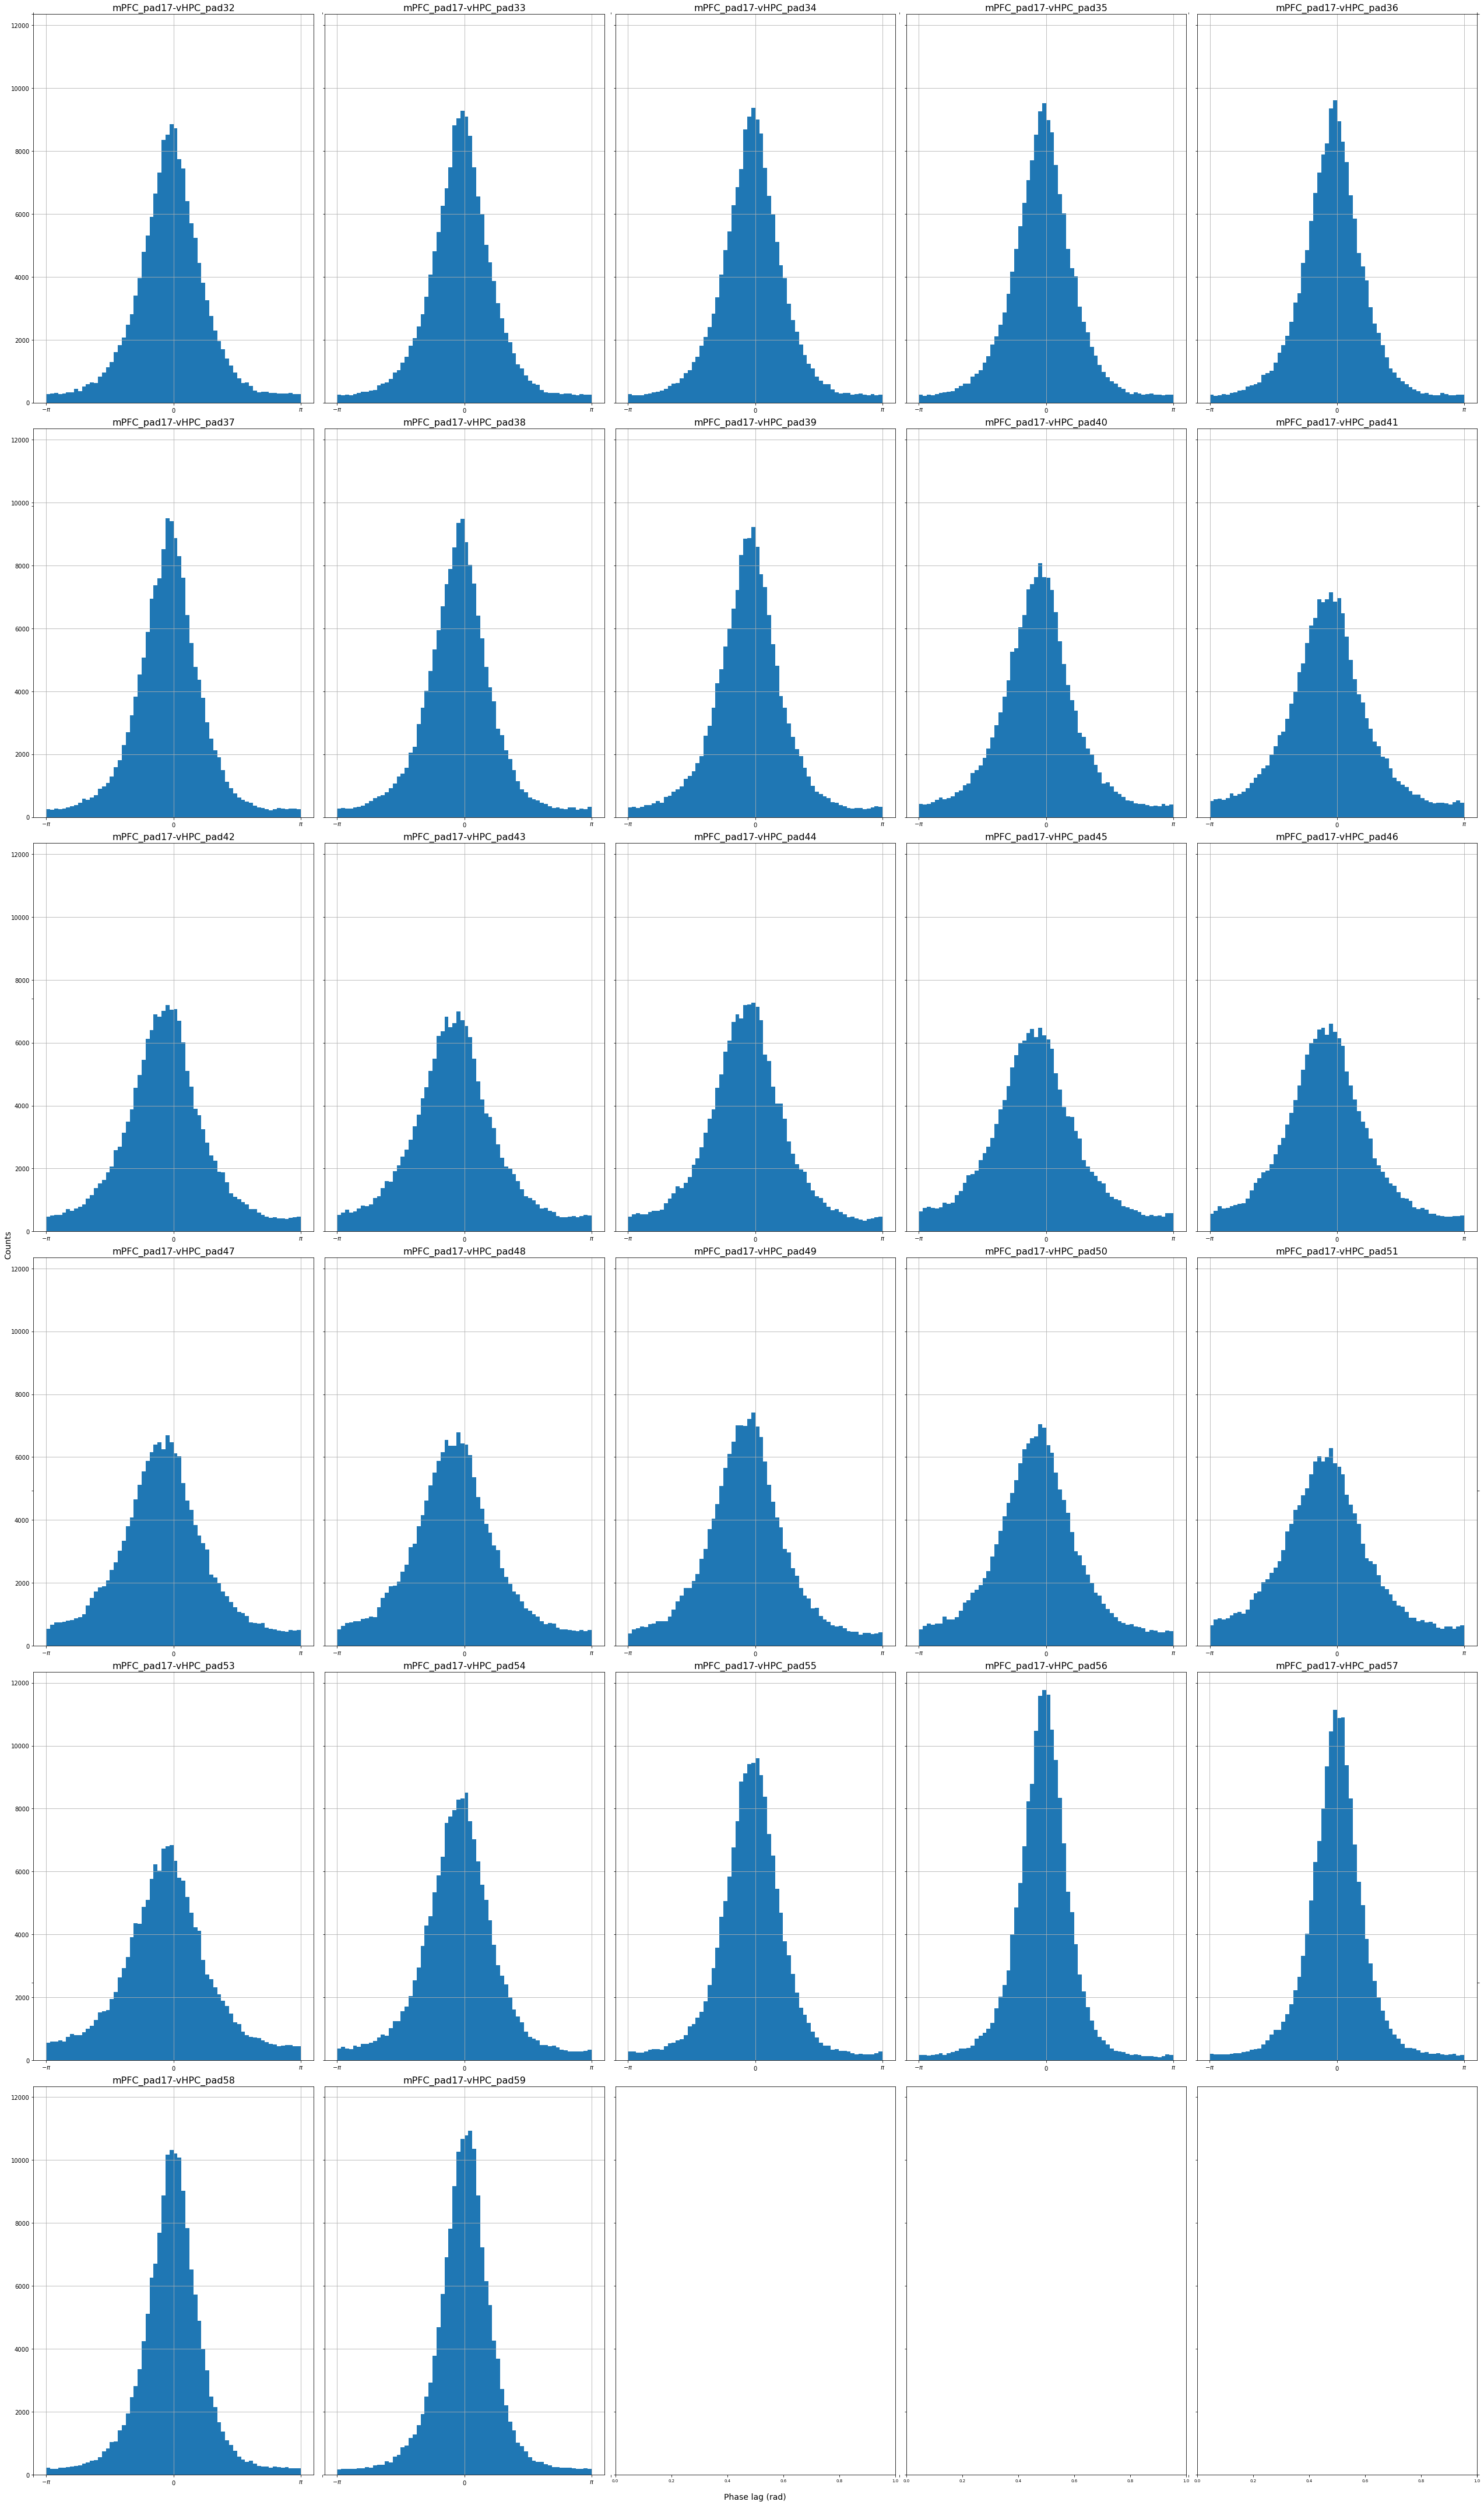

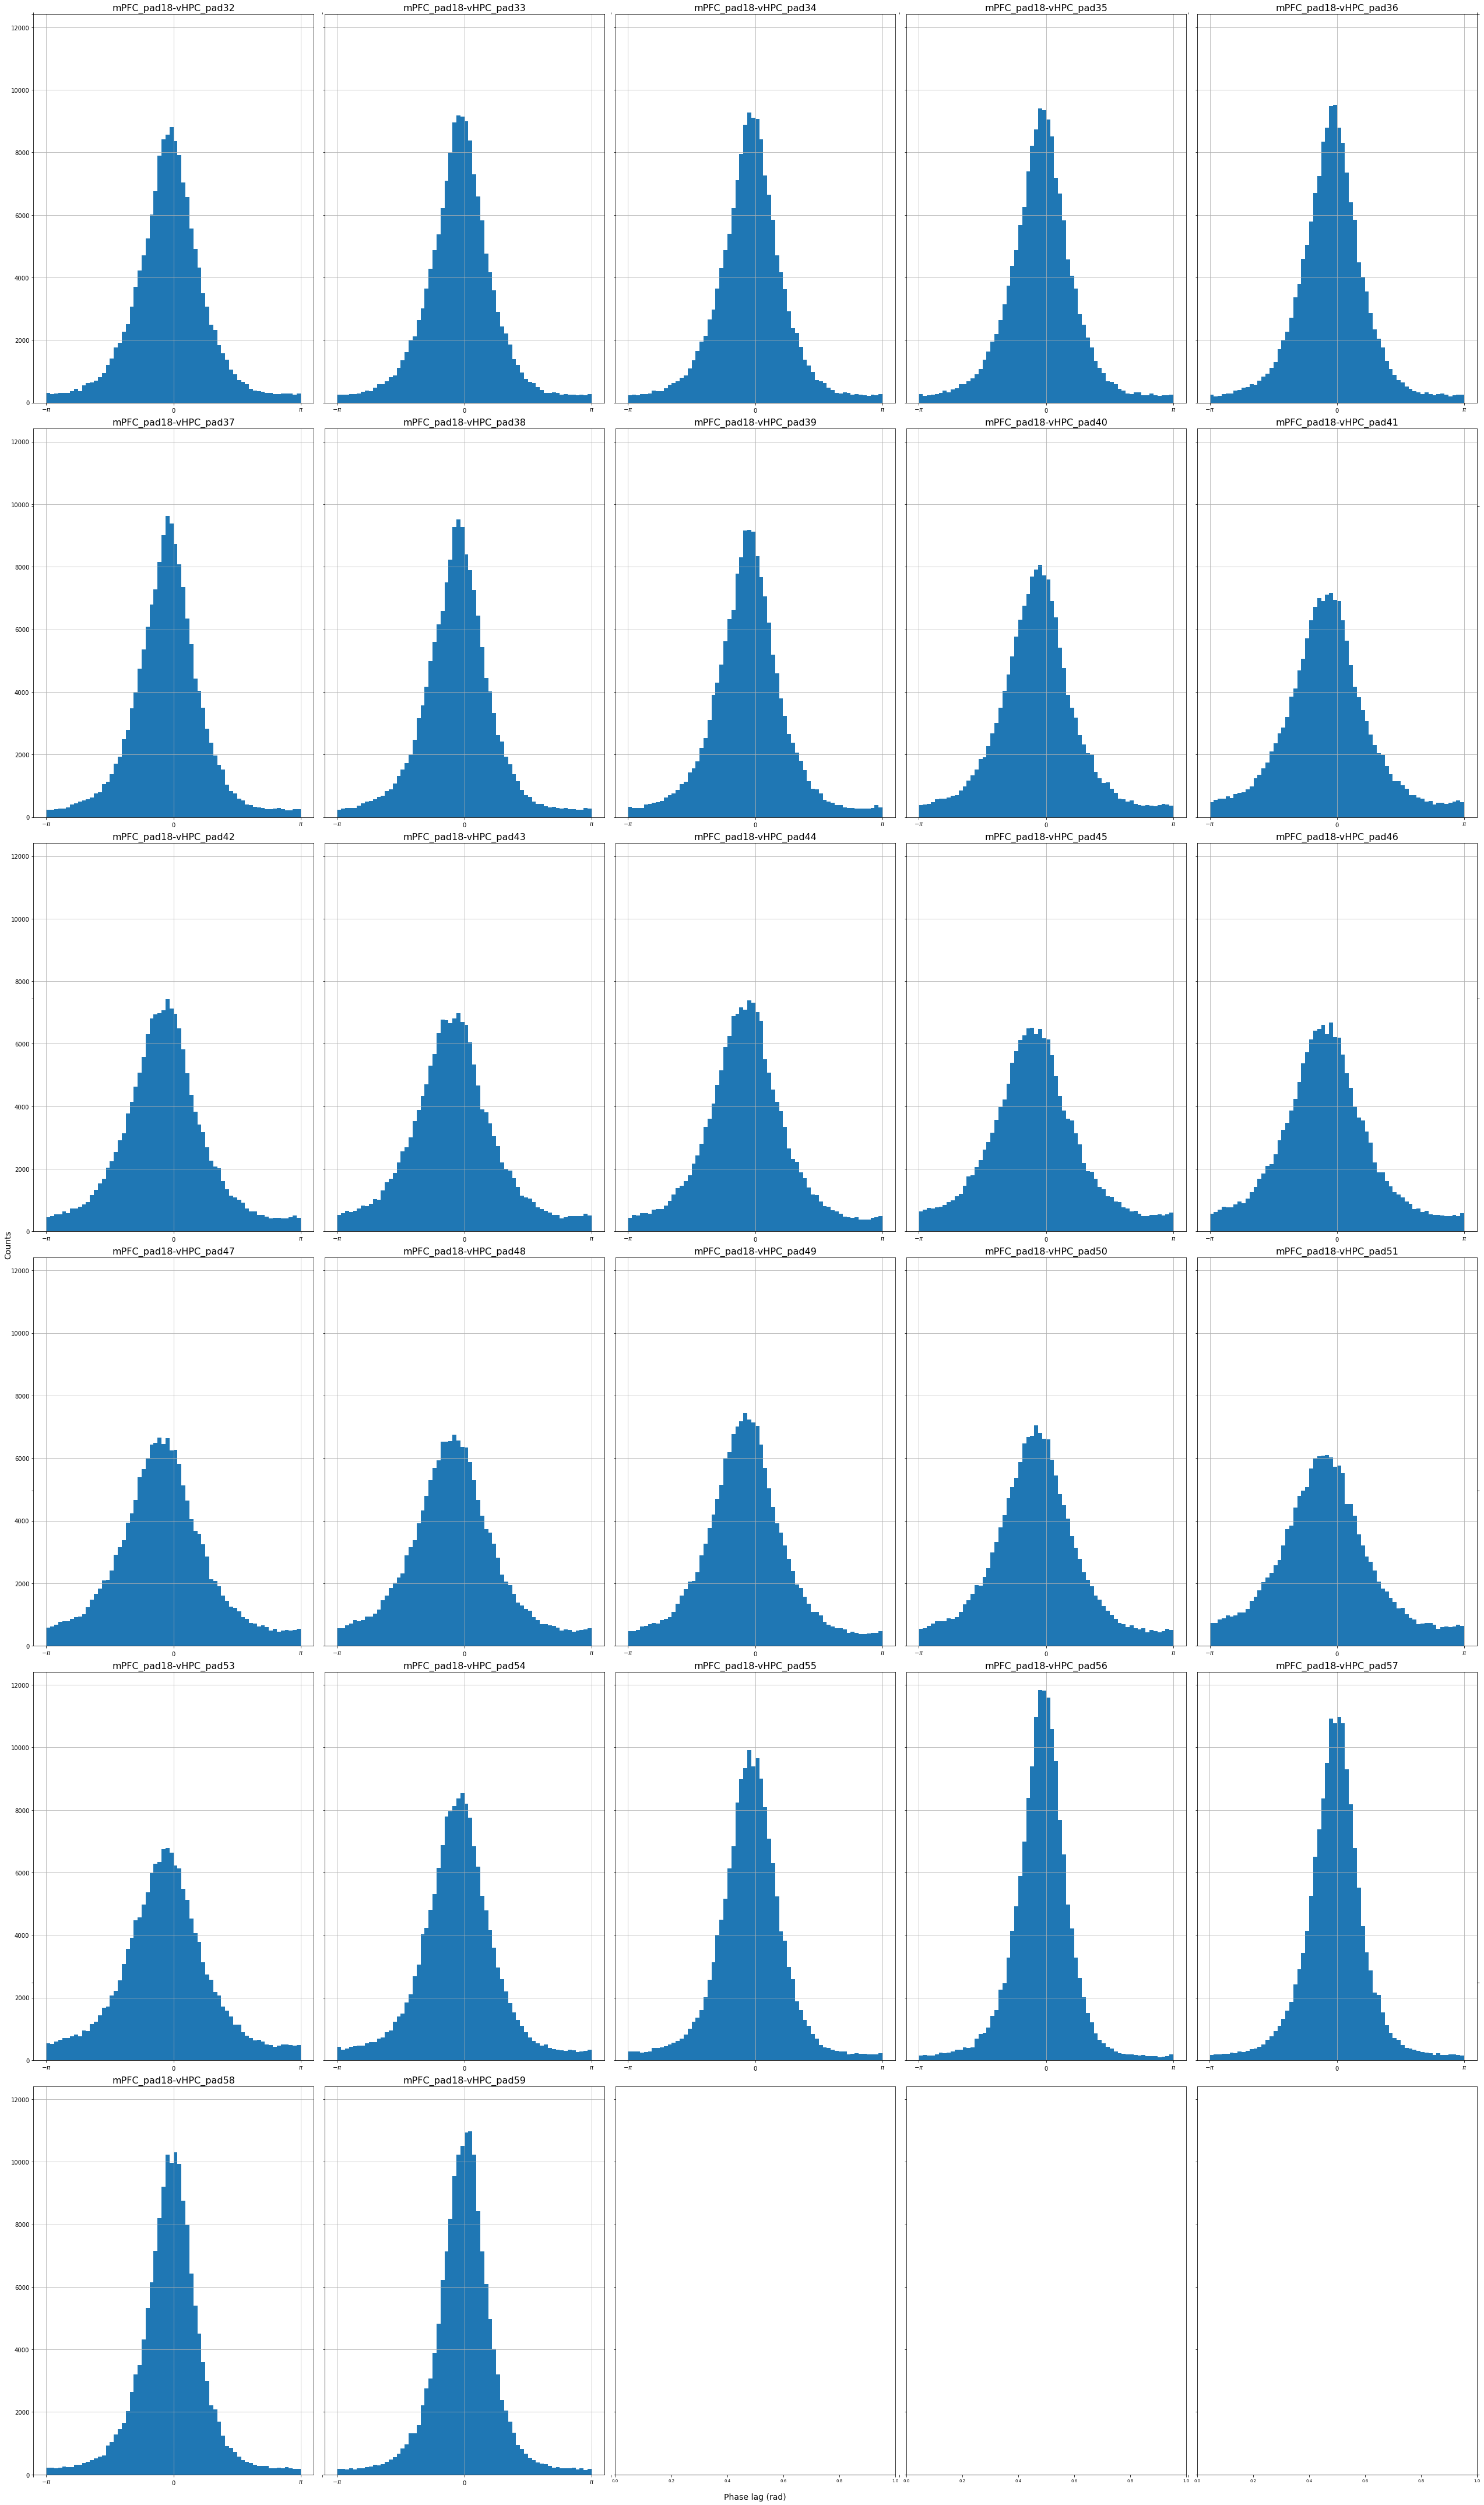

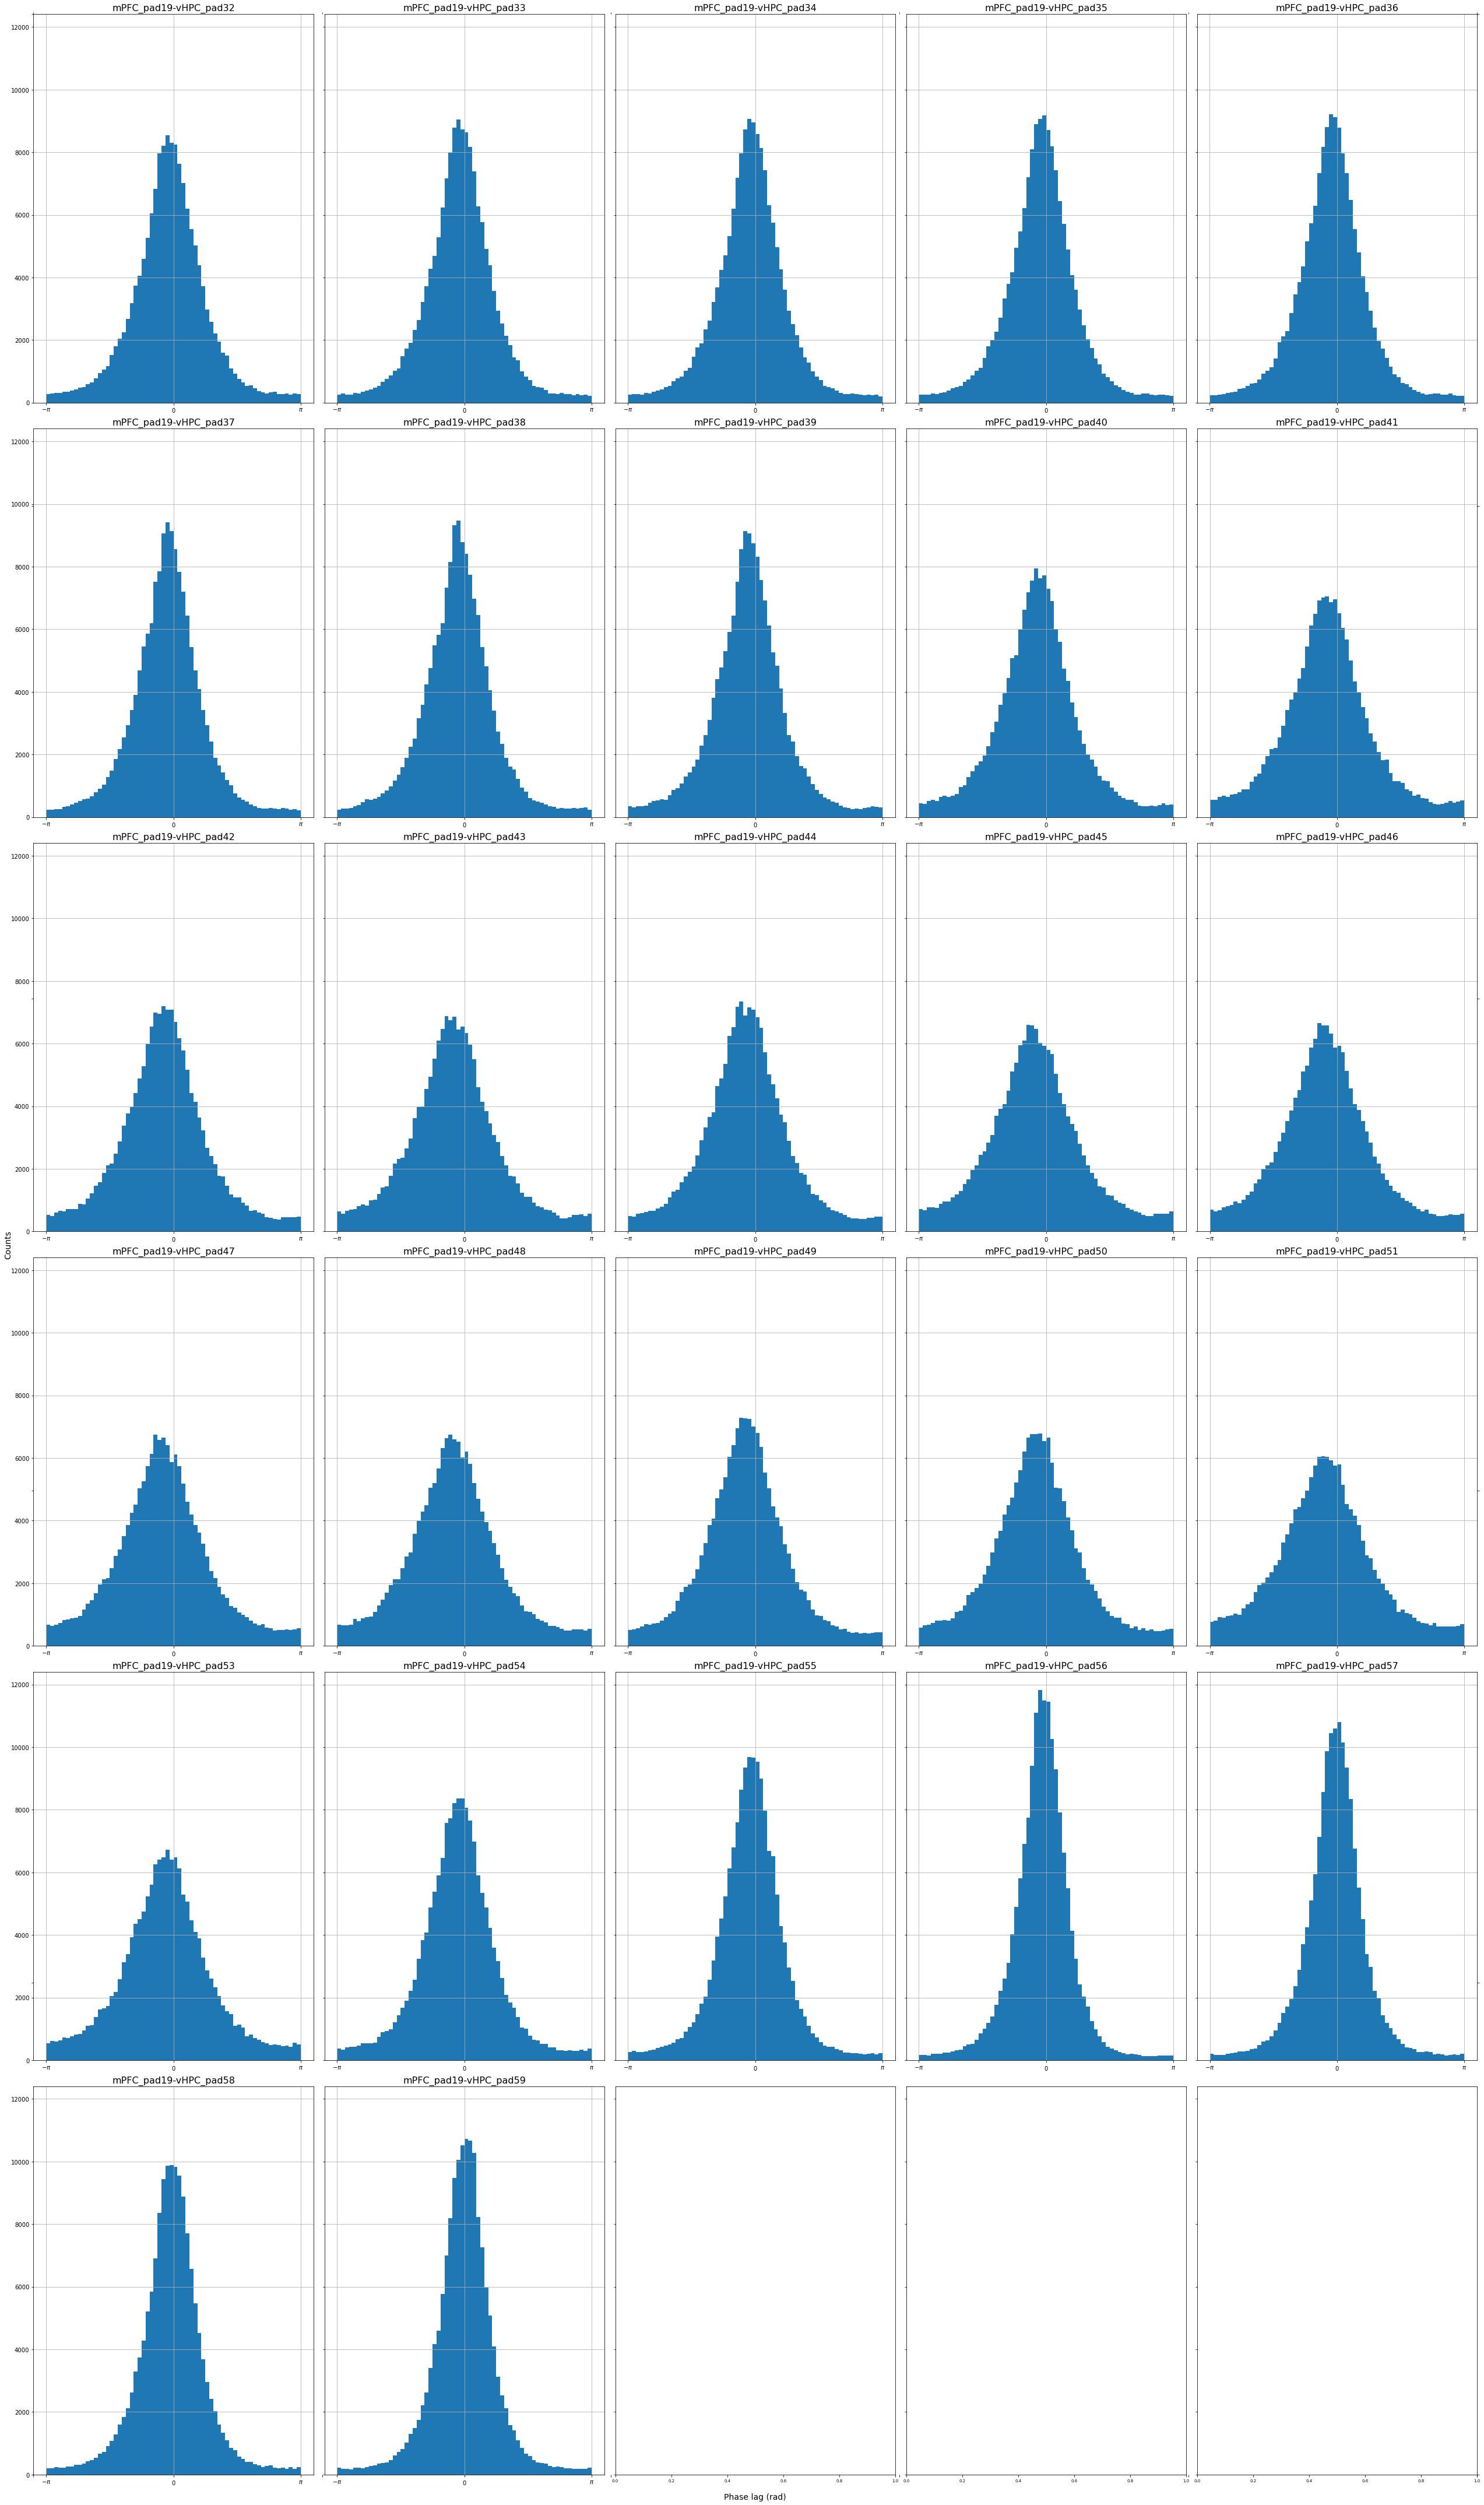

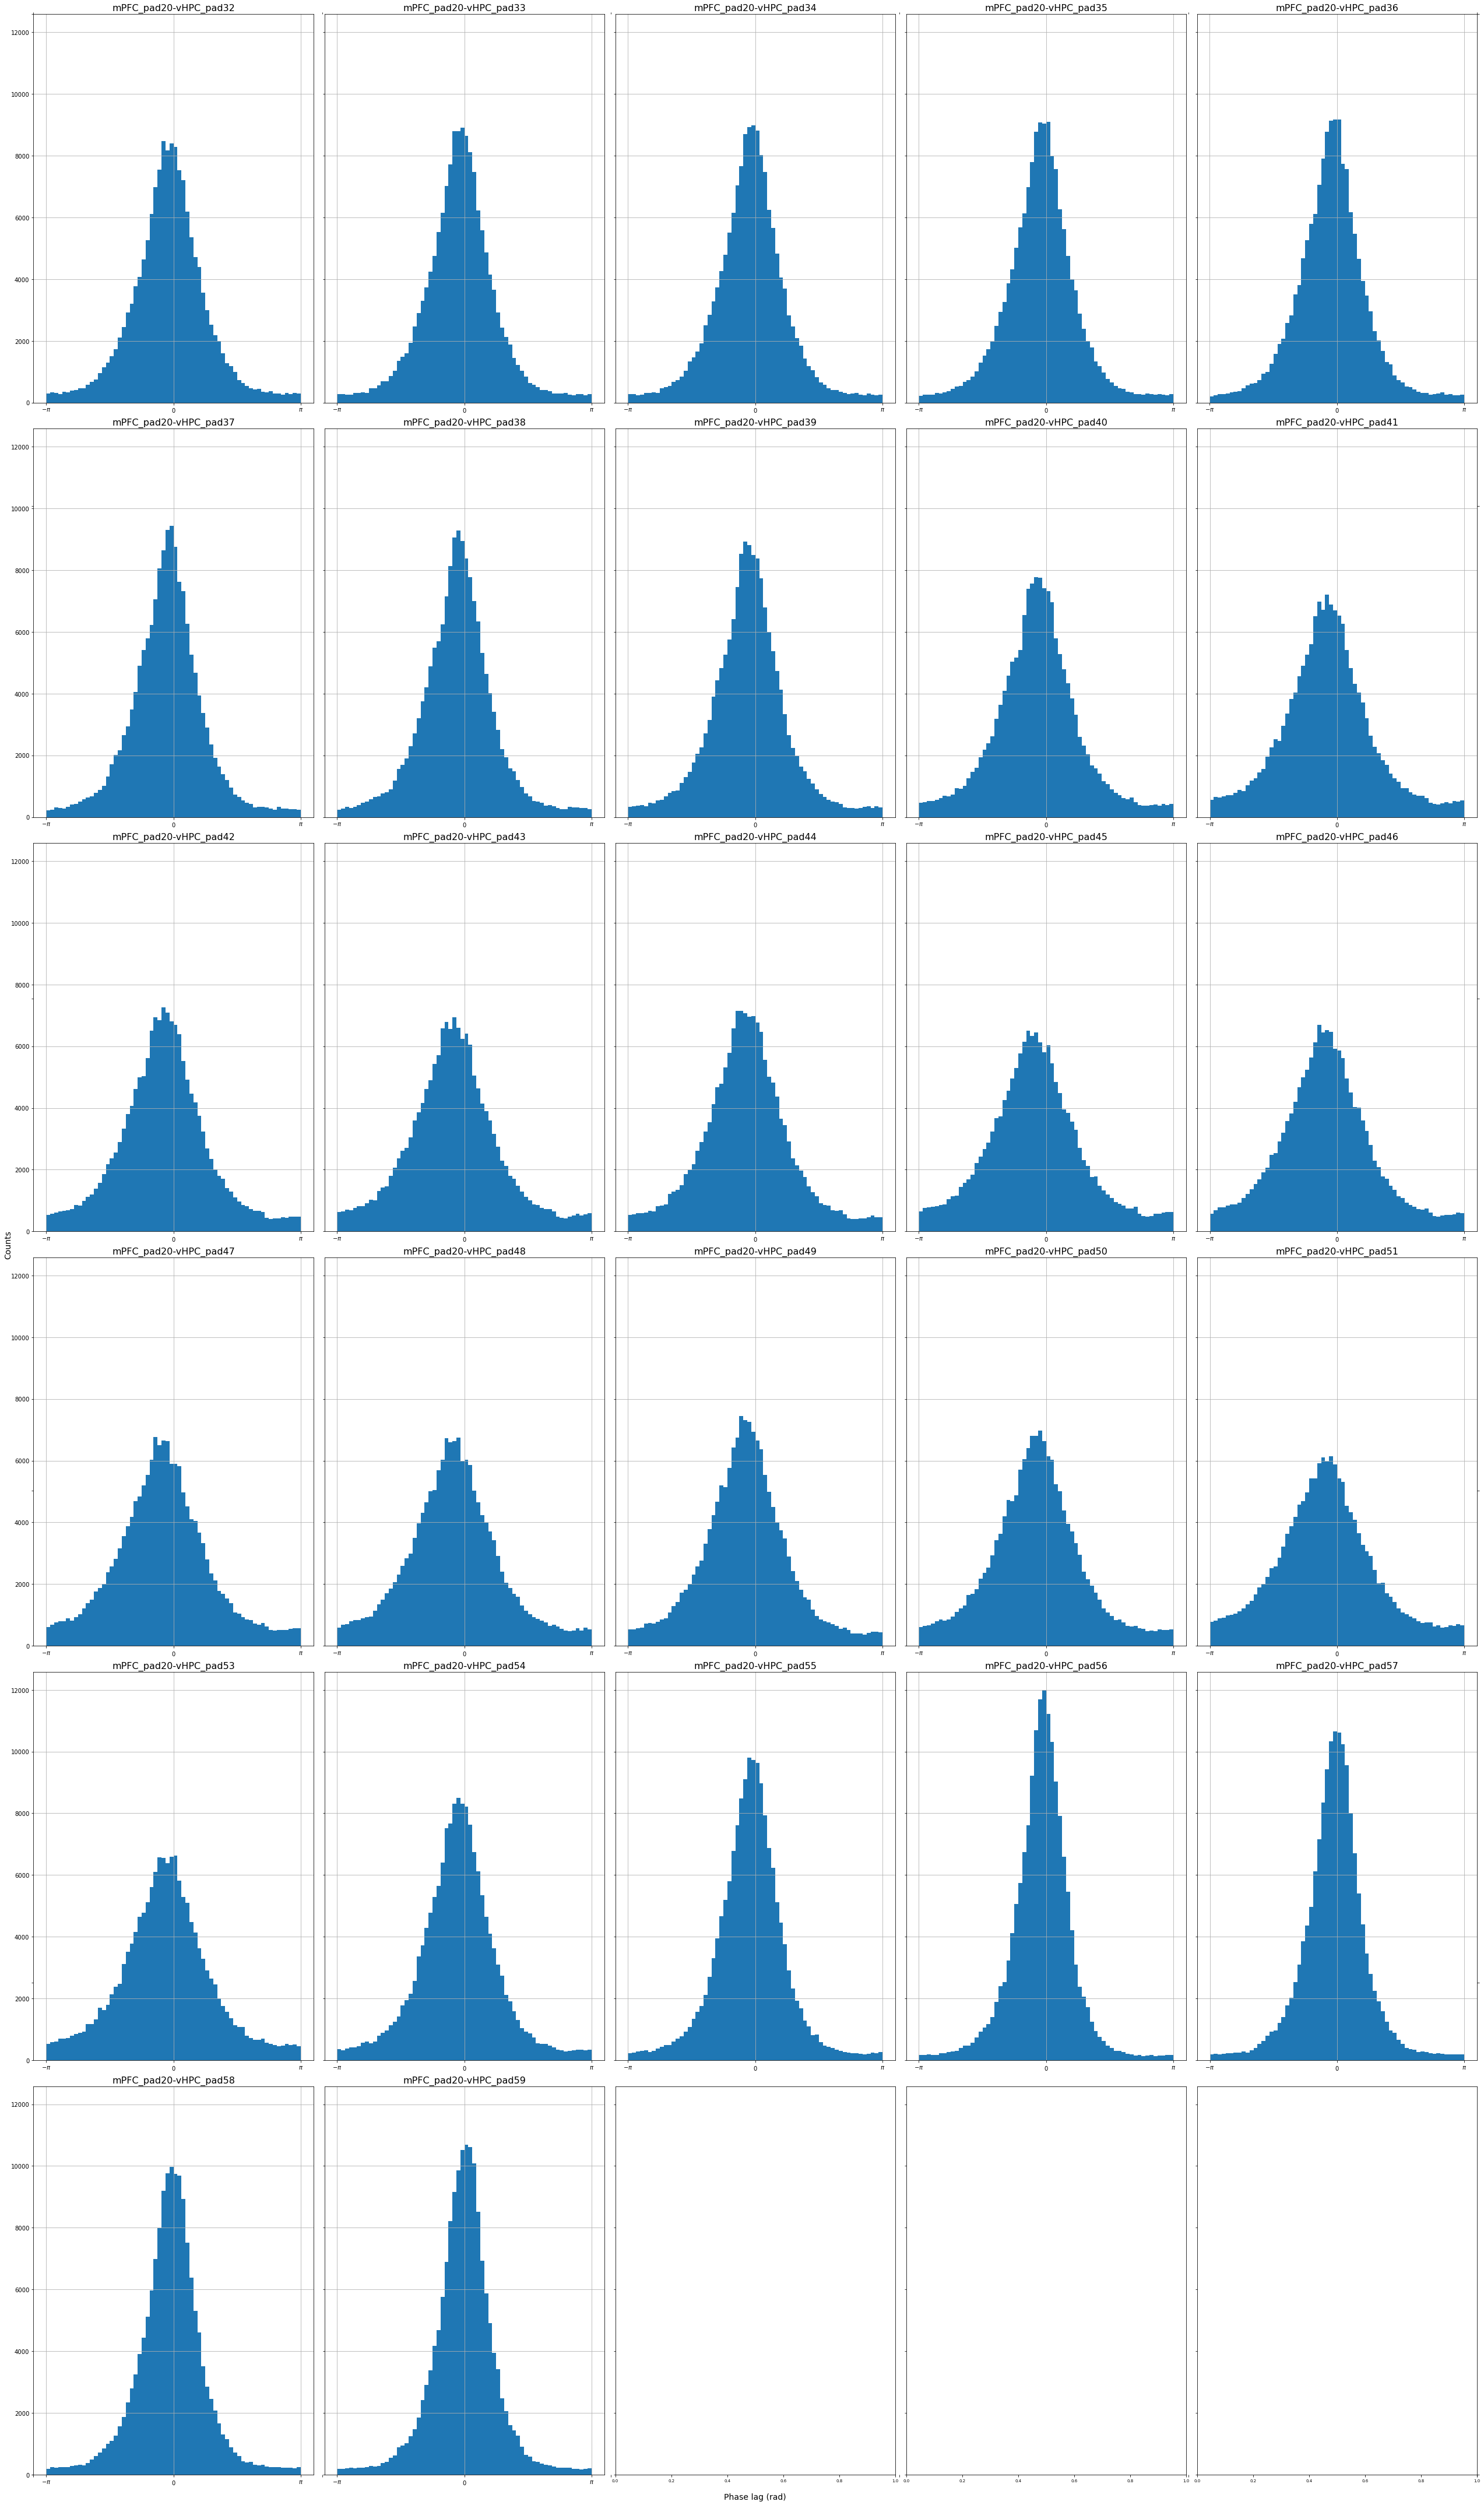

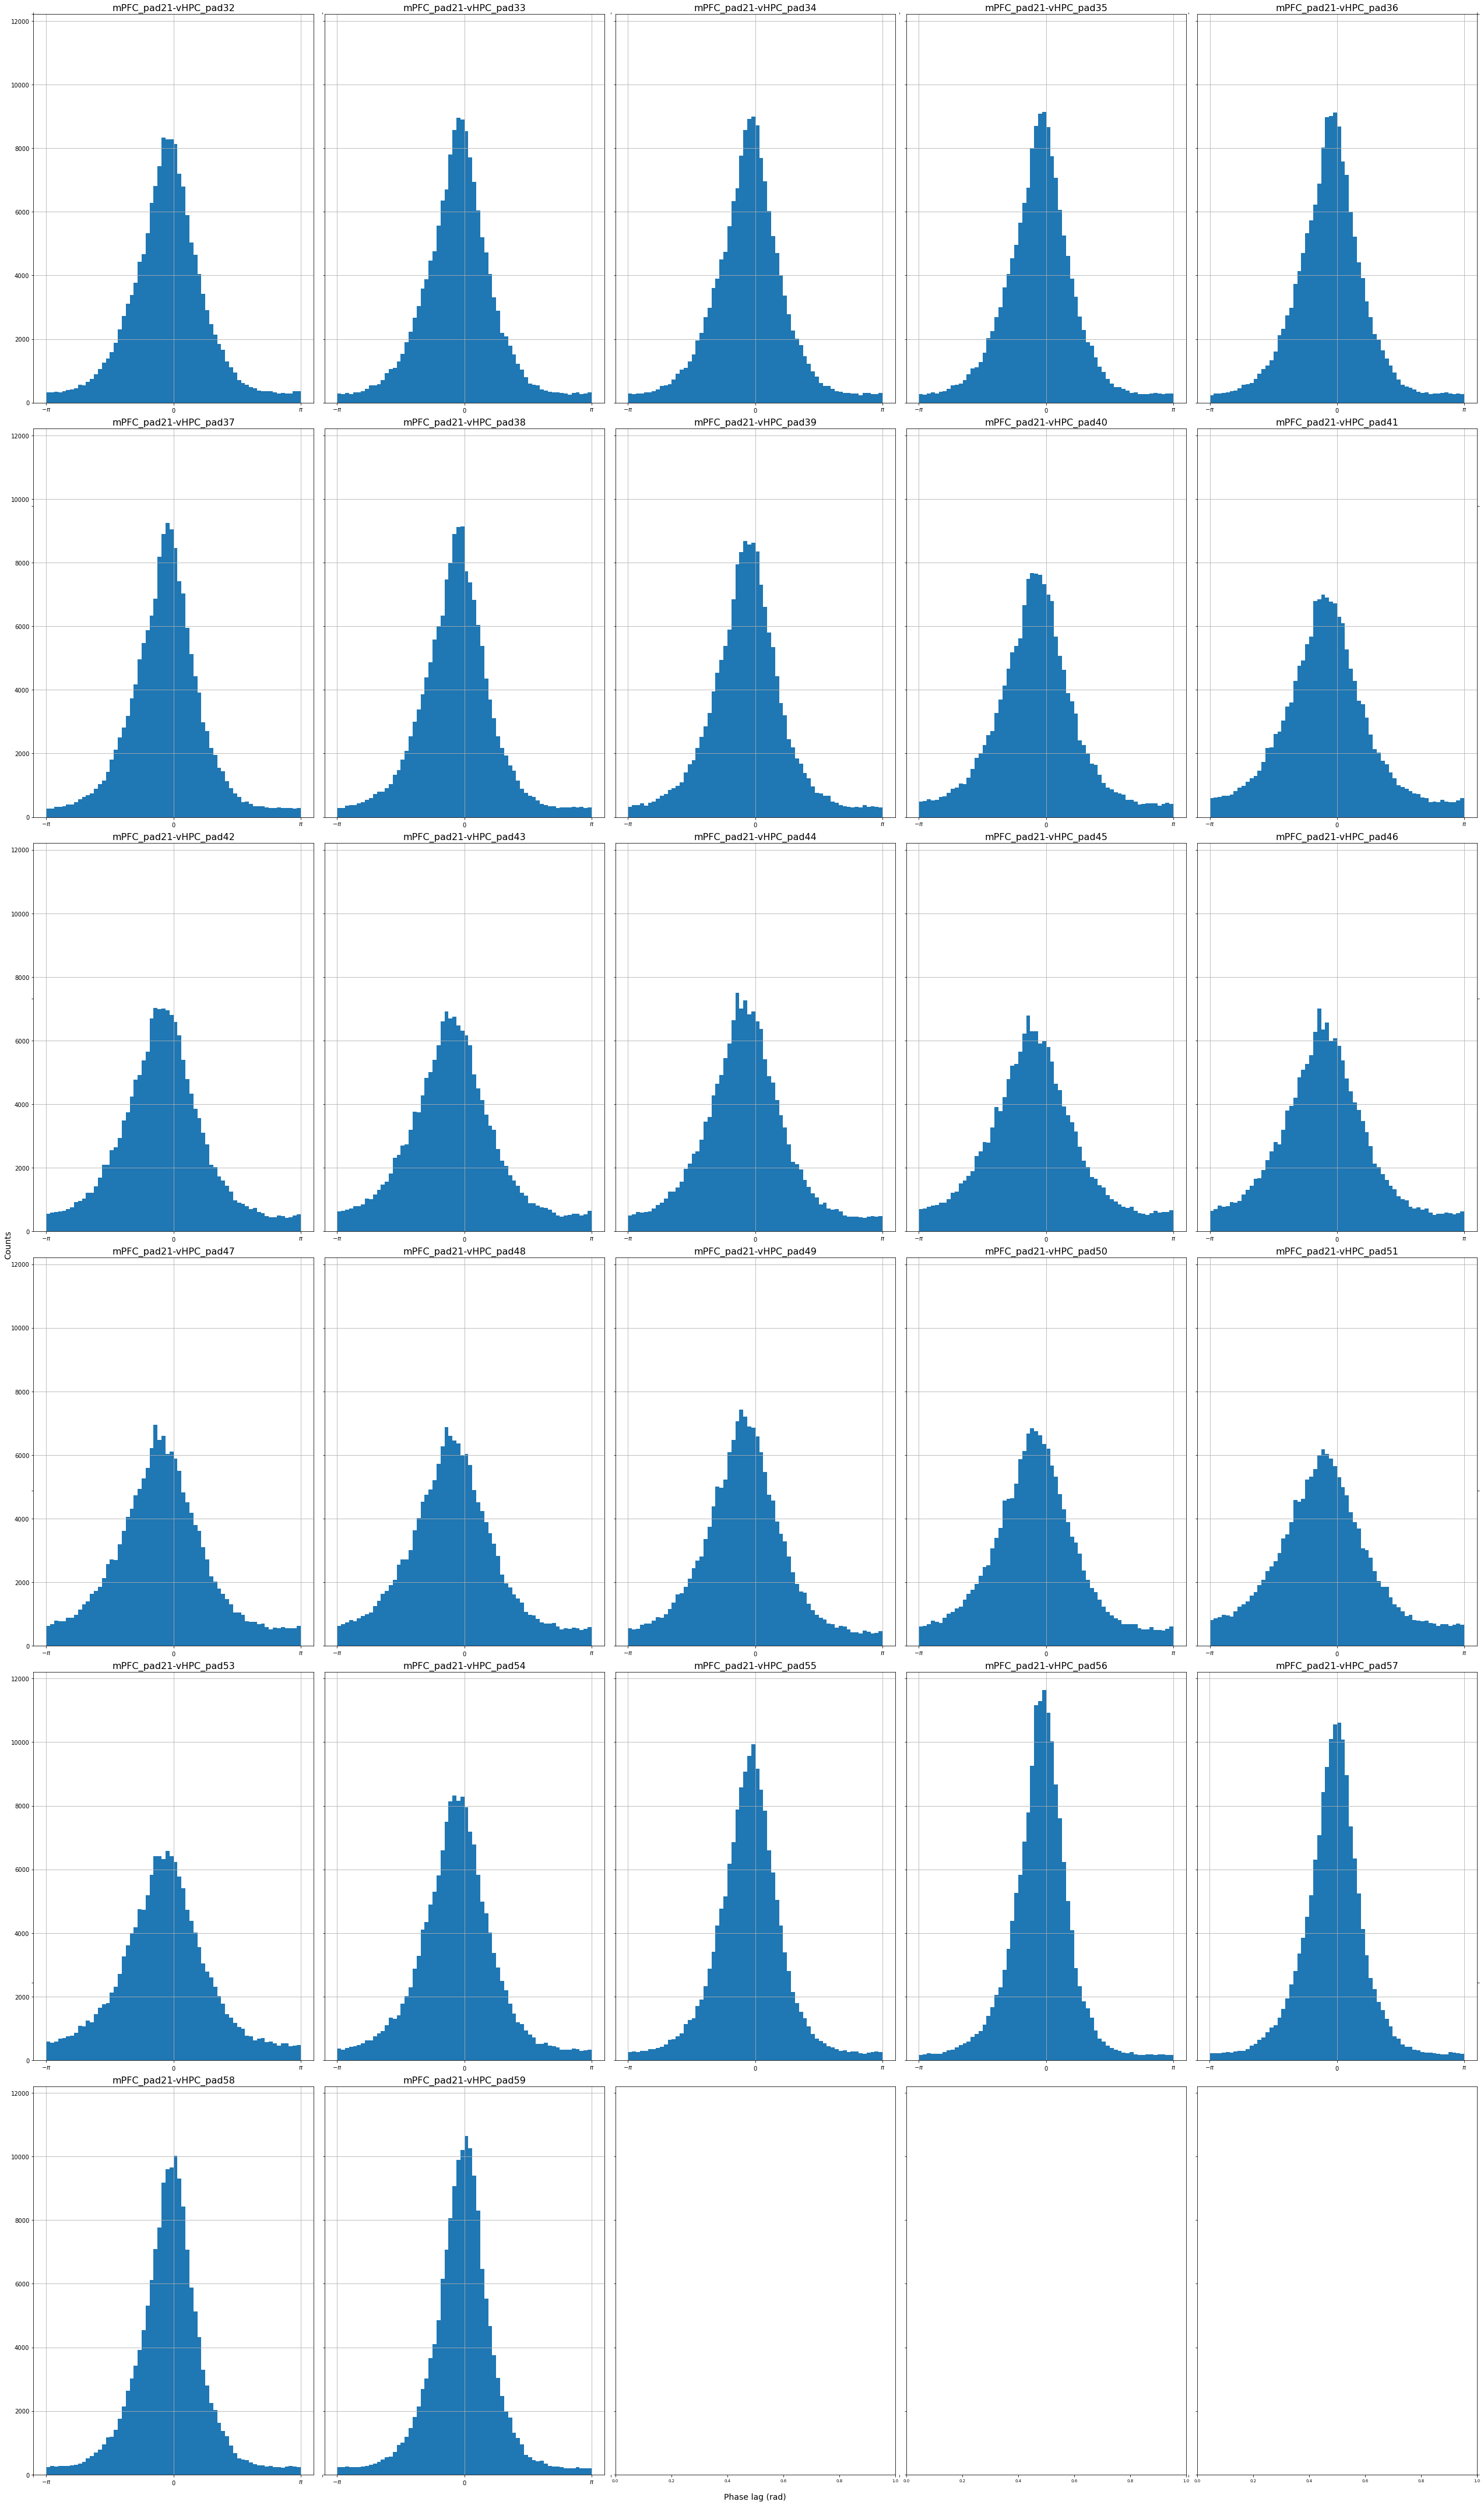

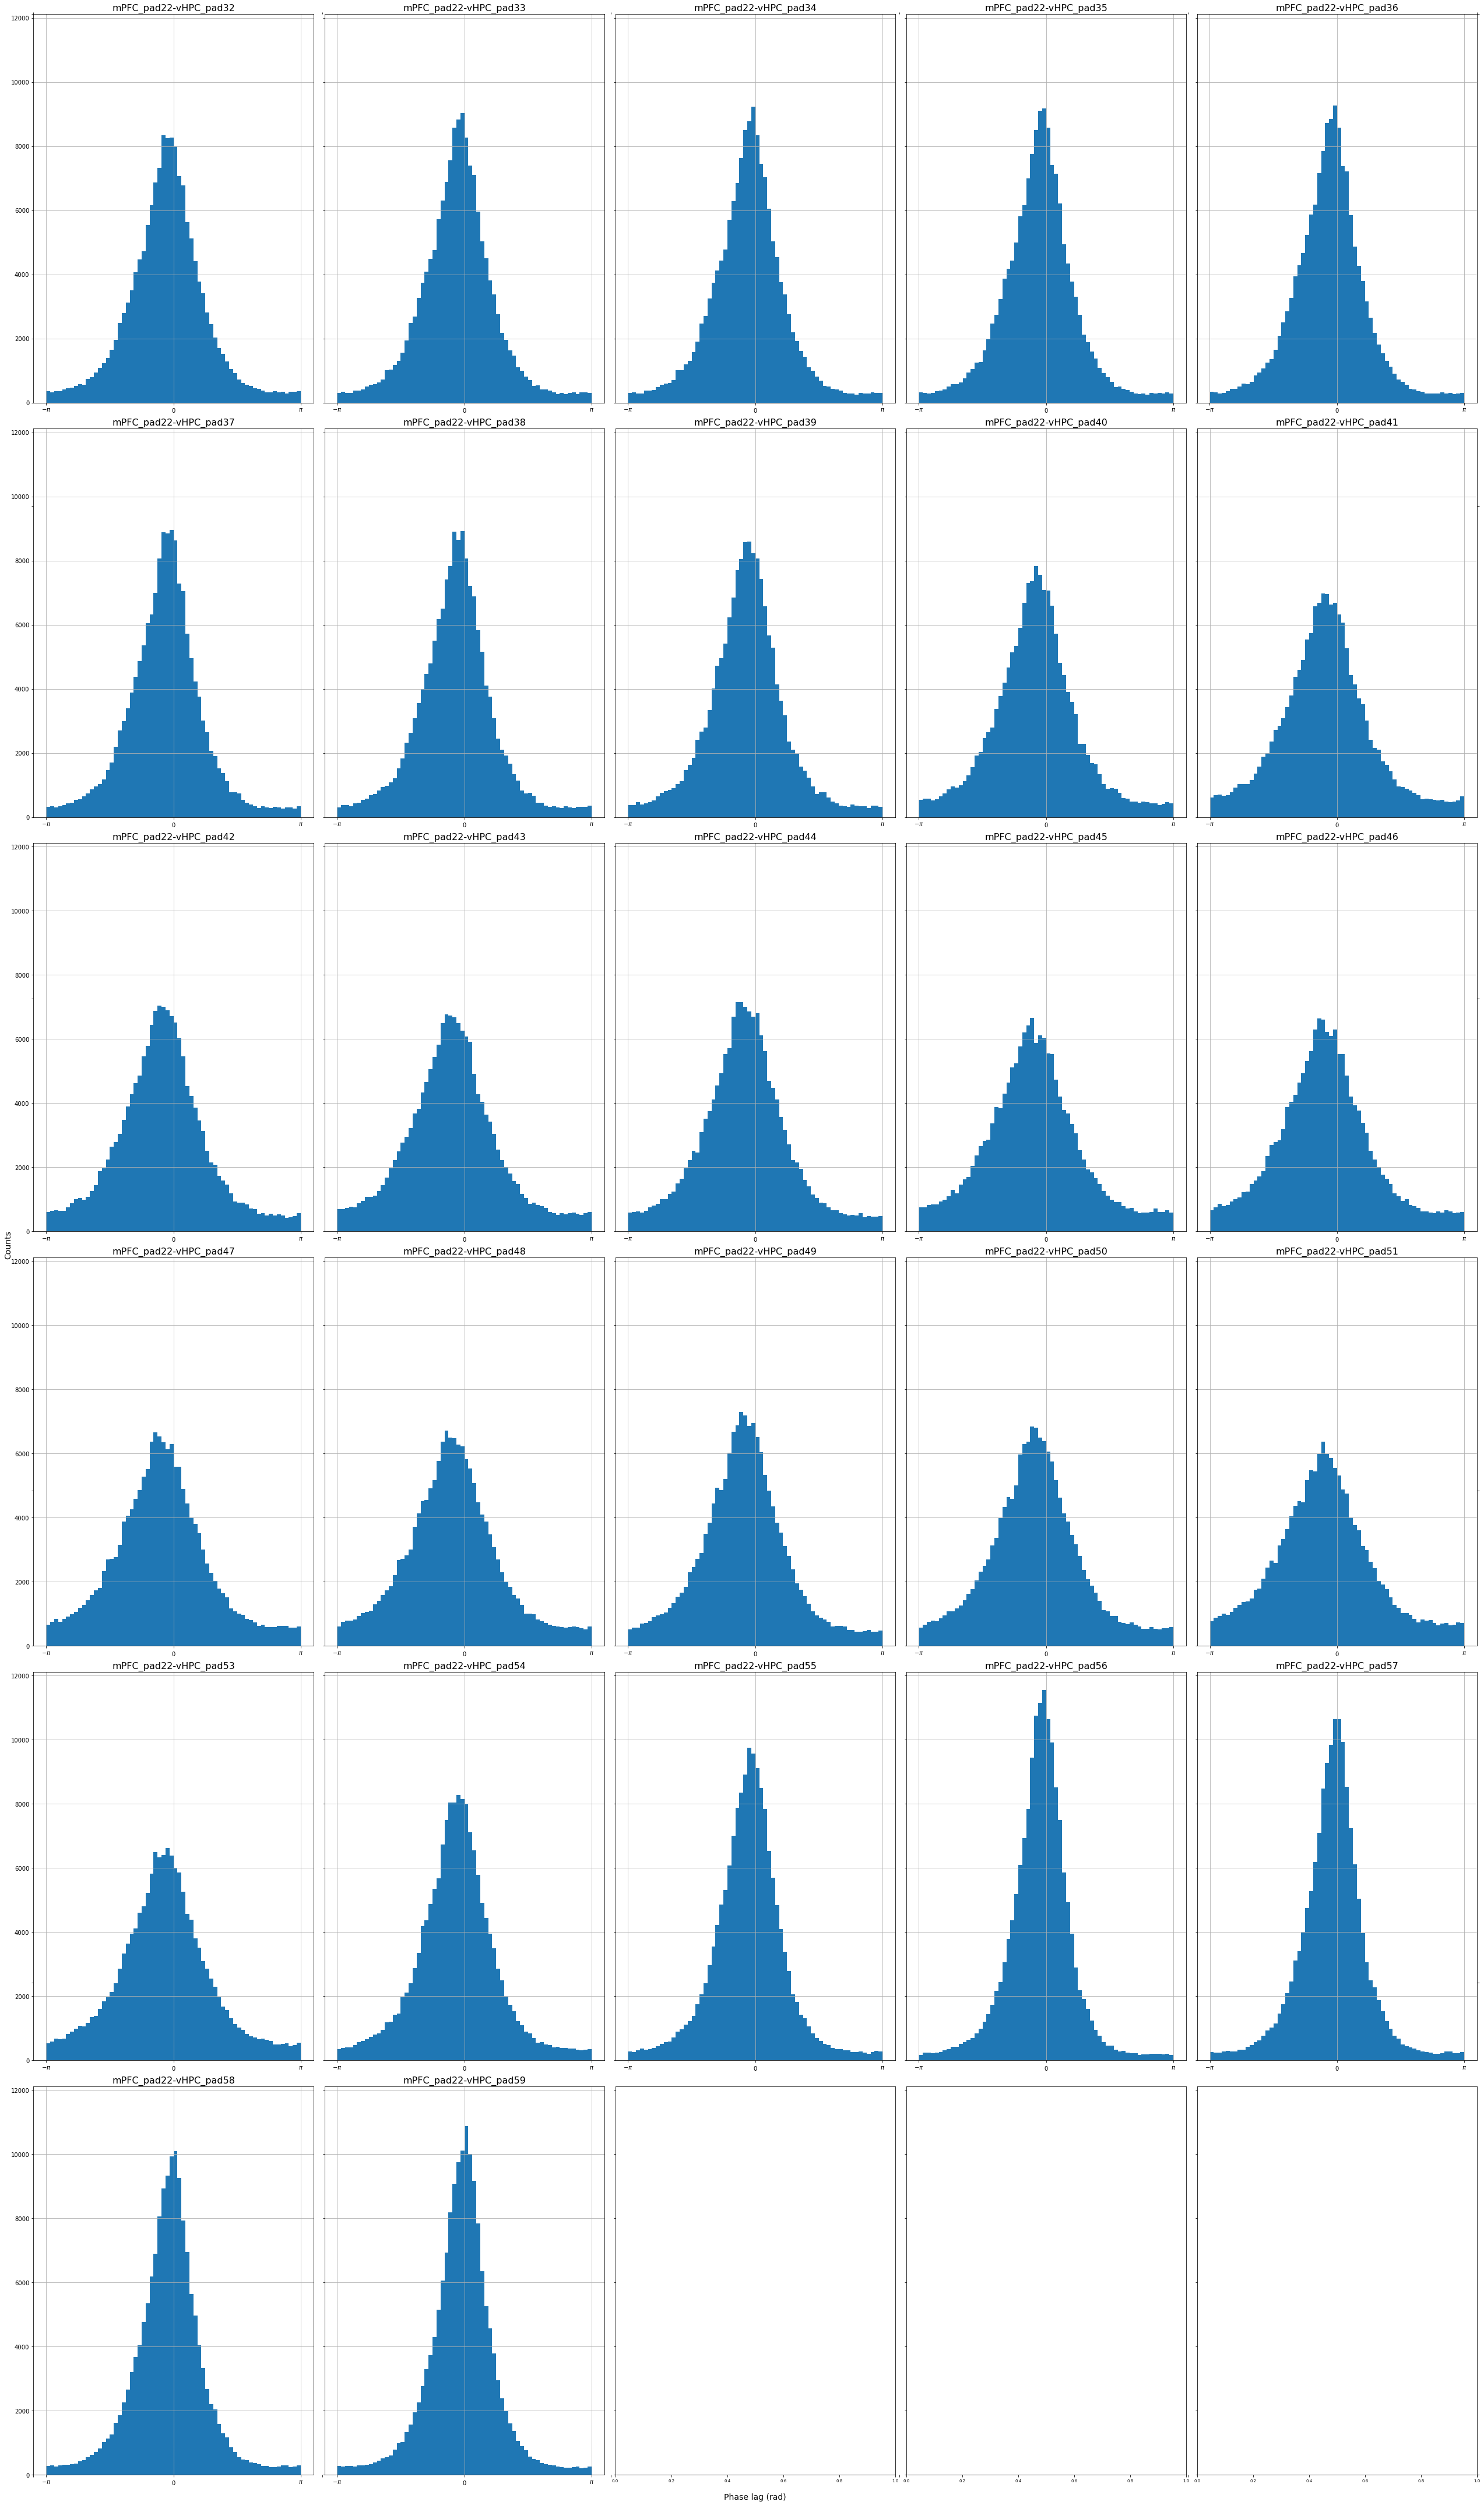

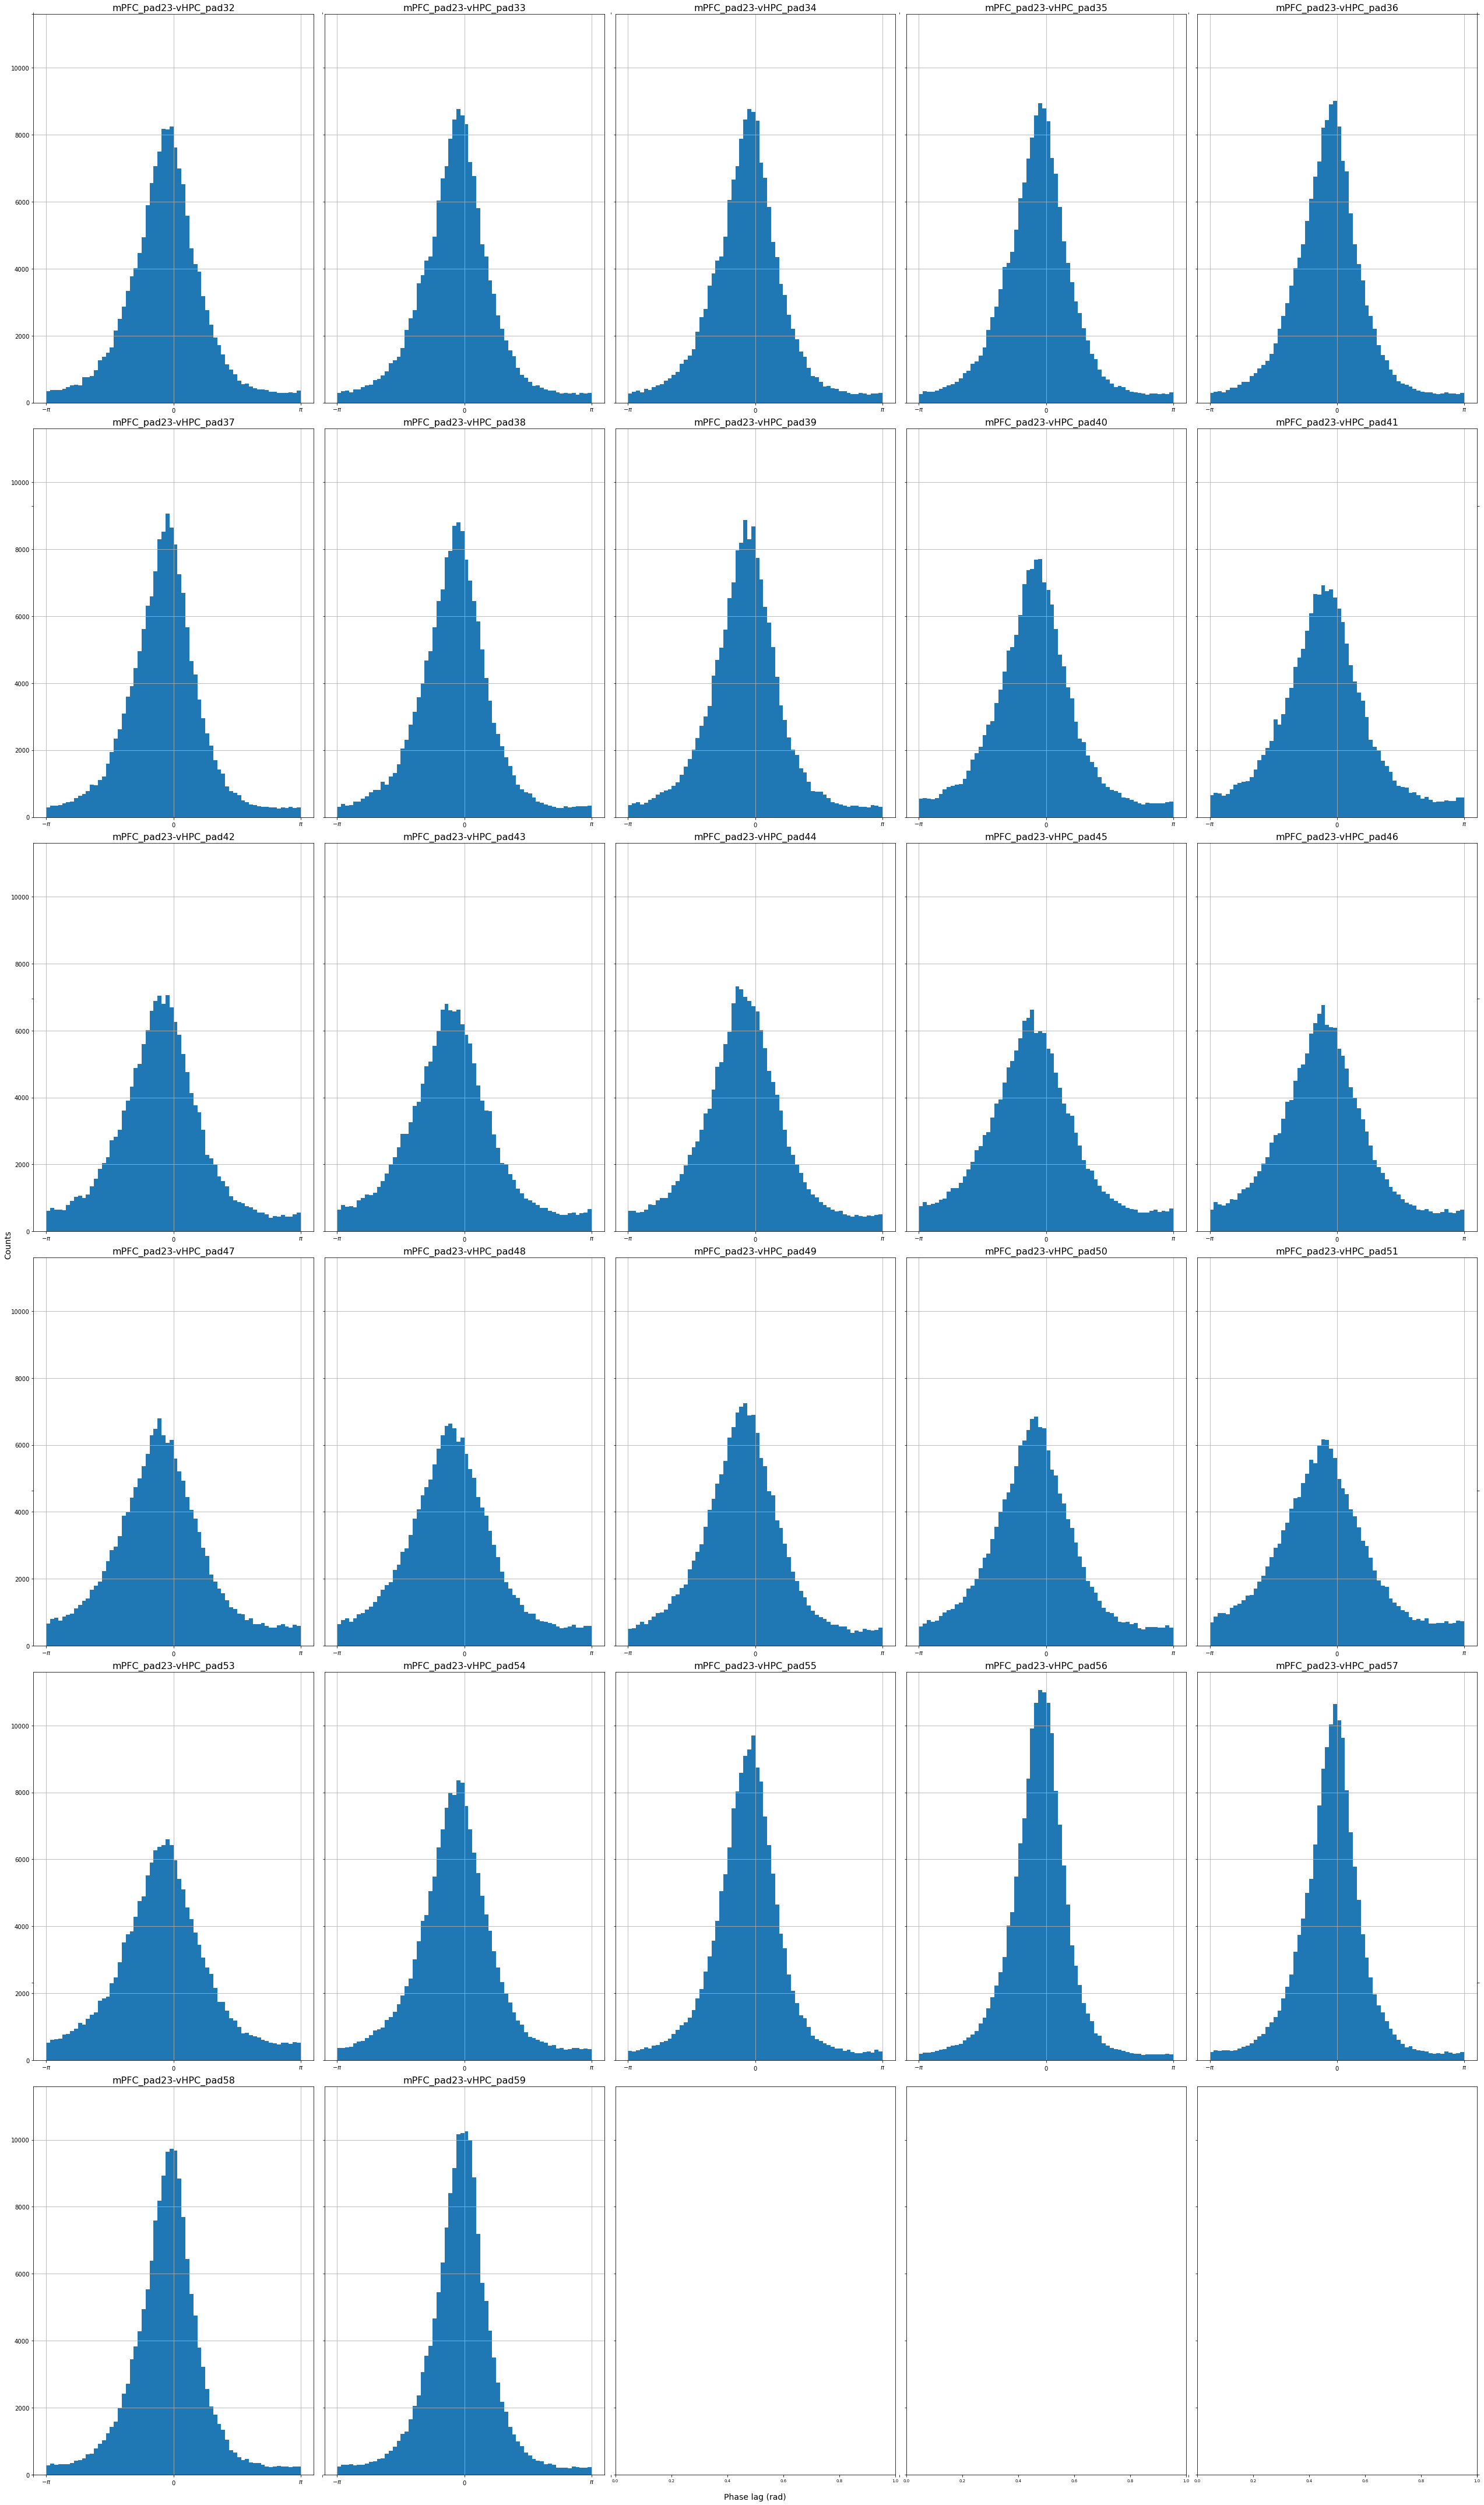

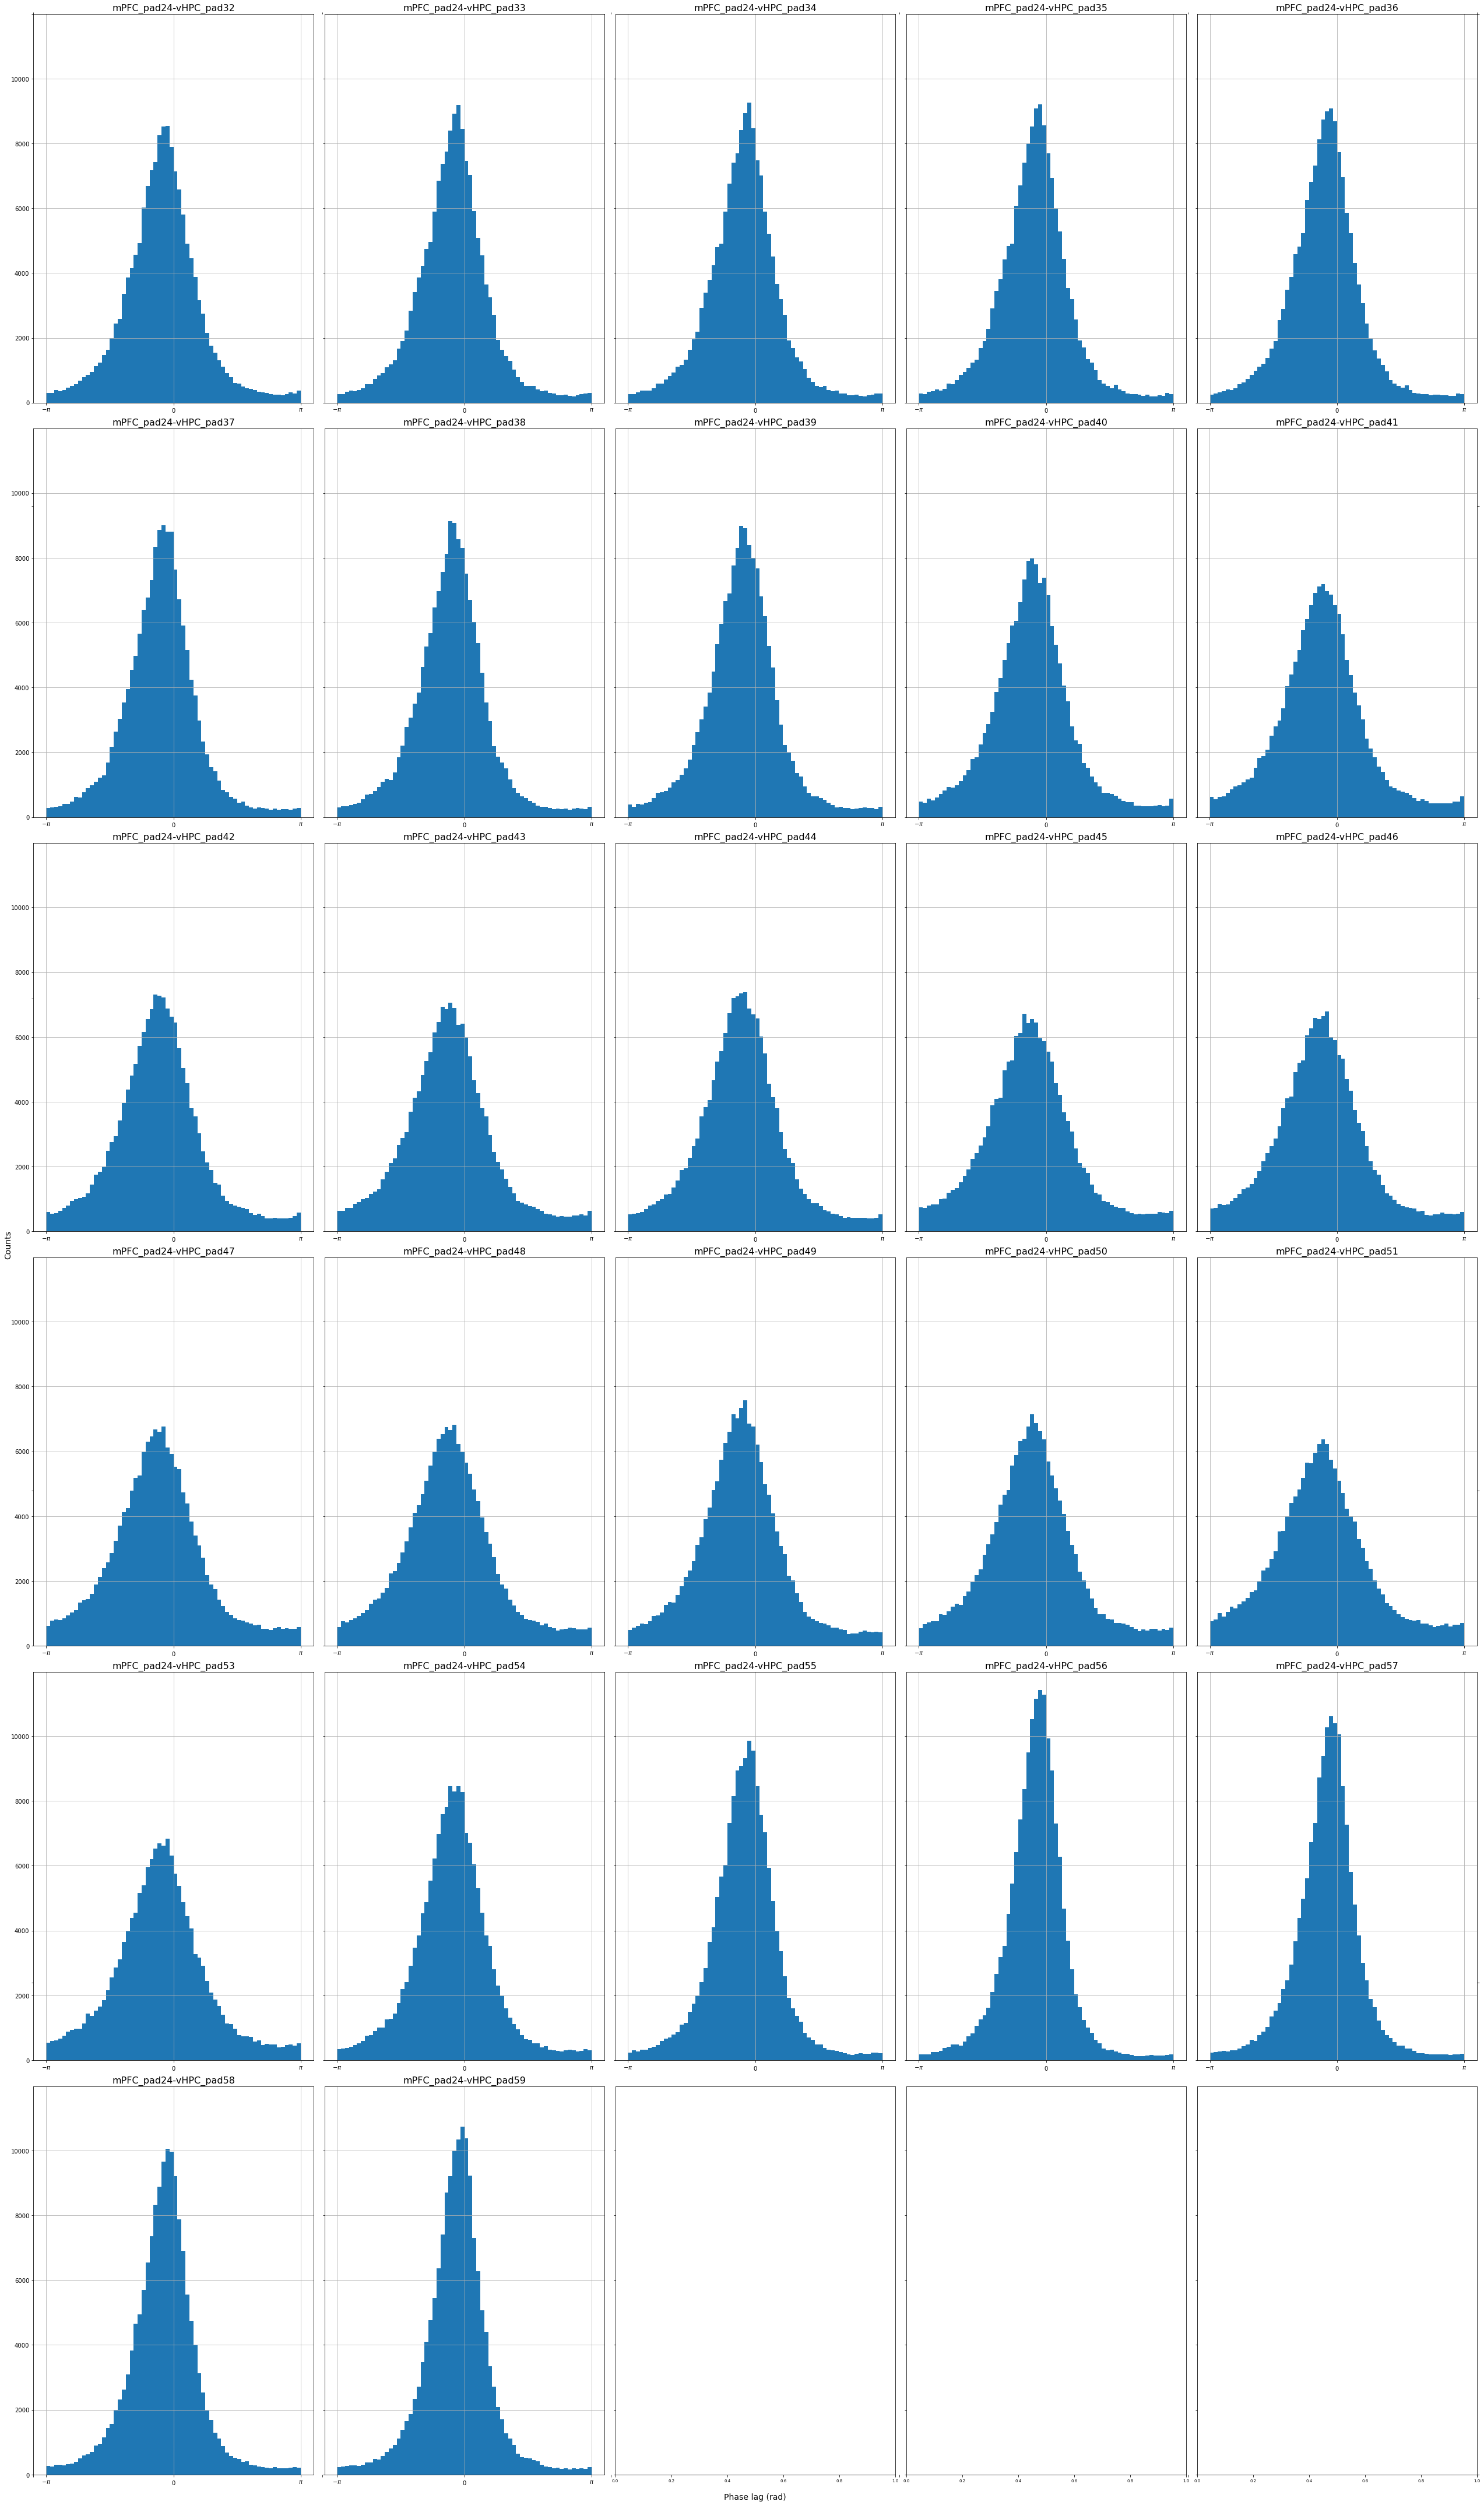

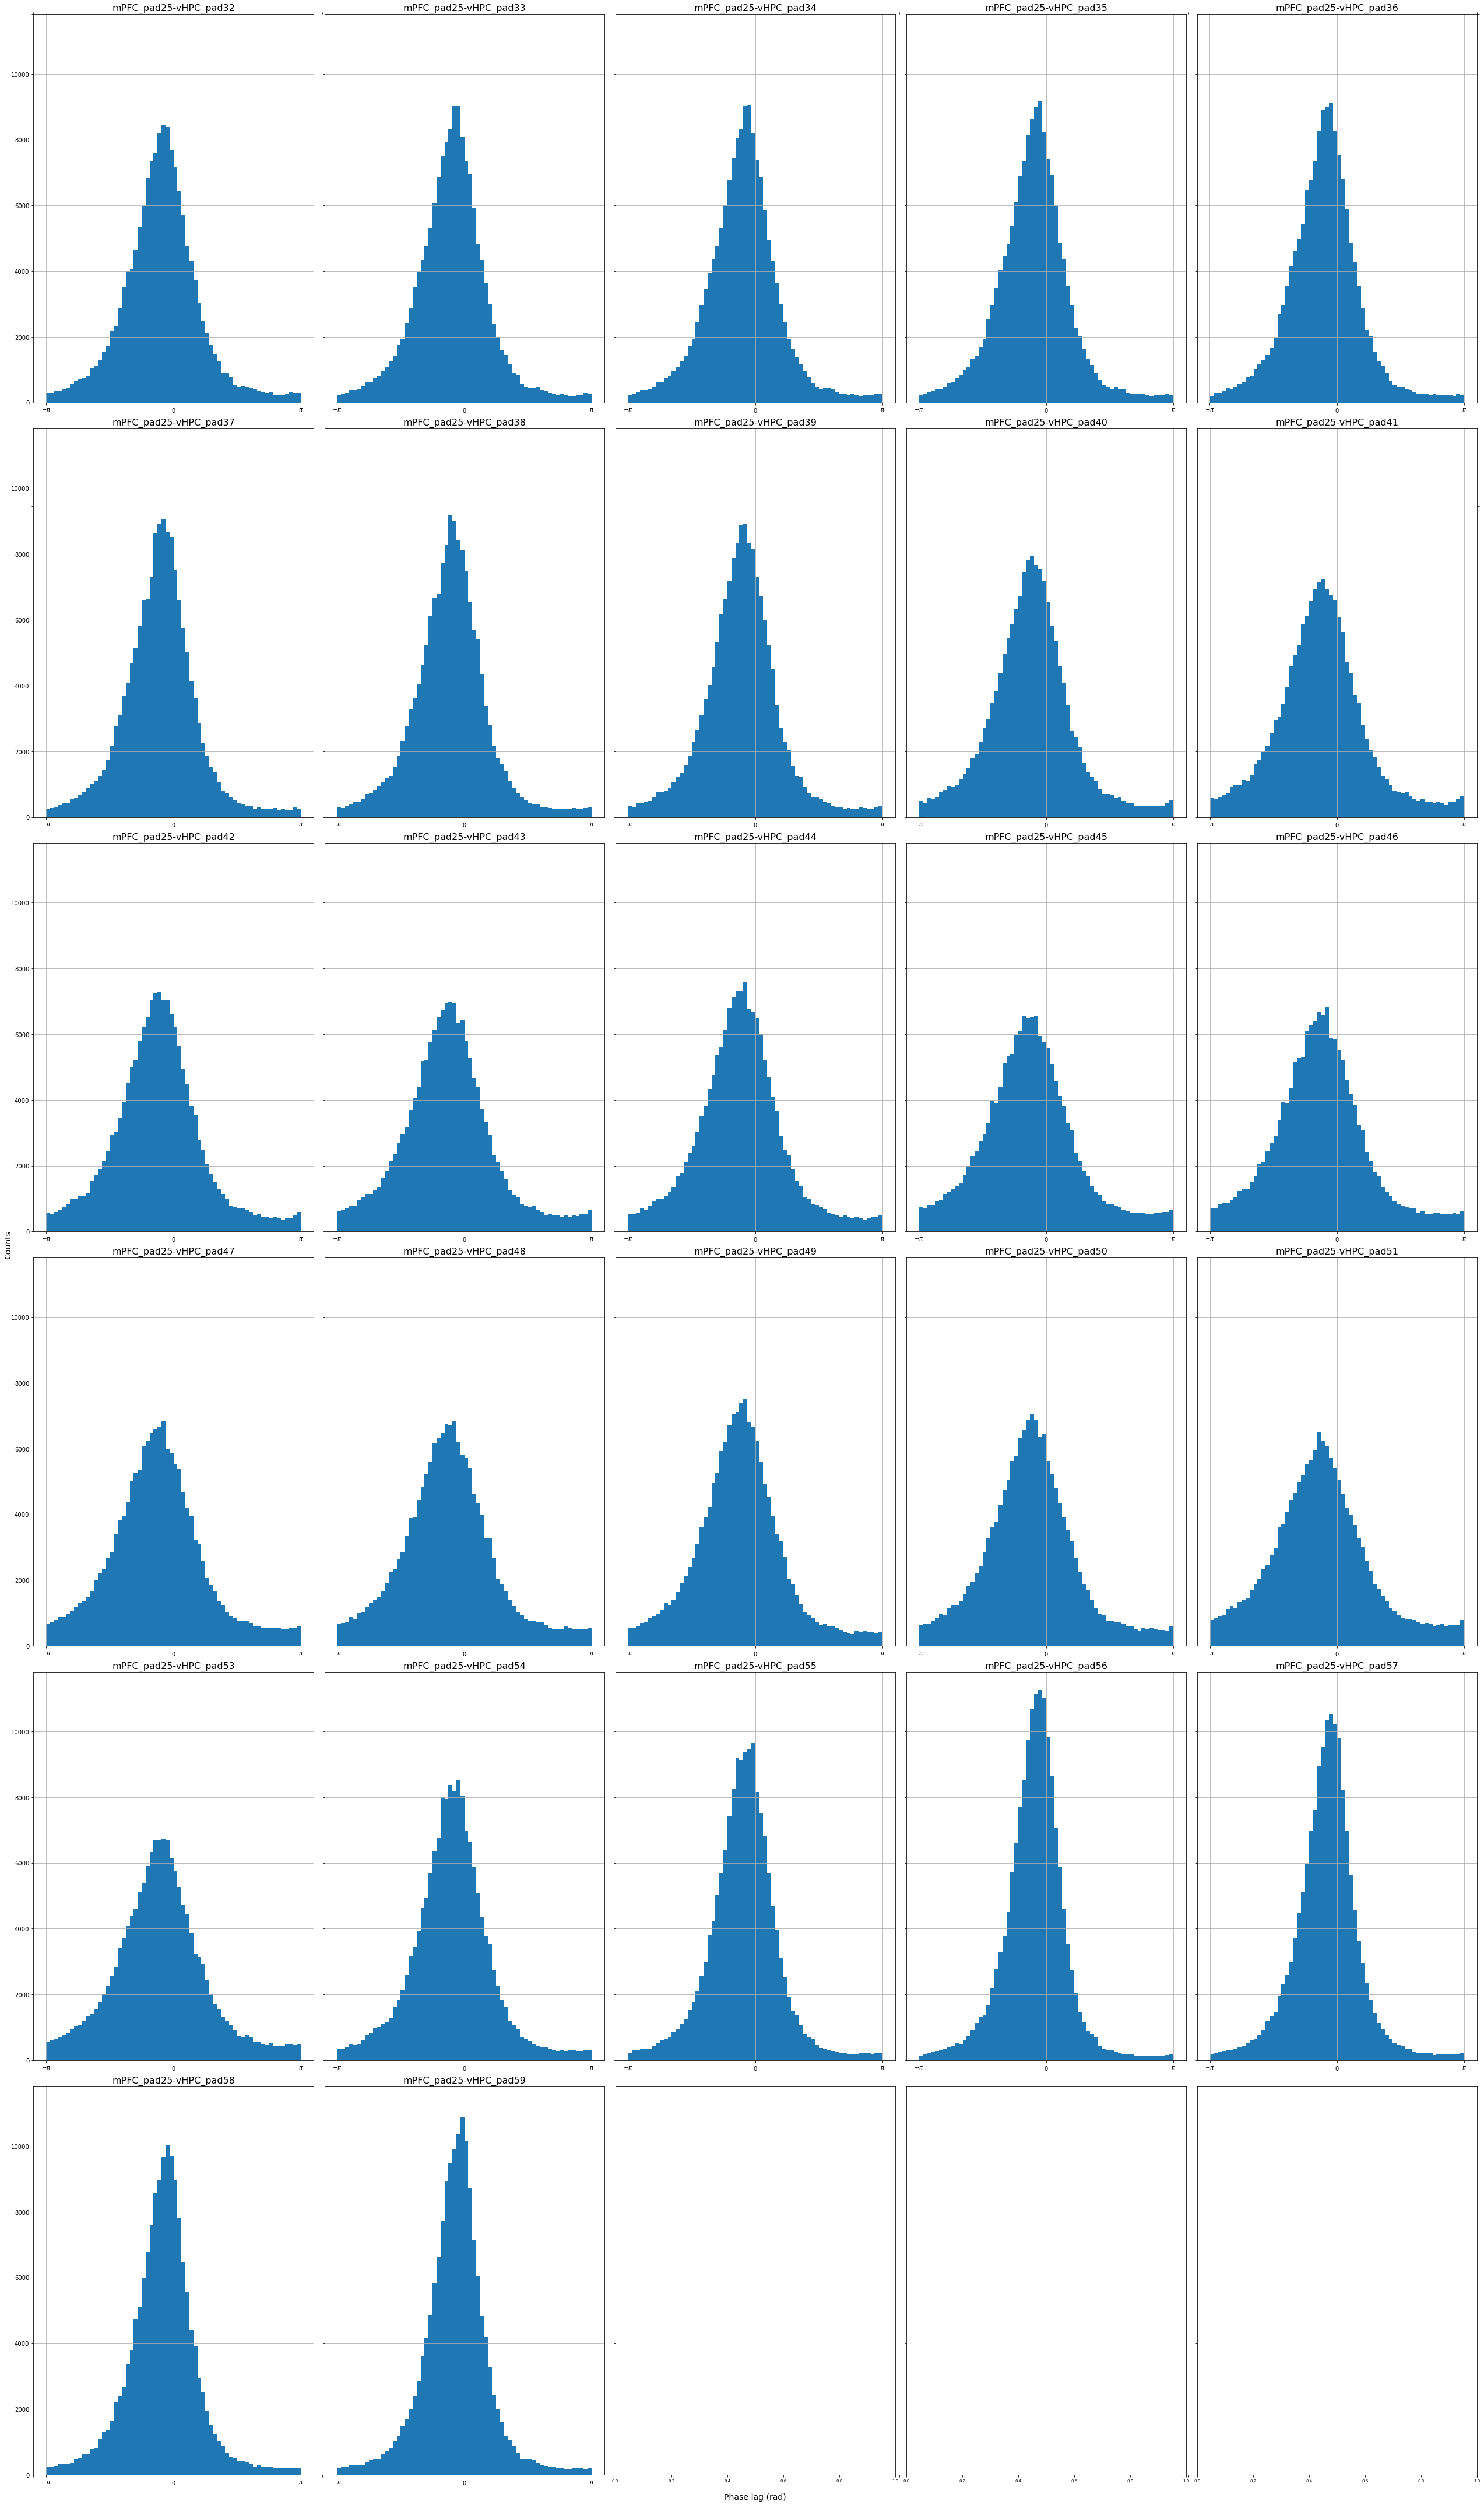

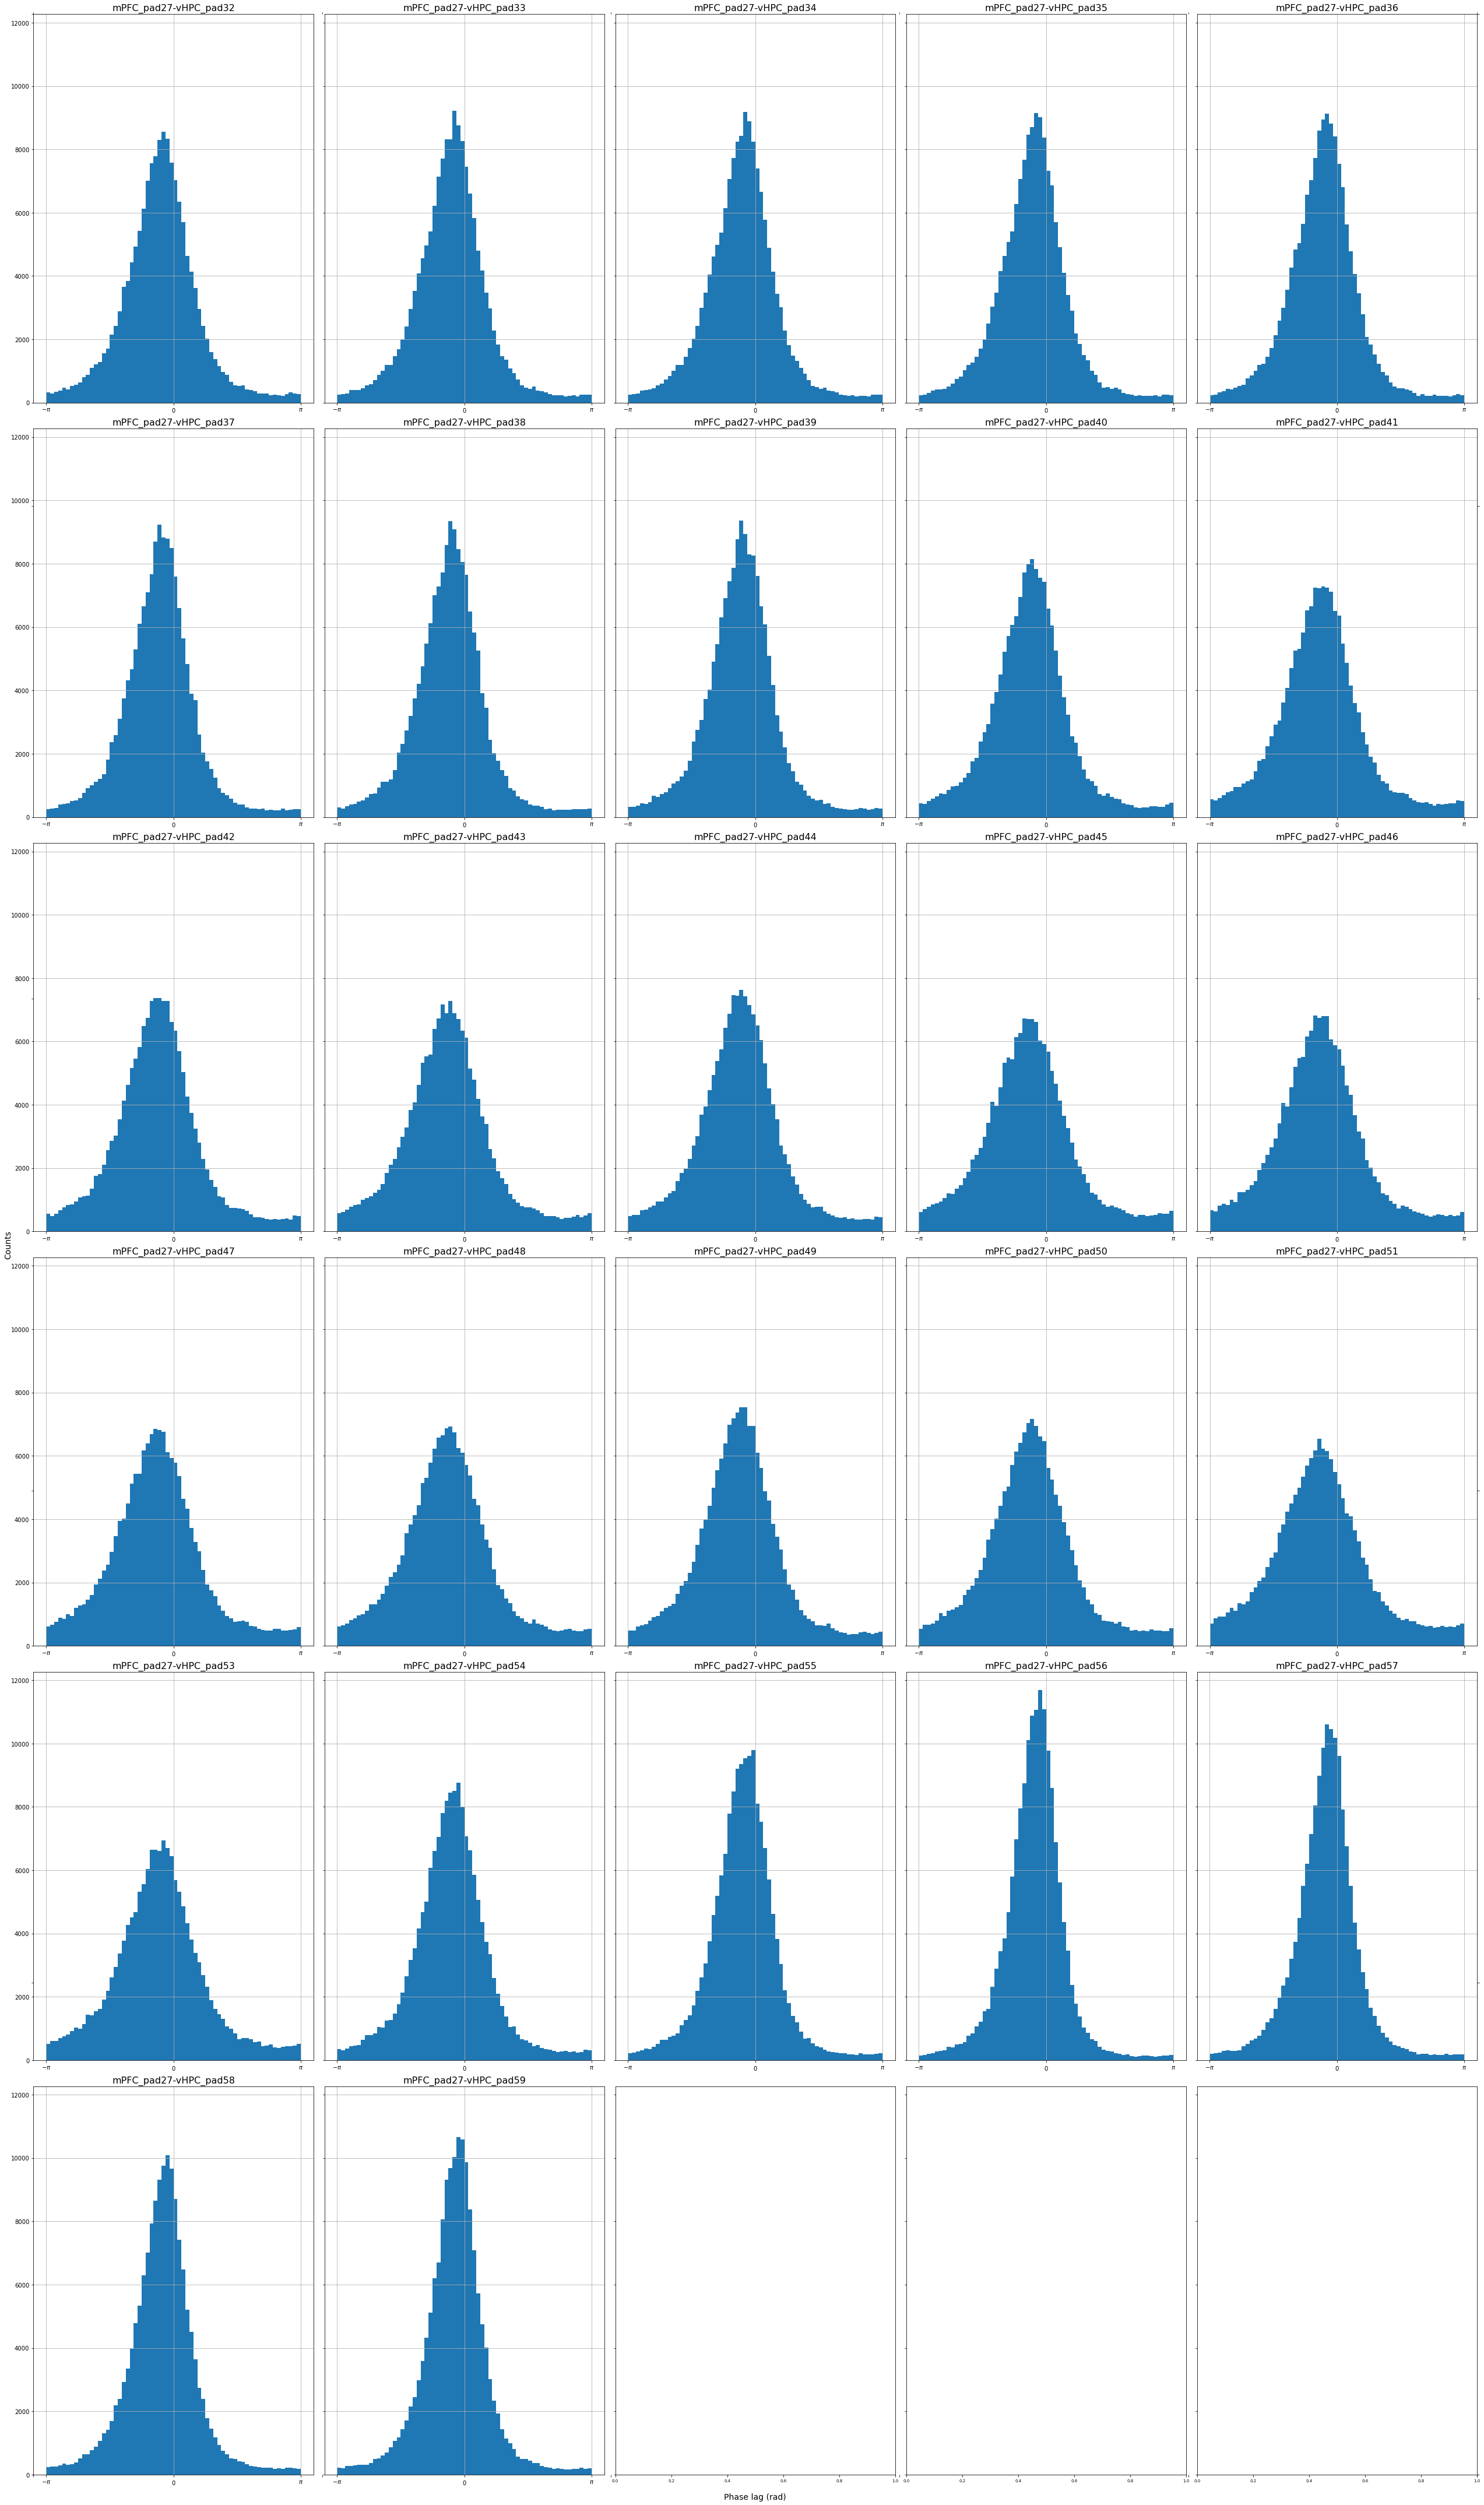

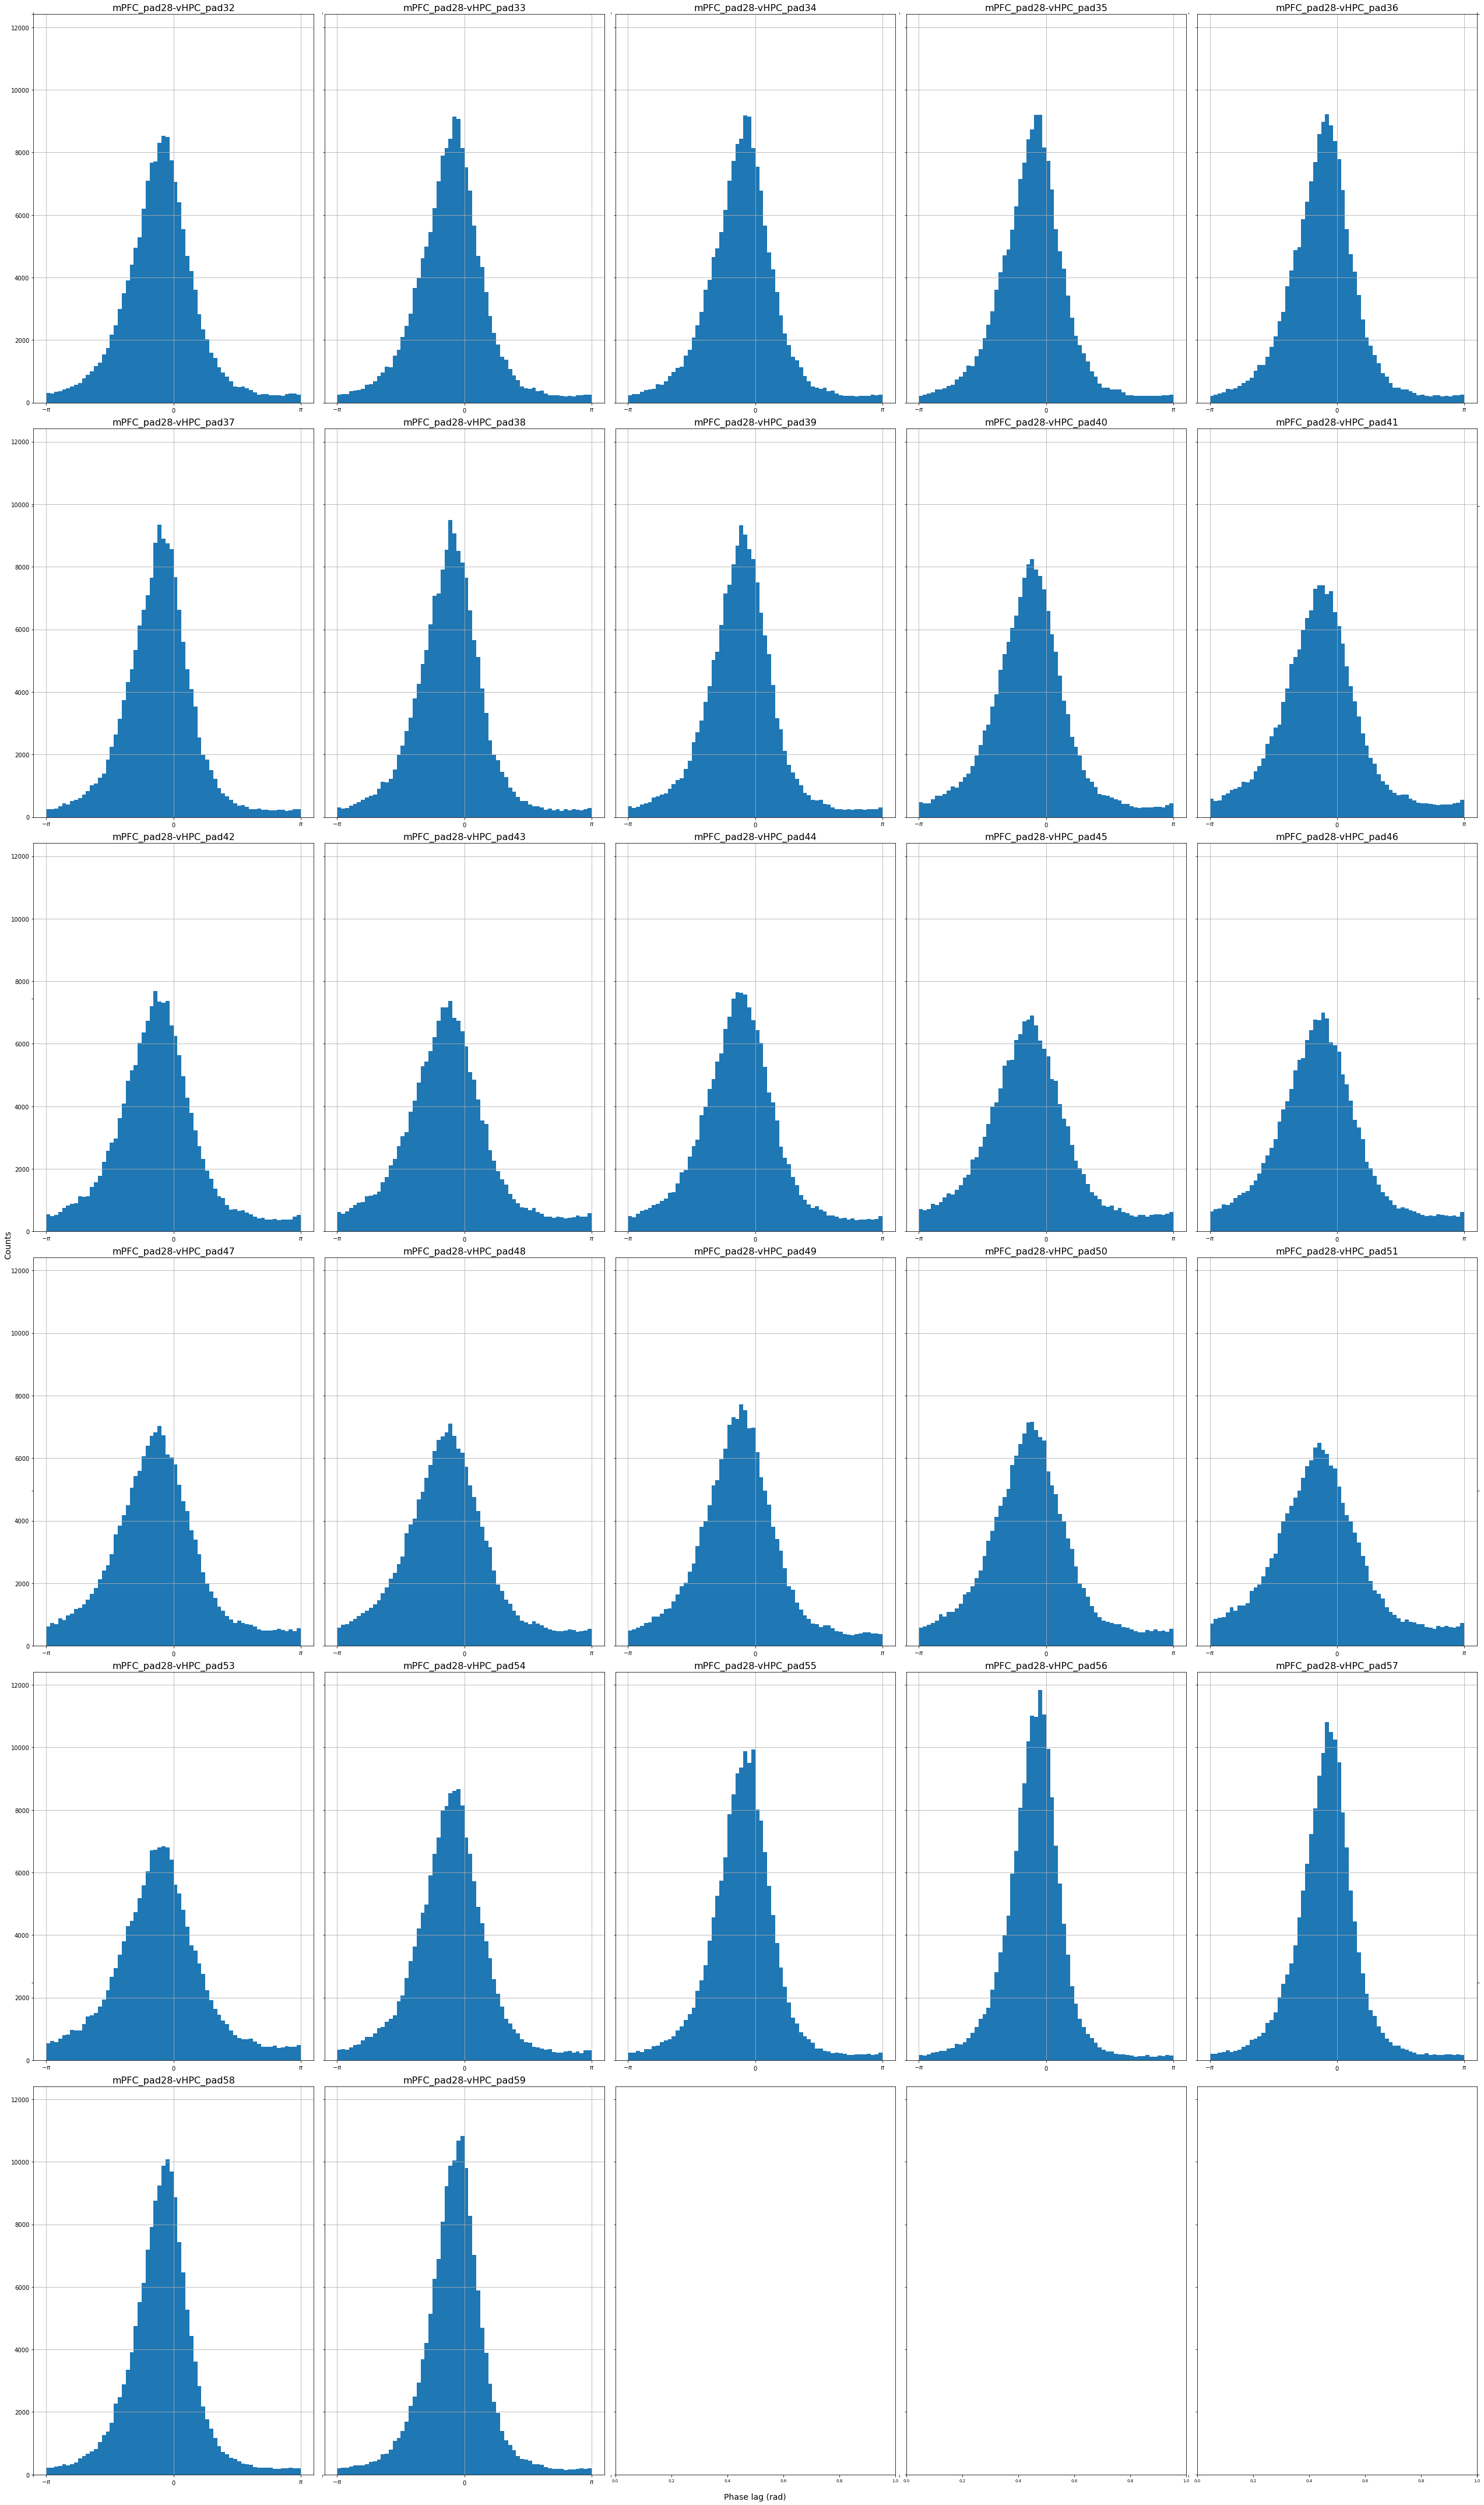

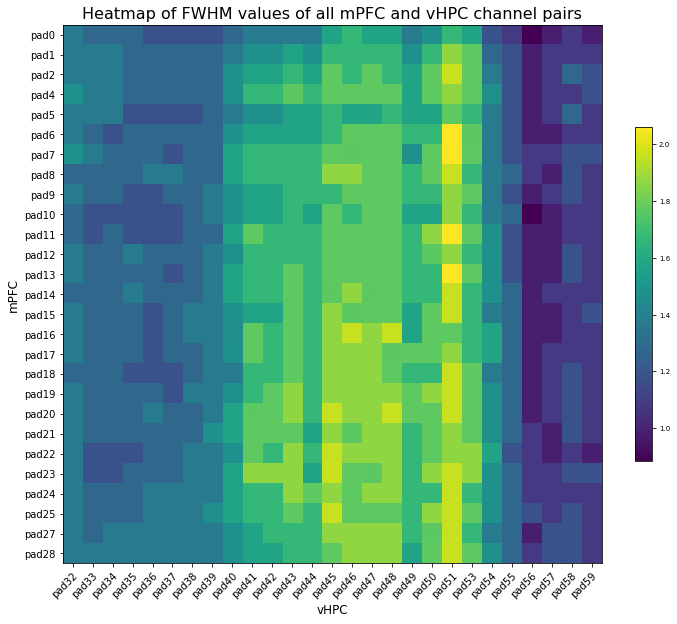

<Figure size 720x720 with 0 Axes>

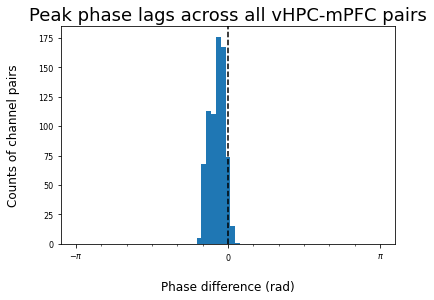

In [6]:
plotting.plot_phase_coh_pairs(dataset, animal, session, savedir='./phase_coh_plots_009_0226arena/', band='theta', exclude=exclude,
                              srate=f_ephys, beh_srate=f_behavior, tstart=behavior_trigger, twin=behavior_window_duration, nbins=64,
                             select_idx=None)

In [ ]:
plotting.plot_crosscorr_pairs(dataset, animal, session, savedir='./crosscorr_plots_009_0219arena/', band='theta', exclude=exclude,
                              srate=f_ephys, tstart=behavior_trigger, twin=behavior_window_duration, select_idx=None)